In [39]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import datetime as dt
from datetime import timezone, timedelta

from pygama.analysis.peak_fitting import gauss_mode_max, gauss_mode_width_max, gauss_basic
from pygama import DataGroup, lh5
from pygama.analysis.histograms import plot_hist
from pygama.utils import plot_func

dsp_dir = '/global/cfs/cdirs/legend/data/cage/LH5/dsp'

In [2]:
#def dsp_to_hit_cage(f_dsp, f_hit, dg, n_max=None, verbose=False, t_start=None):
    
def correct_timestamps(f_dsp):
    dsp = h5py.File(f_dsp)
    ts_old = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['timestamp'])
    ts_old = ts_old.astype(np.int64)
    ts_sec = []
    clock = 100e6 # 100 MHz
    UINT_MAX = 4294967295 # (0xffffffff)
    t_max = UINT_MAX / clock
    ts = ts_old/ clock
    tdiff = np.diff(ts)
    tdiff = np.insert(tdiff, 0 , 0)
    iwrap = np.where(tdiff < 0)
    iloop = np.append(iwrap[0], len(ts))
    ts_new, t_roll = [], 0
    for i, idx in enumerate(iloop):
        ilo = 0 if i==0 else iwrap[0][i-1]
        ihi = idx
        ts_block = ts[ilo:ihi]
        ts_block = (np.array(ts_block)).astype(np.uint64)
        ts_new.append(ts_block + t_roll)
        t_last = ts[ilo-1]
        t_diff = t_max - t_last
        t_roll += t_last + t_diff
    ts_sec = np.concatenate(ts_new)
    return ts_sec

In [106]:
time_intervals = 300
fit_interval = 1800

def find_1460(timestamps, trapEftp):
    ehist, t_edges, e_edges = np.histogram2d(timestamps,  trapEftp, bins=[np.arange(0, timestamps[-1], np.minimum(time_intervals, int(timestamps[-1]-1))), np.arange(1000,5000, 10)])
    ind = np.unravel_index(np.argmax(ehist), ehist.shape)
    return e_edges[ind[1]]

def hist_1460_in_run(dg, run, dsp_folder, plot=True):    
    df = dg.fileDB.query(f'run == {run}')
    cycles = df['cycle']

    f_dsp = f"{dsp_folder}/{df['dsp_file'].iloc[-1]}"
    dsp = h5py.File(f_dsp)

    ts_corrected = correct_timestamps(f_dsp)
    trapEftp = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['trapEftp'])
    baseline = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['bl'])

    adu1460 = find_1460(ts_corrected, trapEftp)
    bl = np.mean(baseline)


    energy_bins = np.arange(adu1460-100, adu1460+101)
    bl_bins = np.arange(bl-50, bl+51)
    time_bins = np.arange(0, df['startTime'].iloc[-1] - df['startTime'].iloc[0] + ts_corrected[-1], time_intervals)
    time_bins = np.append(time_bins, df['startTime'].iloc[-1] - df['startTime'].iloc[0] + ts_corrected[-1])


    ehists = np.zeros((len(time_bins)-1, len(energy_bins)-1))
    blhists = np.zeros((len(time_bins)-1, len(bl_bins)-1))


    for i in range(len(df)):
        f_dsp = f"{dsp_folder}/{df['dsp_file'].iloc[i]}"
        try:
            dsp = h5py.File(f_dsp)
        except OSError:
            continue
        trapEftp = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['trapEftp'])
        baseline = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['bl'])


        ts_corrected = np.array(correct_timestamps(f_dsp) + df['startTime'].iloc[i] - df['startTime'].iloc[0])

        e_cyc = np.histogram2d(ts_corrected, trapEftp, bins=[time_bins, energy_bins])
        b_cyc = np.histogram2d(ts_corrected, baseline, bins=[time_bins, bl_bins])


        ehists += e_cyc[0]
        blhists += b_cyc[0]

    if plot:
        e_data = list(zip([(t, e) for t in time_bins[:-1] for e in energy_bins[:-1]]))
        e_data = [e[0] for e in e_data]
        b_data = list(zip([(t, b) for t in time_bins[:-1] for b in bl_bins[:-1]]))
        b_data = [b[0] for b in b_data]

        ex = [e[0] for e in e_data]
        ey = [e[1] for e in e_data]
        bx = [b[0] for b in b_data]
        by = [b[1] for b in b_data]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))
        fig.suptitle(f'Run {run}')

        ax1.hist2d(ex, ey, bins=[time_bins, energy_bins], weights=np.ravel(ehists))
        ax1.set(xlabel='Timestamp (s)', ylabel='trapEftp (adu)') 

        ax2.hist2d(bx, by, bins=[time_bins, bl_bins], weights=np.ravel(blhists))
        ax2.set(xlabel='Timestamp (s)', ylabel='Baseline (adu)')
    return ehists, blhists, time_bins, energy_bins, bl_bins

#dates should be a string in the format YYYY-MM-DDTHH:MM in UTC (will maybe support timezones later)
#e.g. 2021-06-26T15:00
def hist_1460_over_time(dg, dsp_folder, start_date, end_date, plot=True):
    time_intervals = 900 
    dt_start = dt.fromisoformat(start_date)
    dt_start = dt_start.replace(tzinfo=timezone.utc)
    dt_end = dt.fromisoformat(end_date)
    dt_end = dt_end.replace(tzinfo=timezone.utc)

    
    time_start = dt.timestamp(dt_start)
    time_end = dt.timestamp(dt_end)
    
    df = dg.fileDB.query(f'startTime >= {time_start} & startTime <= {time_end}')
    f_dsp = f"{dsp_folder}/{df['dsp_file'].iloc[0]}"
    dsp = h5py.File(f_dsp)
    ts_corrected = correct_timestamps(f_dsp)
    trapEftp = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['trapEftp'])
    
    adu1460 = find_1460(ts_corrected, trapEftp)
    energy_bins = np.arange(adu1460-200, adu1460+201)
    time_bins = np.arange(time_start, time_end, time_intervals)

    ehists = np.ones((len(time_bins)-1, len(energy_bins)-1))
    
    for i in range(len(df)):
        f_dsp = f"{dsp_folder}/{df['dsp_file'].iloc[i]}"
        try:
            dsp = h5py.File(f_dsp)
        except OSError:
            continue
        trapEftp = np.array(dsp['ORSIS3302DecoderForEnergy']['dsp']['trapEftp'])

        ts_corrected = np.array(correct_timestamps(f_dsp) + df['startTime'].iloc[i])

        e_cyc = np.histogram2d(ts_corrected, trapEftp, bins=[time_bins, energy_bins])
    
        ehists += e_cyc[0]

    if plot:
        e_data = list(zip([(t, e) for t in time_bins[:-1] for e in energy_bins[:-1]]))
        e_data = [e[0] for e in e_data]

        ex = [e[0] for e in e_data]
        ey = [e[1] for e in e_data]

        fig, ax = plt.subplots(1,1,figsize=(12,10))
        fig.suptitle(f'1460 line from {start_date} to {end_date}')
                
        print(np.amin(ehists))
        print(np.amax(ehists))
        
        #dt_bins = [dt.fromtimestamp(time_bins[j], tz=timezone.utc) for j in range(len(time_bins))]
        #date_bins = [dt.isoformat(dt_bins[j]) for j in range(len(dt_bins))]

        hist = ax.hist2d(ex, ey, bins=[time_bins, energy_bins], weights=np.ravel(ehists), norm=colors.LogNorm())
        ax.set(xlabel='Time (UTC)', ylabel='trapEftp (adu)') 
        
        start_label = dt_start
        if start_label.time().hour < 12:
            start_label = start_label.replace(hour=12, minute=0)
        else:
            start_label = start_label.replace(day=(dt_start.date().day+1), hour=0, minute=0)
            
        start_label = start_label.replace(tzinfo=None)
        xlabels = [start_label + timedelta(hours=24*j) for j in range(int((time_end-time_start)/(24*3600)))]
        xticks = [dt.timestamp(xlabels[j]) for j in range(len(xlabels))]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels, rotation=45, ha='right')
        
        fig.colorbar(hist[3])
        
        #ticks = ax.get_xticks()
        #new_labels = [dt.isoformat((dt.fromtimestamp(ticks[j], tz=timezone.utc)).replace(tzinfo=None), timespec='minutes') for j in range(len(ticks))]
        #ax.set_xticklabels(new_labels, rotation=45, ha="right")
 
    return ehists

def fit_peaks(ehists, blhists, time_bins, energy_bins, bl_bins, plot=False):
    e_total = []
    b_total = []
    for j in range(len(time_bins)-1):      
        e_max = np.amax(ehists[j][:])
        e_max_ind = np.argmax(ehists[j][:])
        
        if e_max < 5:
            e_total.append((0,0))
            b_total.append((0,0))
            continue
        
        e_where = np.where(ehists[j][:] >= e_max)[0]
        #print(e_where)
        e_fwhm = np.maximum(np.abs(energy_bins[e_max_ind]-energy_bins[e_where[0]]), np.abs(energy_bins[e_max_ind]-energy_bins[e_where[-1]]))
        
                
        e_total.append((energy_bins[e_max_ind], e_fwhm))
        
        b_max = np.amax(blhists[j][:])
        b_max_ind = np.argmax(blhists[j][:])
    
        b_where = np.where(blhists[j][:] >= b_max)[0]
        b_fwhm = np.maximum(np.abs(bl_bins[b_max_ind]-bl_bins[b_where[0]]), np.abs(bl_bins[b_max_ind]-bl_bins[b_where[-1]]))
                
        b_total.append((bl_bins[b_max_ind], b_fwhm))
                

        if plot:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))
            fig.suptitle(f'Time {time_bins[j]}-{time_bins[j+1]}')

            ax1.hist(energy_bins[:-1], bins=energy_bins, weights=ehists[j])
            ax1.set(xlabel='trapEftp (adu)', ylabel='count')

            ax2.hist(bl_bins[:-1], bins=bl_bins, weights=blhists[j])
            ax2.set(xlabel='baseline (adu)', ylabel='count')            


    return e_total, b_total

# Returns: slope of up to first hour of data in run
def find_slope_in_run(time_bins, e_total, b_total):
    x = time_bins[-1]
    if x > fit_interval: 
        x = fit_interval
    x /= time_intervals
    try:
        e_fit = np.polyfit(time_bins[:int(x)], [e_total[j][0] for j in range(int(x))], 1, w=1/np.sqrt([e_total[j][1] + 1 for j in range(int(x))]), cov=True)
        b_fit = np.polyfit(time_bins[:int(x)], [b_total[j][0] for j in range(int(x))], 1, w=1/np.sqrt([b_total[j][1] + 1 for j in range(int(x))]), cov=True)
    except np.linalg.LinAlgError as err:
        print(err)
        return None
    return e_fit, b_fit
    
    
#a drift is a list [run, e_fit, b_fit]
def find_drifts(dg, runs, dsp_folder, plot=False, plot_max=False):
    drifts = []
    if isinstance(runs, int):
        runs = [runs]
            
    for i in range(len(runs)):
        r = runs[i]
        df = dg.fileDB.query(f'run == {r}')
        ehists, blhists, time_bins, energy_bins, bl_bins = hist_1460_in_run(dg, r, dsp_folder, False)
        e_total, b_total = fit_peaks(ehists, blhists, time_bins, energy_bins, bl_bins, plot_max)

        x = time_bins[-1]
        if x > fit_interval: 
            x = fit_interval
        x /= time_intervals
        
        fit = find_slope_in_run(time_bins, e_total, b_total)
        
        if fit is not None:
            efit = fit[0]
            bfit = fit[1]
            efit_slope = efit[0][0]
            efit_int = efit[0][1]
            efit_unc = efit[1][0][0]
            bfit_slope = bfit[0][0]
            bfit_int = bfit[0][1]
            bfit_unc = bfit[1][0][0]
            
            #print(np.abs(efit_slope)*x*time_intervals, np.std([e_total[j][0] for j in range(len(e_total))]))
            #print(np.abs(bfit_slope)*x*time_intervals, np.std([b_total[j][0] for j in range(len(b_total))]))

            #print(np.std([e_total[j][0] for j in range(int(len(e_total)/3), int(len(e_total)*2/3))]))
            delta_e = np.abs(efit_slope)*x*time_intervals
            delta_b = np.abs(bfit_slope)*x*time_intervals
            sigma_e = np.std([e_total[j][0] for j in range(int(len(e_total)/3), len(e_total))])
            sigma_b = np.std([b_total[j][0] for j in range(int(len(b_total)/3), len(b_total))])
            
            
            
            if (delta_e > 6*sigma_e and np.abs(efit_slope) > 1e-3) or (delta_b > 6*sigma_b and np.abs(bfit_slope) > 1e-3):            
                print("1460: ", delta_e, 6*sigma_e)
                print("Baseline: ", delta_b, 6*sigma_b)
                
                if sigma_e == 0 or sigma_b == 0:
                    print([e_total[j][0] for j in range(int(len(e_total)/3), len(e_total))])
                    print([b_total[j][0] for j in range(int(len(b_total)/3), len(b_total))])

                drifts.append((r,(efit_slope, efit_int, efit_unc), (bfit_slope, bfit_int, bfit_unc)))
        
            if plot:
                x = time_bins[-1]
                if x > fit_interval: 
                    x = fit_interval
                x /= time_intervals

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))
                fig.suptitle(f'Run {r}')

                #ax1.errorbar(time_bins[:-1], [e[0] for e in e_total], xerr=None, yerr=[e[1] for e in e_total], ecolor='r' )
                ax1.plot(time_bins[:-1], [e[0] for e in e_total])
                ax1.plot(time_bins[:int(x)], efit_slope*time_bins[:int(x)] + efit_int, label='slope = {:.2E} +- {:.2E}'.format(efit_slope, efit_unc), color='orange', linewidth=4)
                ax1.set(xlabel='timestamps', ylabel='trapEftp (adc)', ylim=(np.max(e_total[:][0])-50, (np.max(e_total[:][0])+50)))
                ax1.legend()

                #ax2.errorbar(time_bins[:-1],  [b[0] for b in b_total], xerr=None, yerr=[b[1] for b in b_total], ecolor='r')
                ax2.plot(time_bins[:-1],  [b[0] for b in b_total])
                ax2.plot(time_bins[:int(x)], bfit_slope*time_bins[:int(x)] + bfit_int, label='slope = {:.2E} +- {:.2E}'.format(bfit_slope, bfit_unc), color='orange', linewidth=4)
                ax2.set(xlabel='timestamps', ylabel='baseline (adc)', ylim=(np.max(b_total[:][0])-30, (np.max(b_total[:][0])+30)))
                ax2.legend()
                plt.show()
        elif plot:
            x = time_bins[-1]
            if x > fit_interval: 
                x = fit_interval
            x /= time_intervals

            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,10))
            fig.suptitle(f'Run {r}')

            ax1.plot(time_bins[:-1], [e[0] for e in e_total])
            ax1.set(xlabel='timestamps', ylabel='trapEftp (adc)', ylim=(np.max(e_total[:][0])-50, (np.max(e_total[:][0])+50)))

            ax2.plot(time_bins[:-1],  [b[0] for b in b_total])
    
            ax2.set(xlabel='timestamps', ylabel='baseline (adc)', ylim=(np.max(b_total[:][0])-30, (np.max(b_total[:][0])+30)))
                
    return drifts

854.693548135523


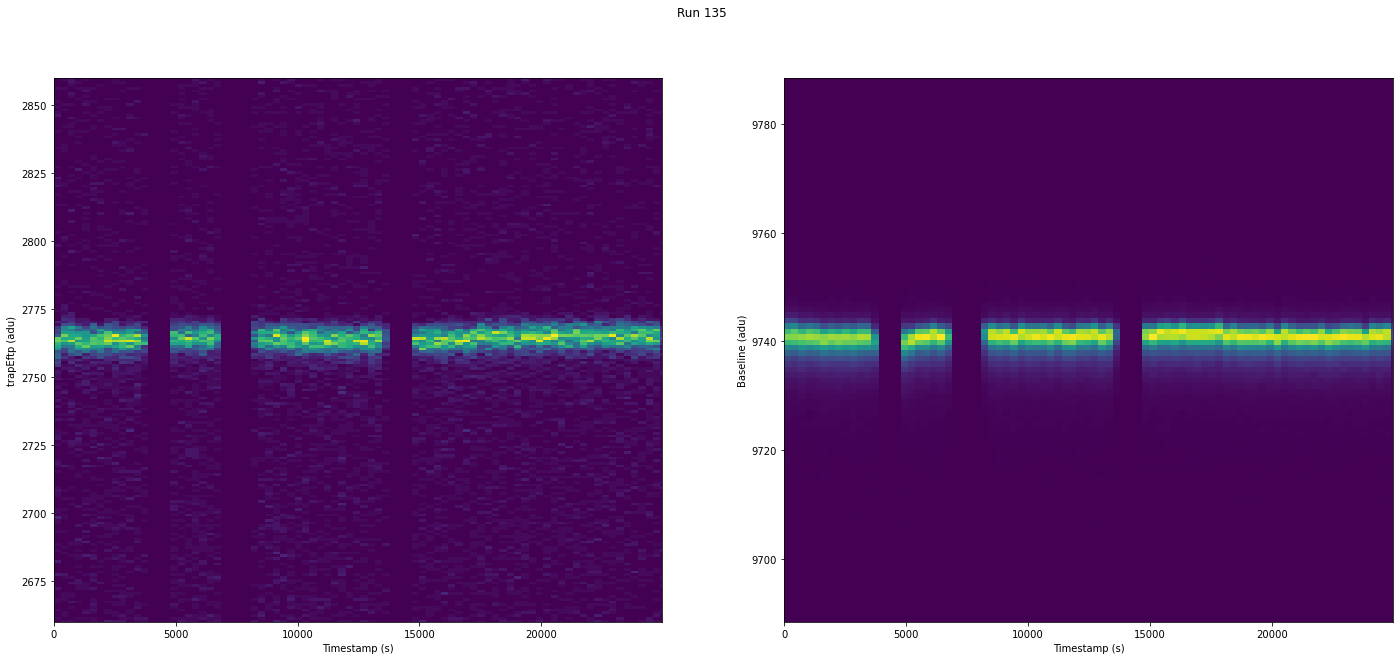

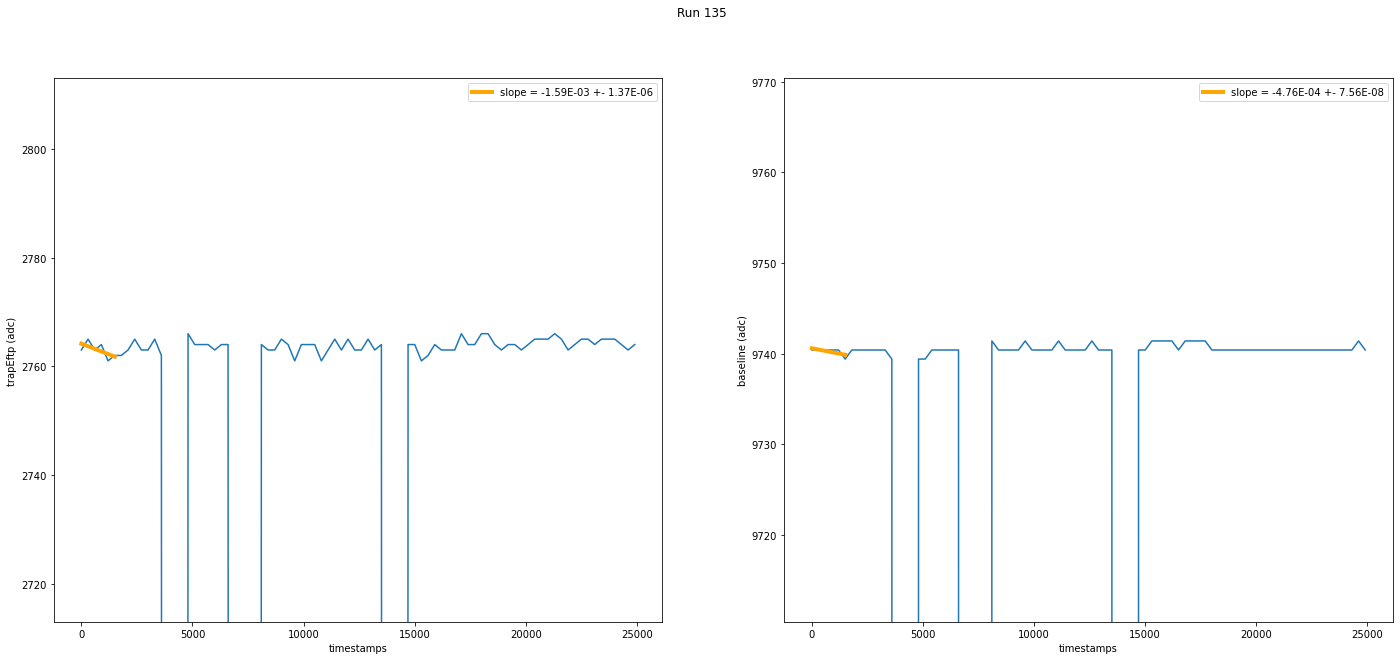

In [64]:
dg = DataGroup('../processing/cage.json', load=True)
run = 135
ehists, blhists, time_bins, energy_bins, bl_bins = hist_1460_in_run(dg, run, dsp_dir, True)

d = find_drifts(dg, run, dsp_dir, True, False)
print(*d, sep = "\n")

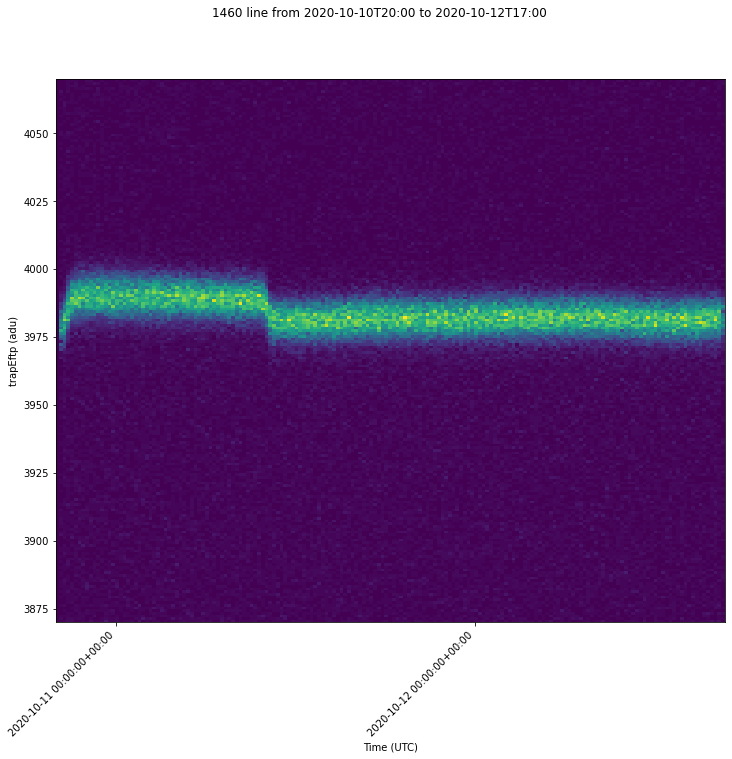

In [18]:
hist_1460_over_time(dg, dsp_dir, "2020-10-10T20:00", "2020-10-12T17:00", plot=True);

1.0
3087.0


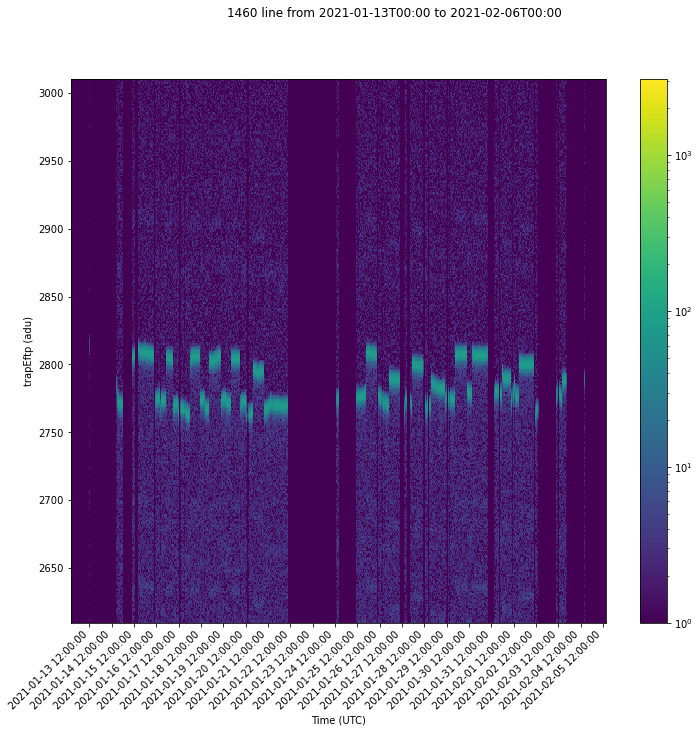

In [63]:
hist_1460_over_time(dg, dsp_dir, "2021-01-13T00:00", "2021-02-06T00:00", plot=True);

1.0
3087.0


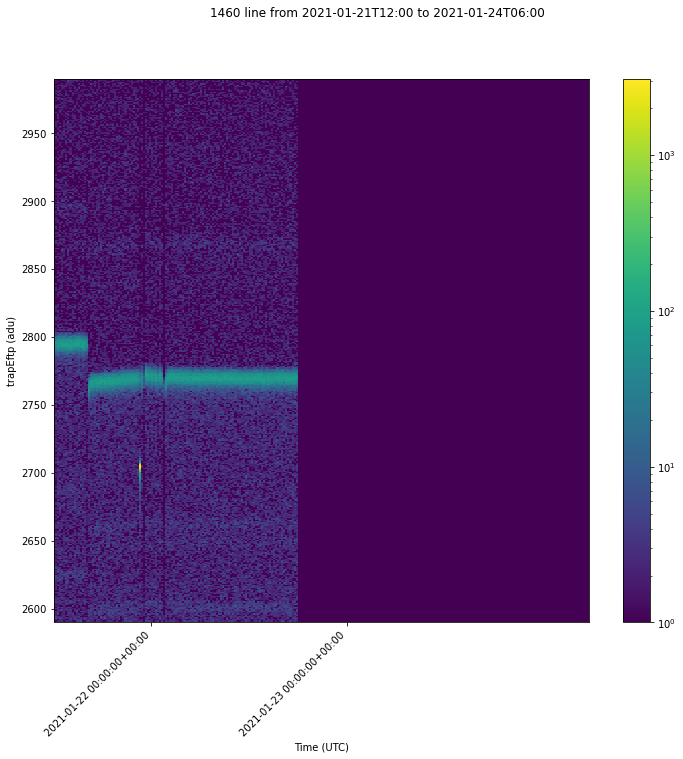

In [56]:
hist_1460_over_time(dg, dsp_dir, "2021-01-21T12:00", "2021-01-24T06:00", plot=True);

1.0
113.0


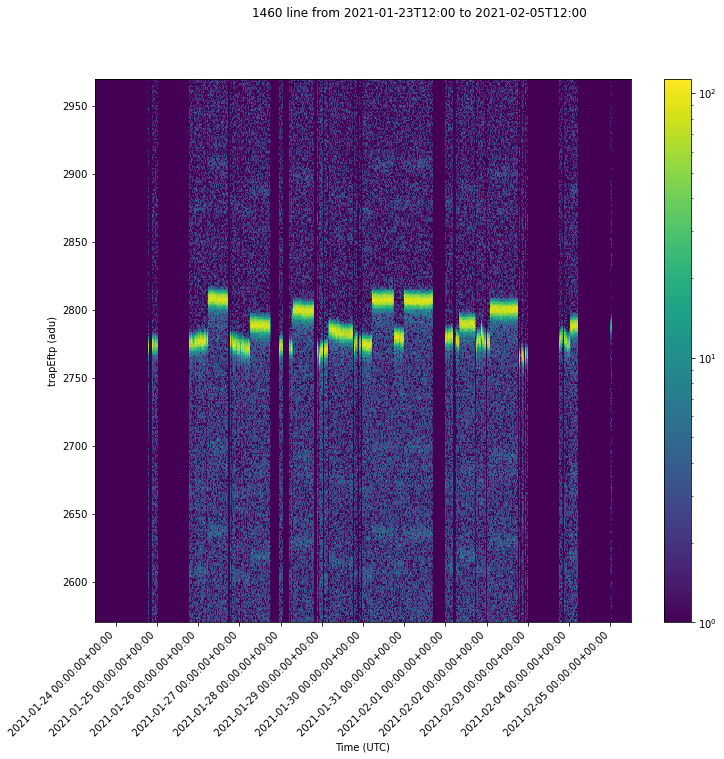

In [57]:
hist_1460_over_time(dg, dsp_dir, "2021-01-23T12:00", "2021-02-05T12:00", plot=True);

In [158]:
dg = DataGroup('../processing/cage.json', load=True)
df = dg.fileDB.query(f'run == {77}')
print(df.keys())
print(dt.fromtimestamp(df['startTime'].iloc[0]))
print((df['dsp_file']).iloc[0])

Index(['unique_key', 'YYYY', 'mm', 'dd', 'cycle', 'daq_dir', 'daq_file', 'run',
       'runtype', 'detector', 'skip', 'raw_file', 'raw_path', 'dsp_file',
       'dsp_path', 'hit_file', 'hit_path', 'startTime', 'threshold', 'daq_gb',
       'stopTime', 'runtime'],
      dtype='object')
2020-10-10 13:38:17
cage_run77_cyc963_dsp.lh5


1.842416610580286


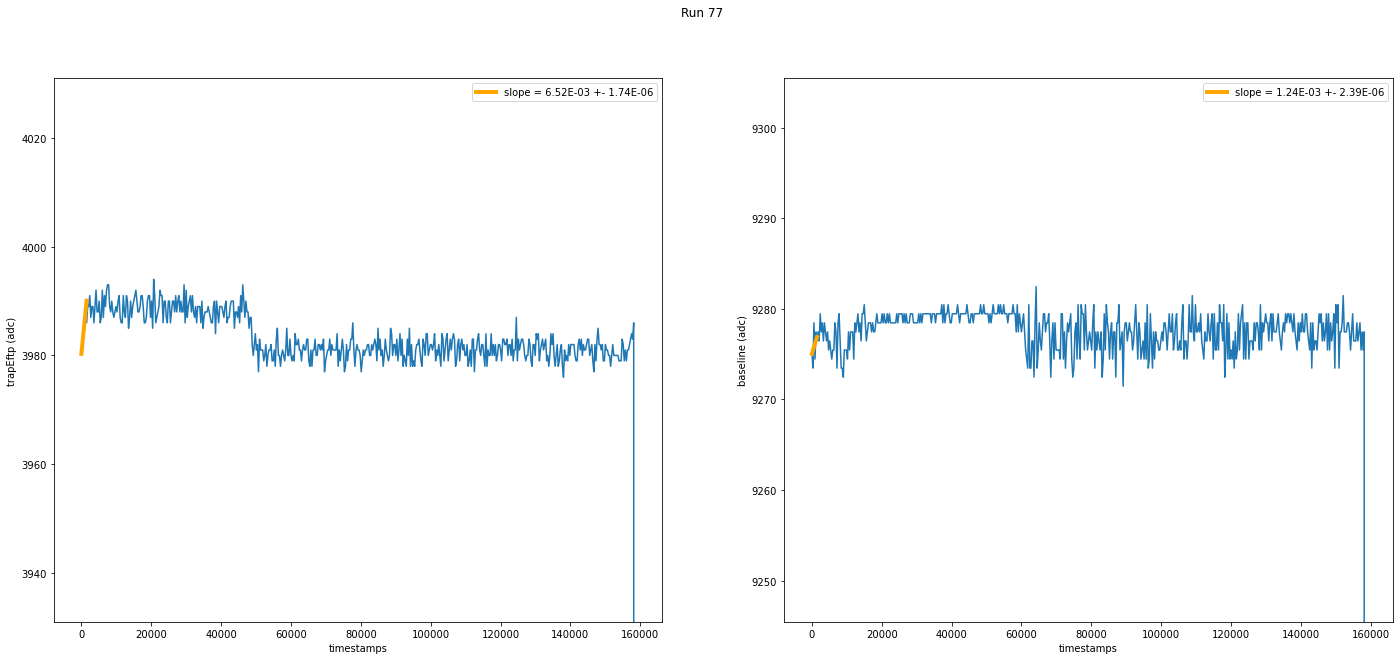

(77, (0.006520284399833701, 3980.2848180677524, 1.7407743837943499e-06), (0.0012380952380962426, 9275.021623883924, 2.3945578231286036e-06))


In [21]:
d = find_drifts(dg, 77, dsp_dir, True, False)
print(*d, sep = "\n")

1460:  14.57142857142964 5.878956555164768
Baseline:  0.34285714285413826 2.5384615384615388


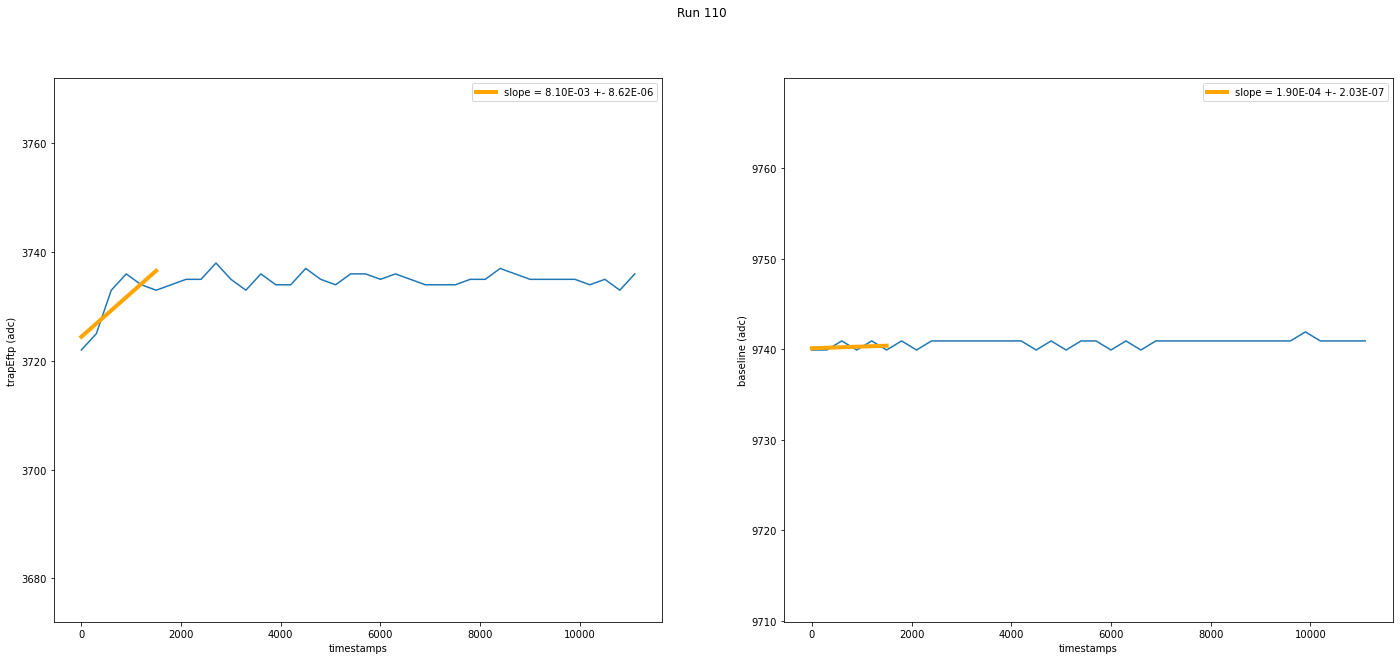

(110, (0.00809523809523869, 3724.428571428569, 8.616780045352789e-06), (0.00019047619047452124, 9740.109421502972, 2.0256991685595078e-07))


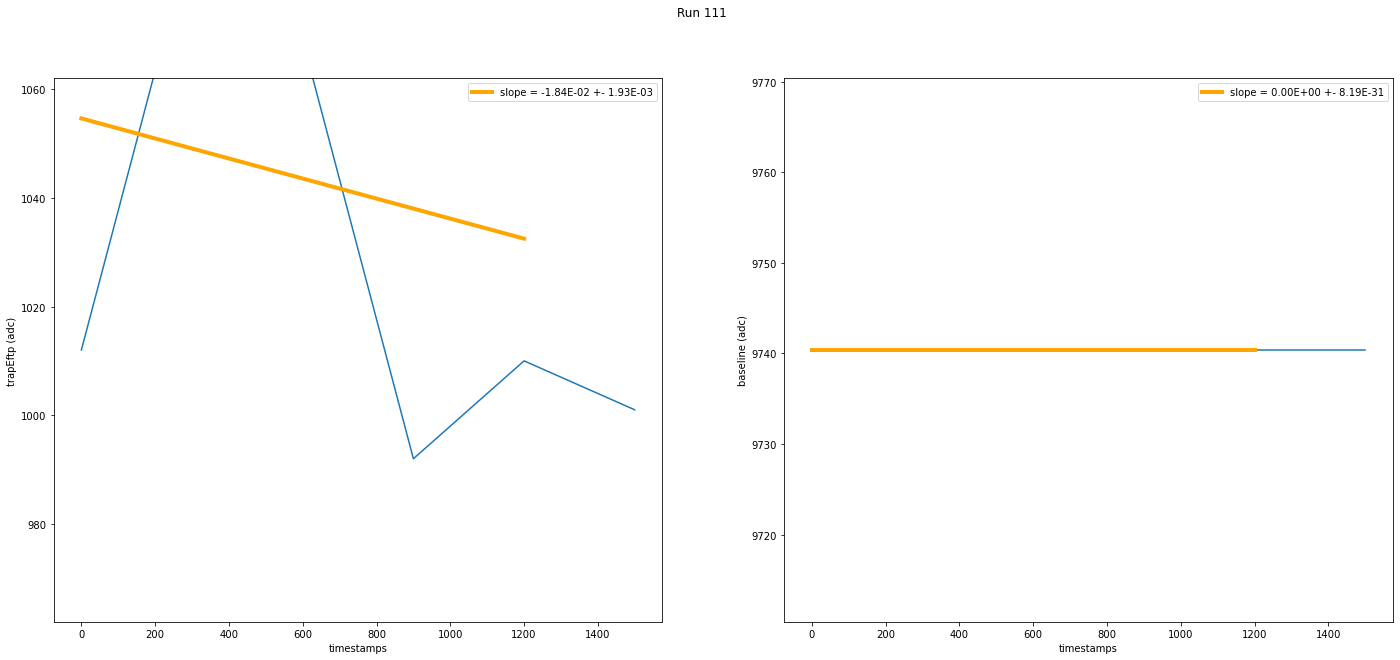

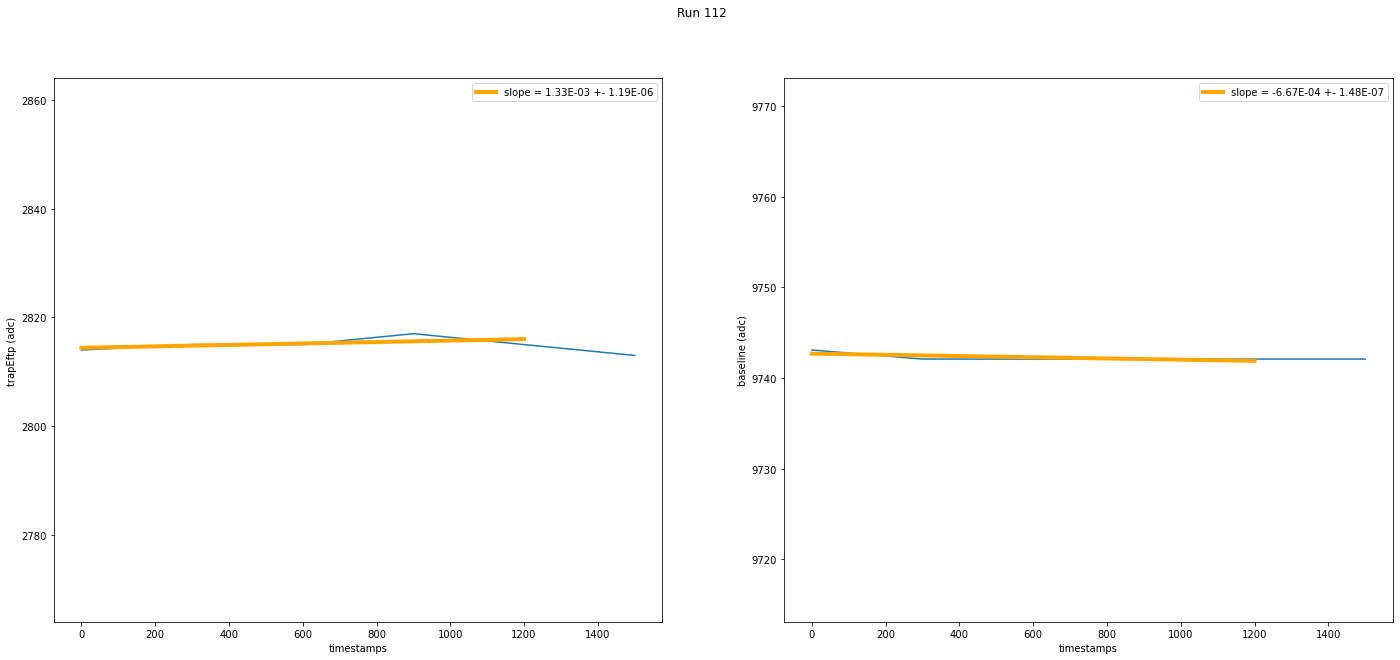

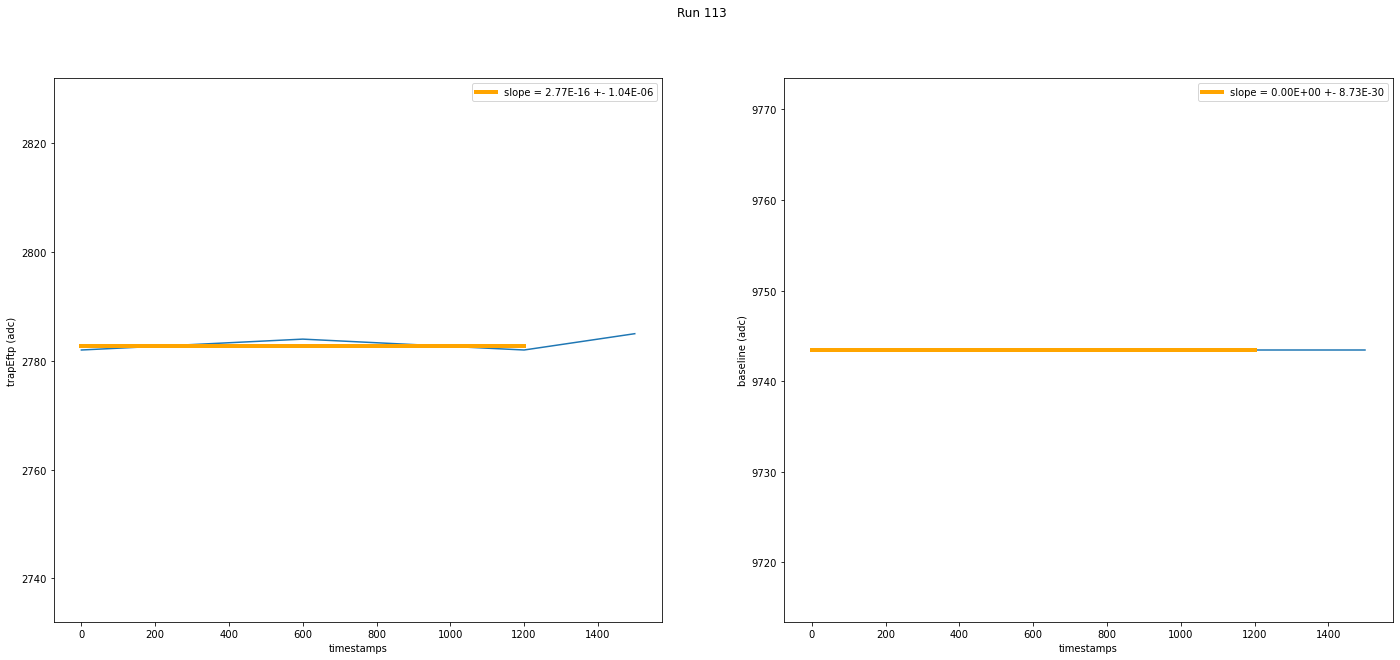


1460:  7.19200000000083 6.538348415311011
Baseline:  0.599333333333195 2.598076211353316


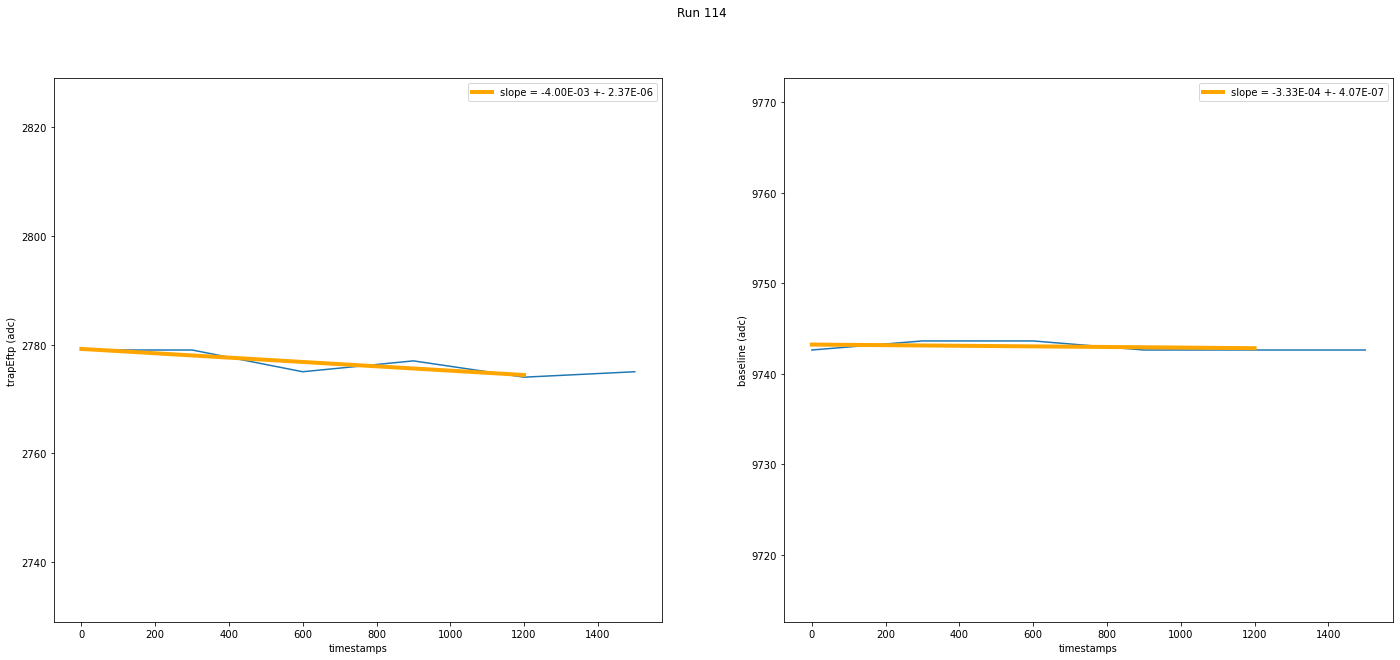

(114, (-0.0040000000000004615, 2779.199999999999, 2.370370370369643e-06), (-0.00033333333333325645, 9743.221093749993, 4.074074074073612e-07))


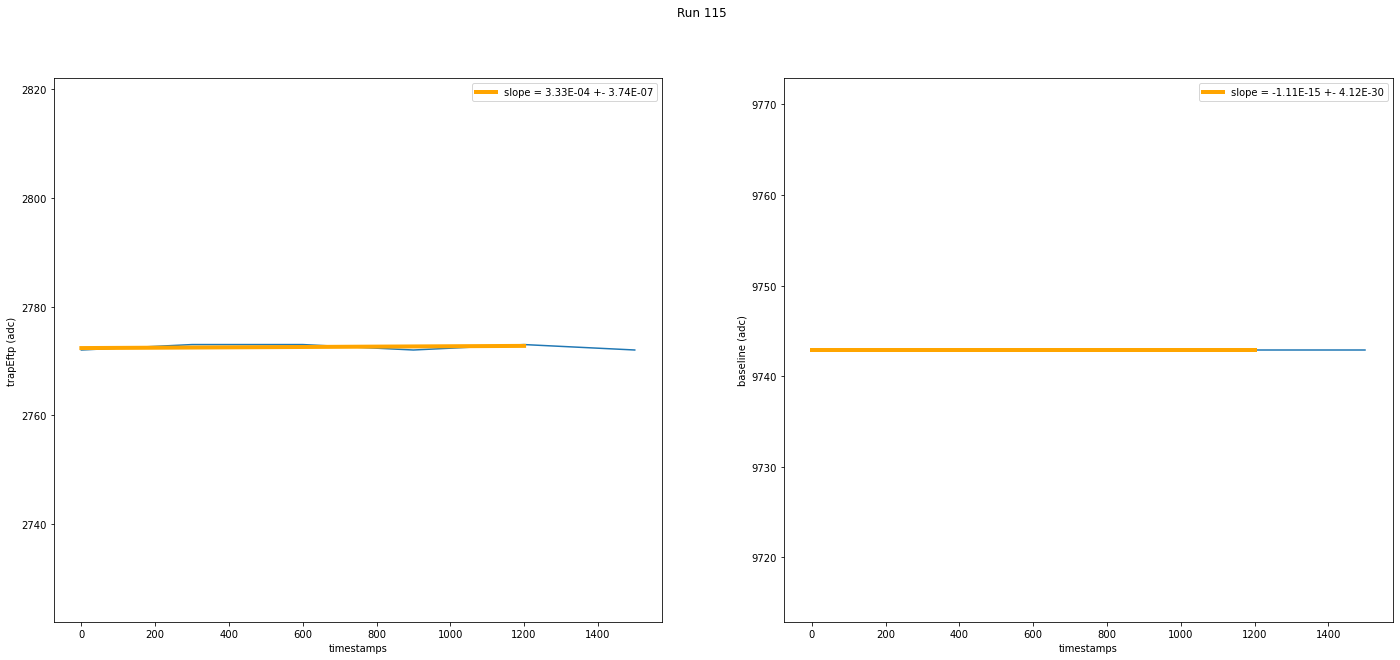

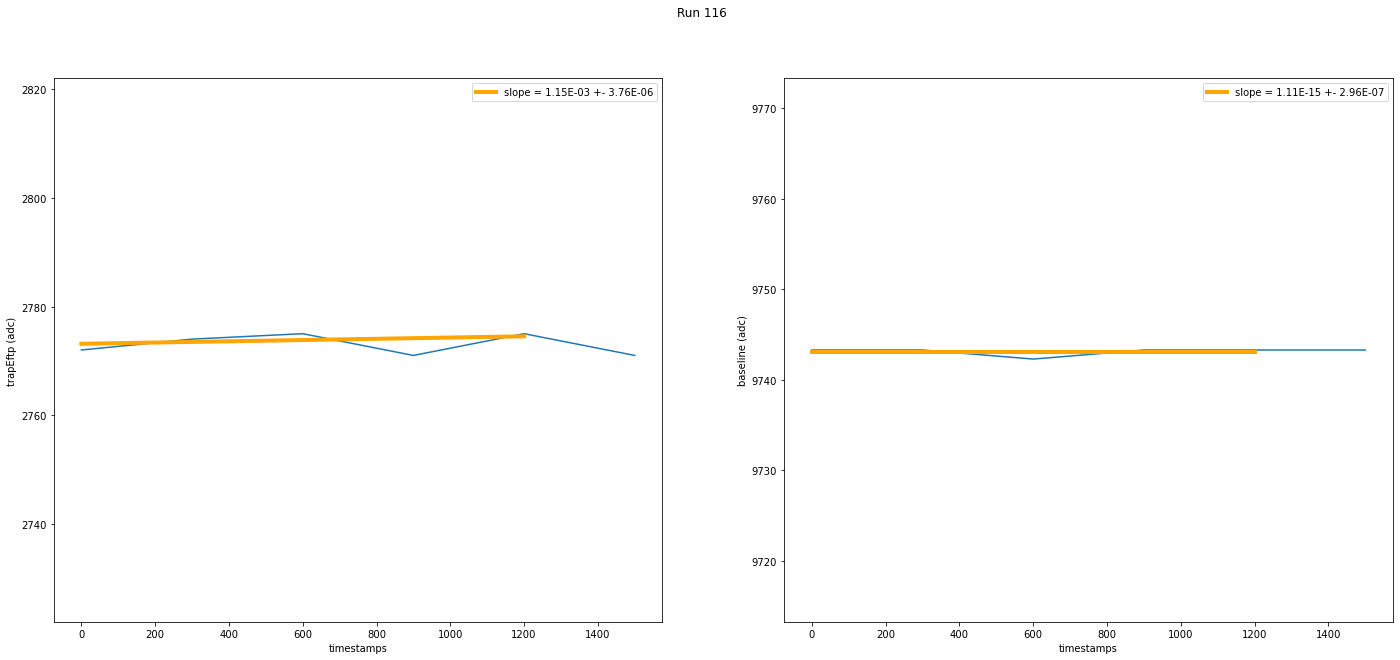

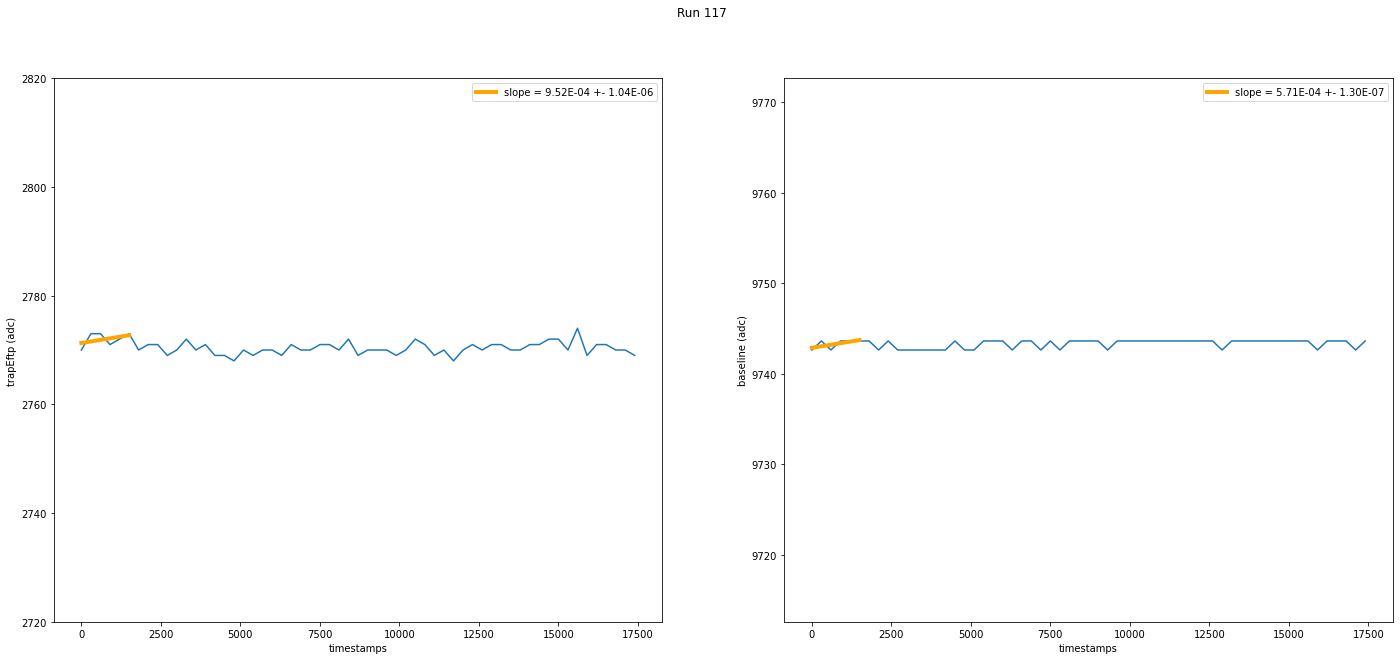

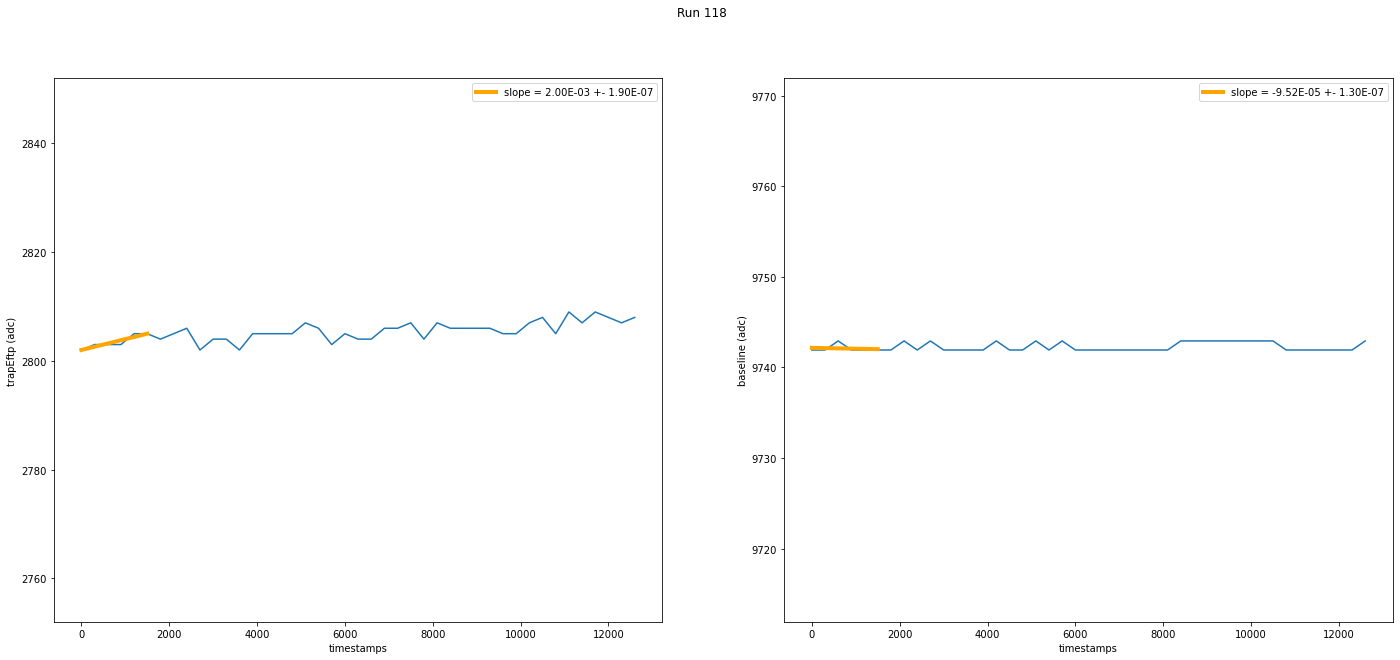

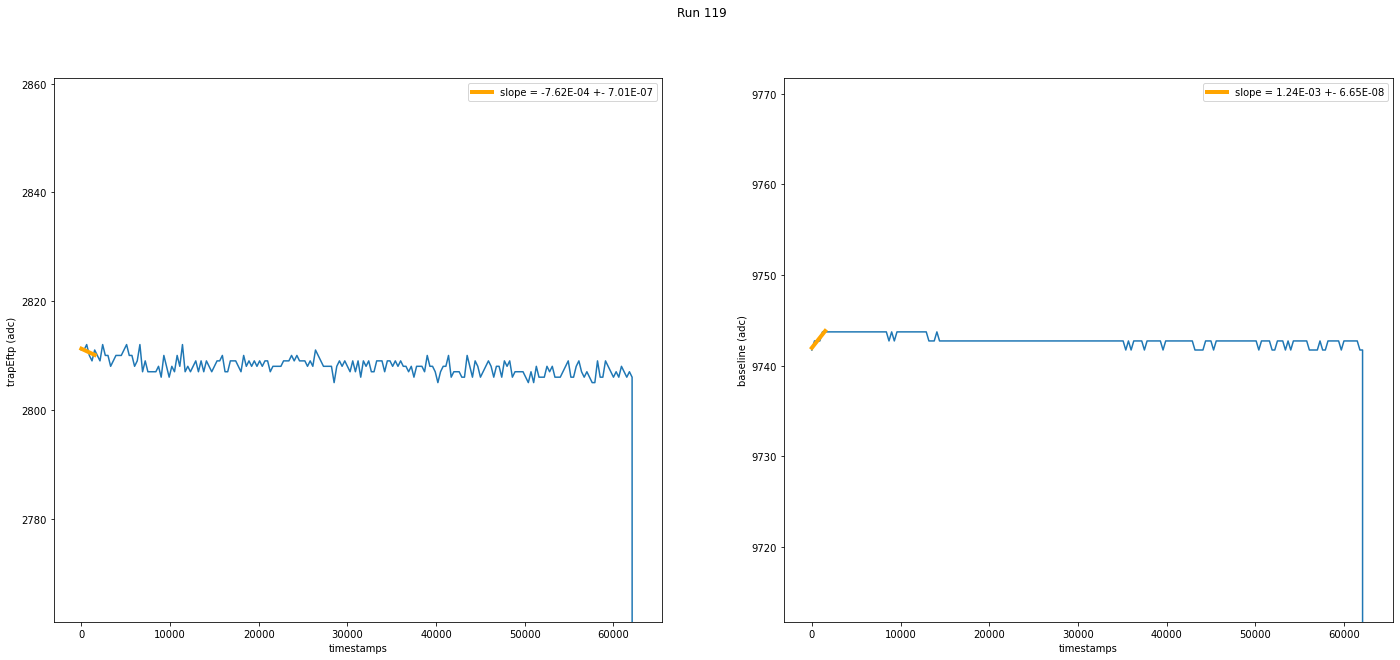

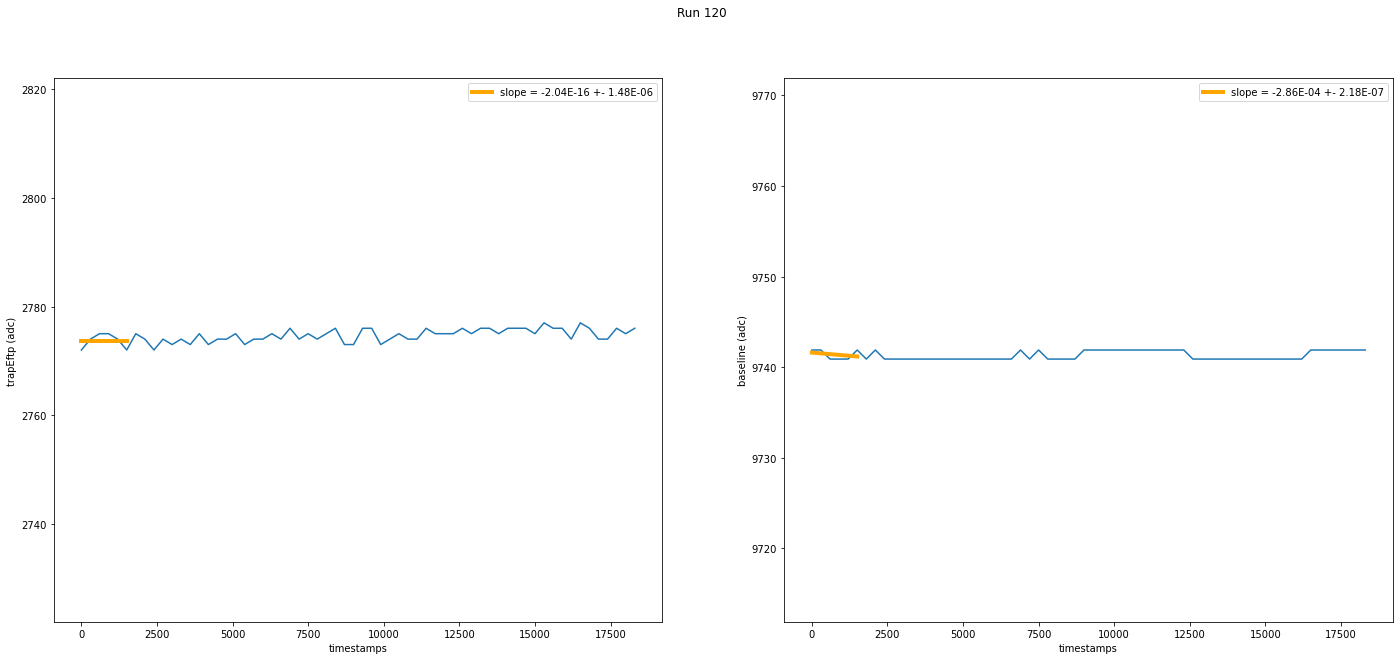


1460:  6.857142857143469 6.706817796740692
Baseline:  0.5142857142878297 2.9968992239776235


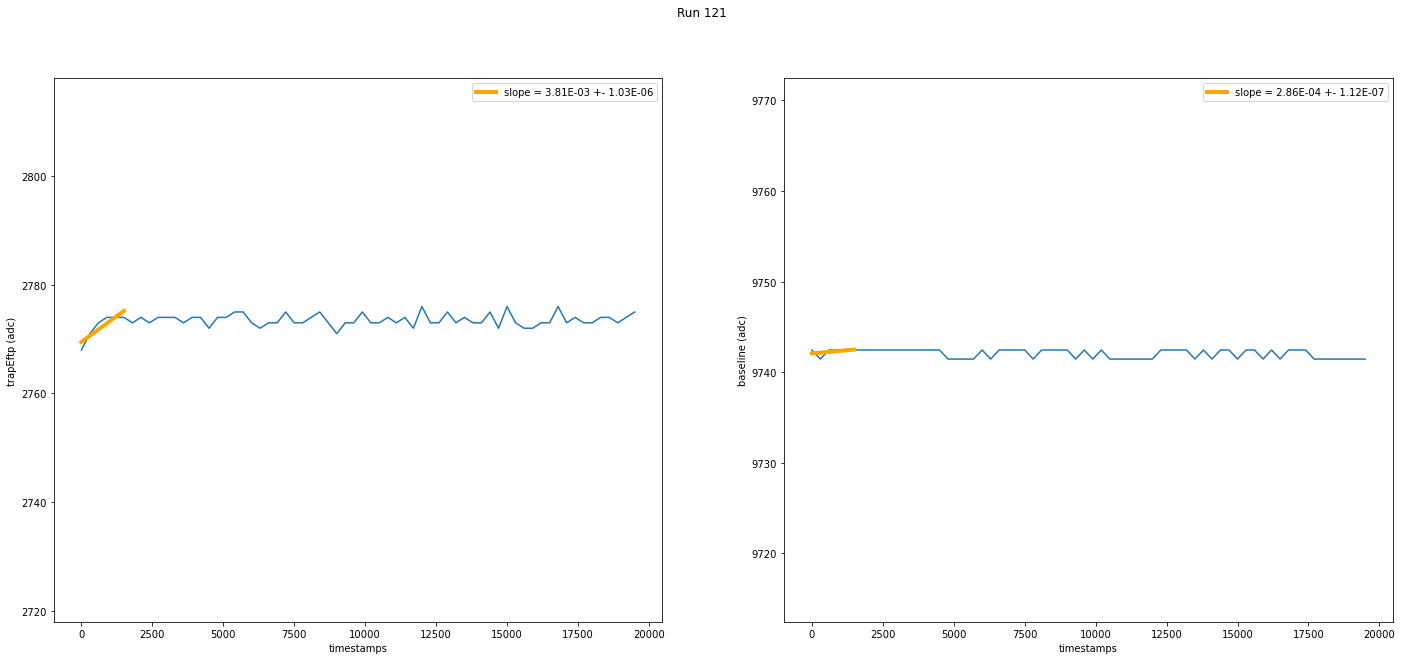

(121, (0.0038095238095241495, 2769.476190476189, 1.0279667422526216e-06), (0.0002857142857154609, 9742.079985119042, 1.1186696900997823e-07))


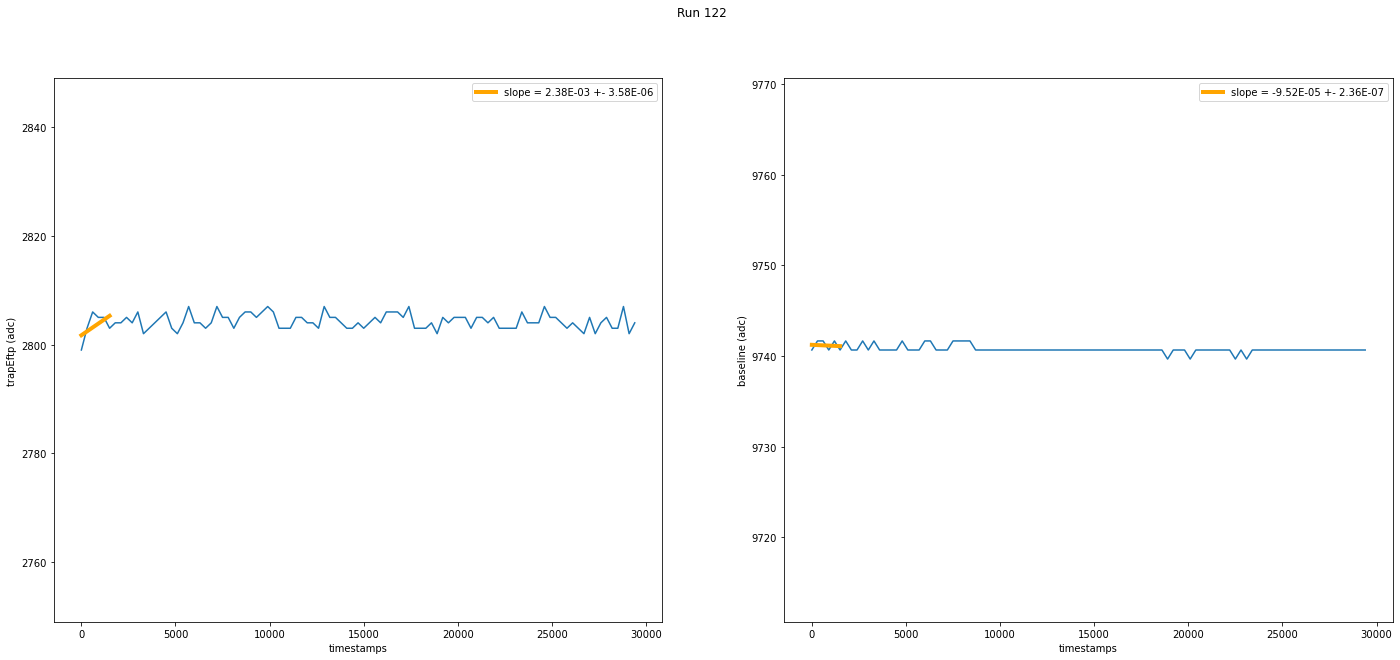

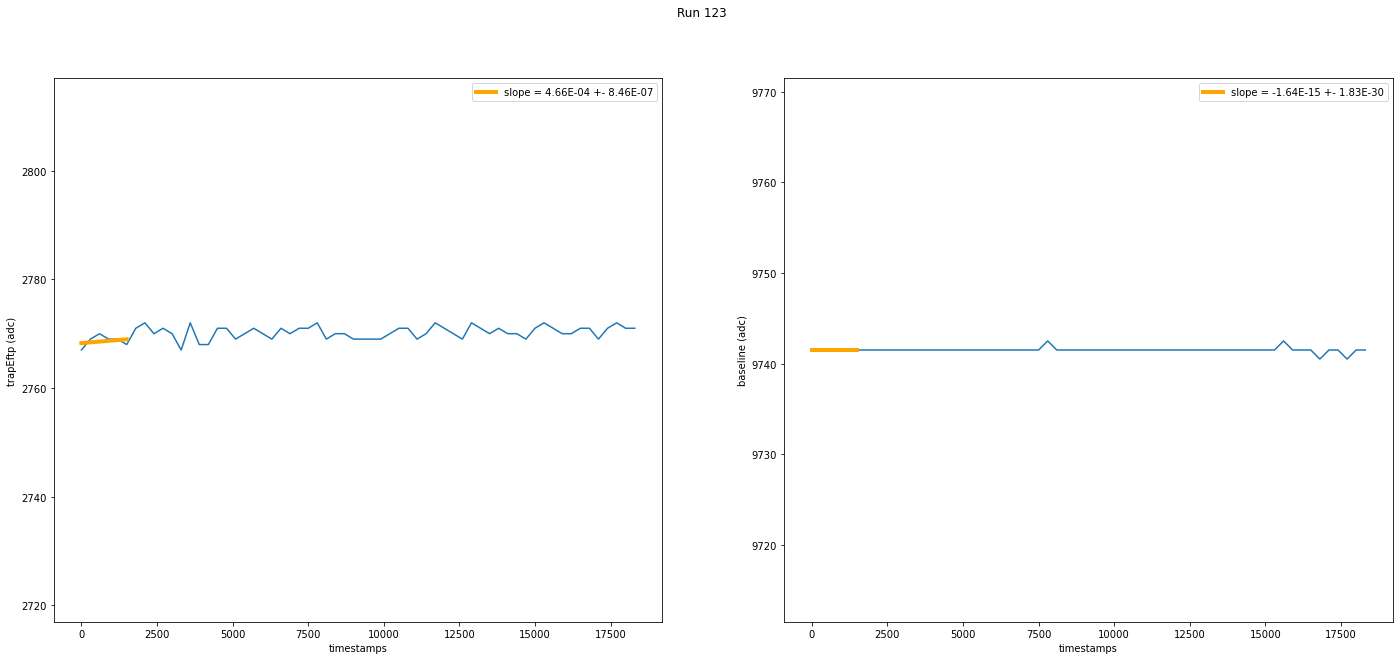

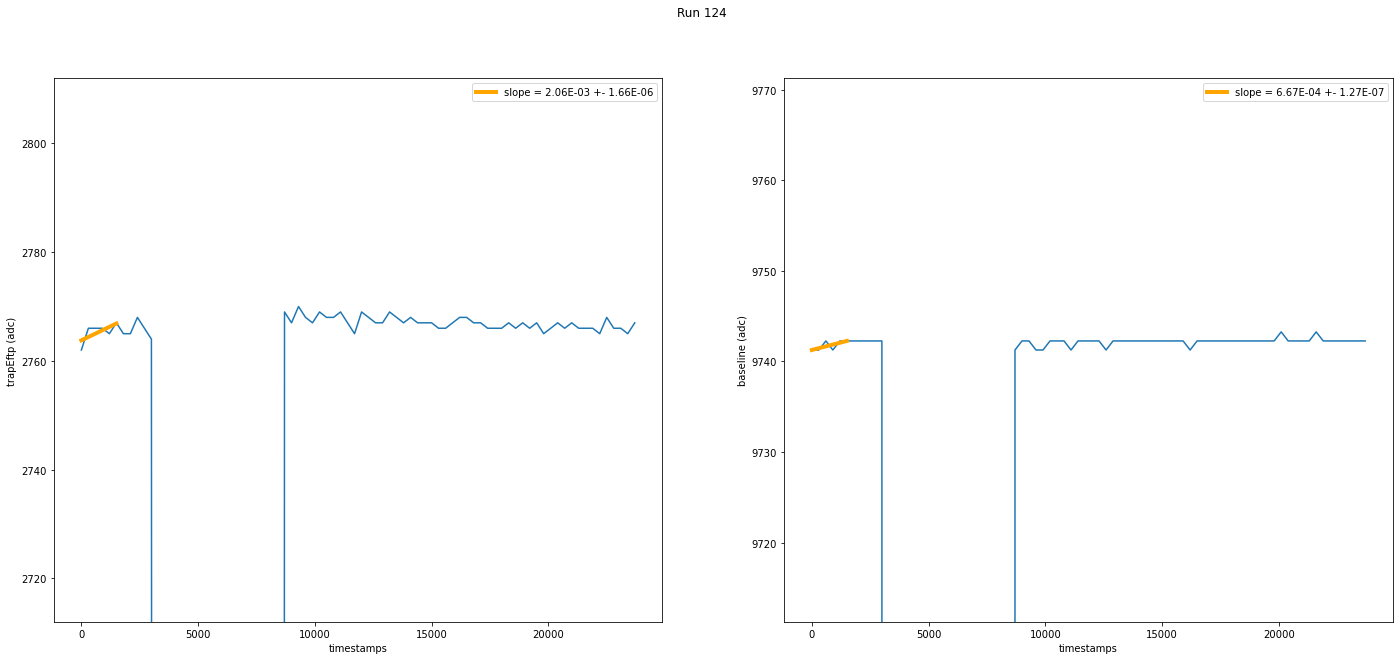


1460:  4.804912280701505 7.794228634059948
Baseline:  2.7333333333345182 2.598076211353316


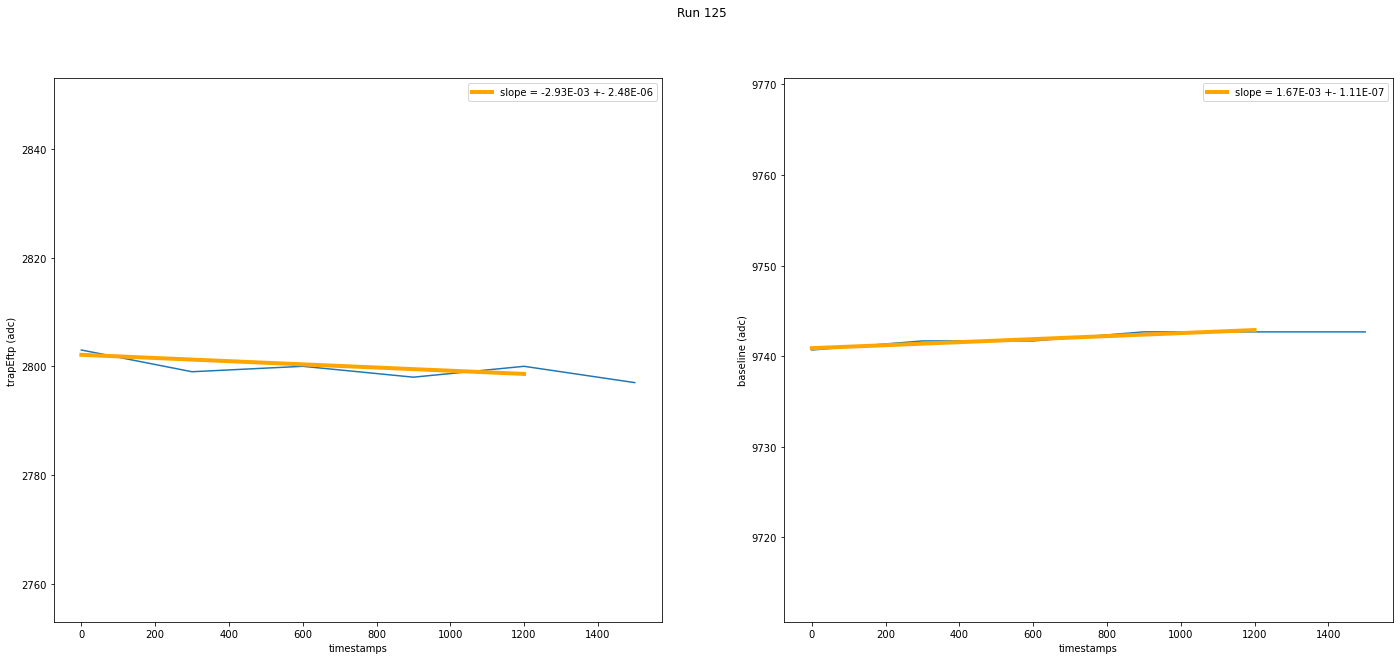

(125, (-0.0029298245614033562, 2802.115789473684, 2.479839950753942e-06), (0.0016666666666673893, 9740.875781249993, 1.1111111111051415e-07))


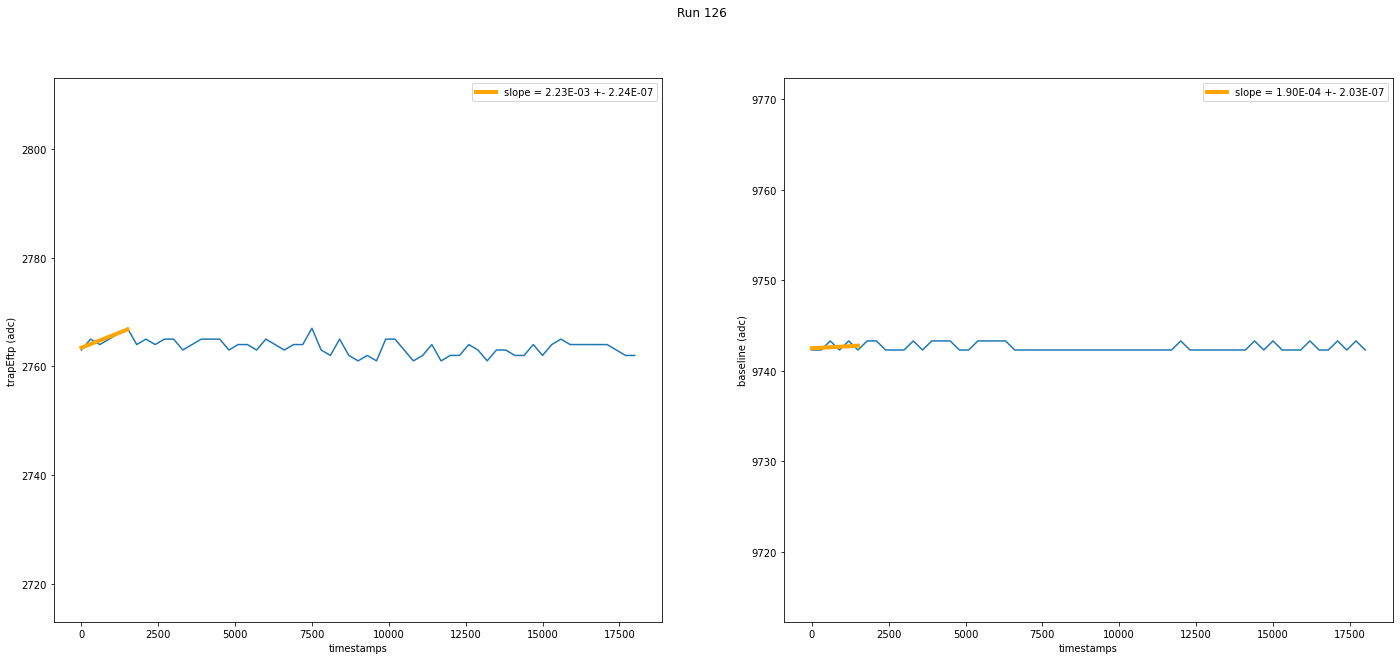

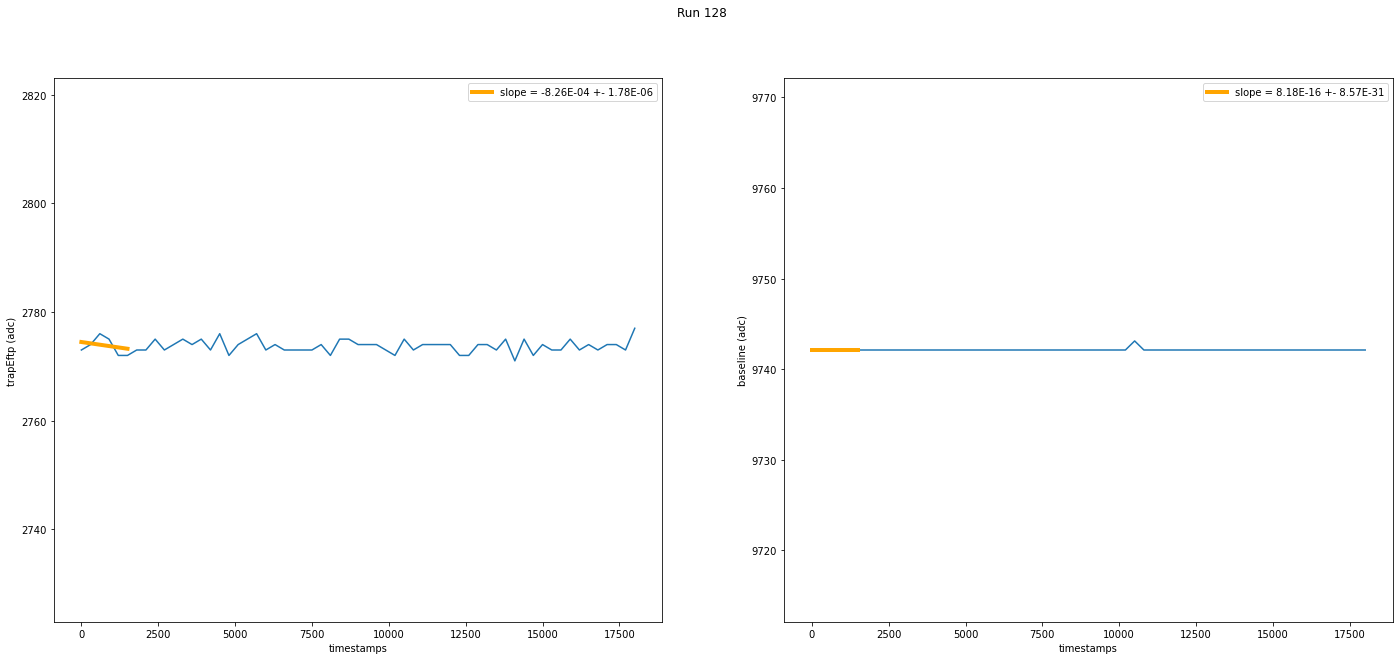

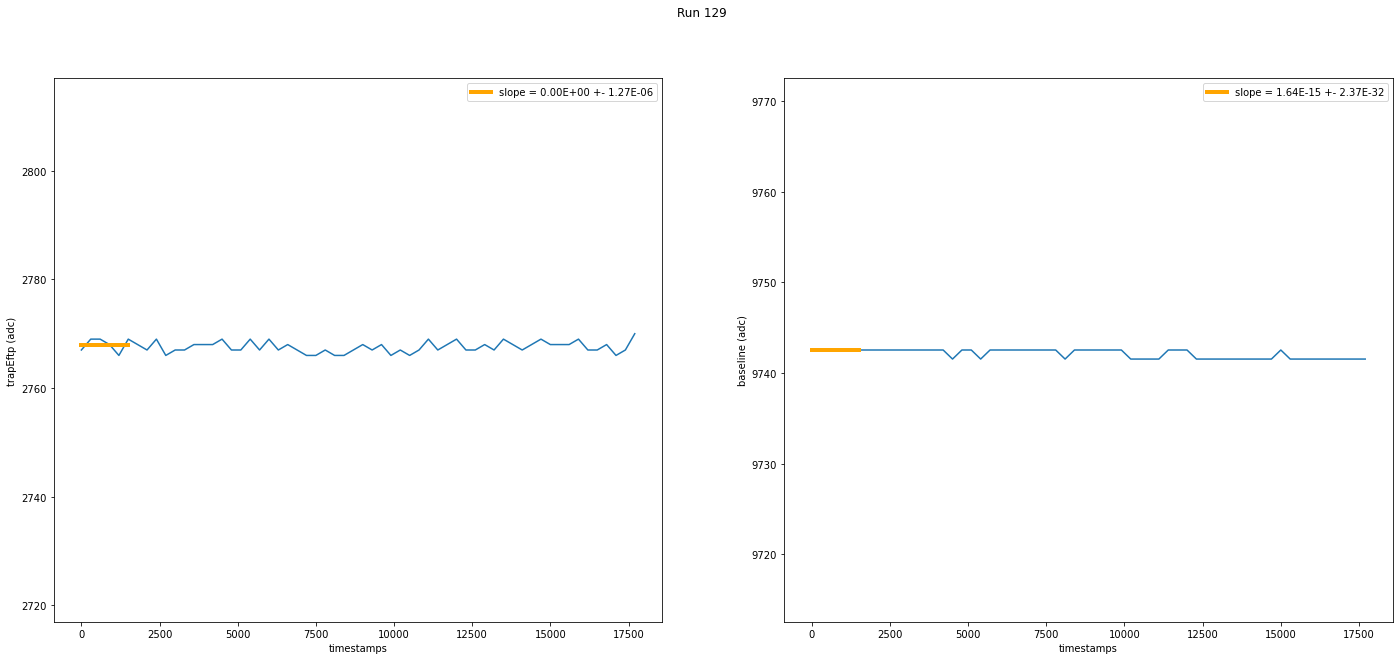

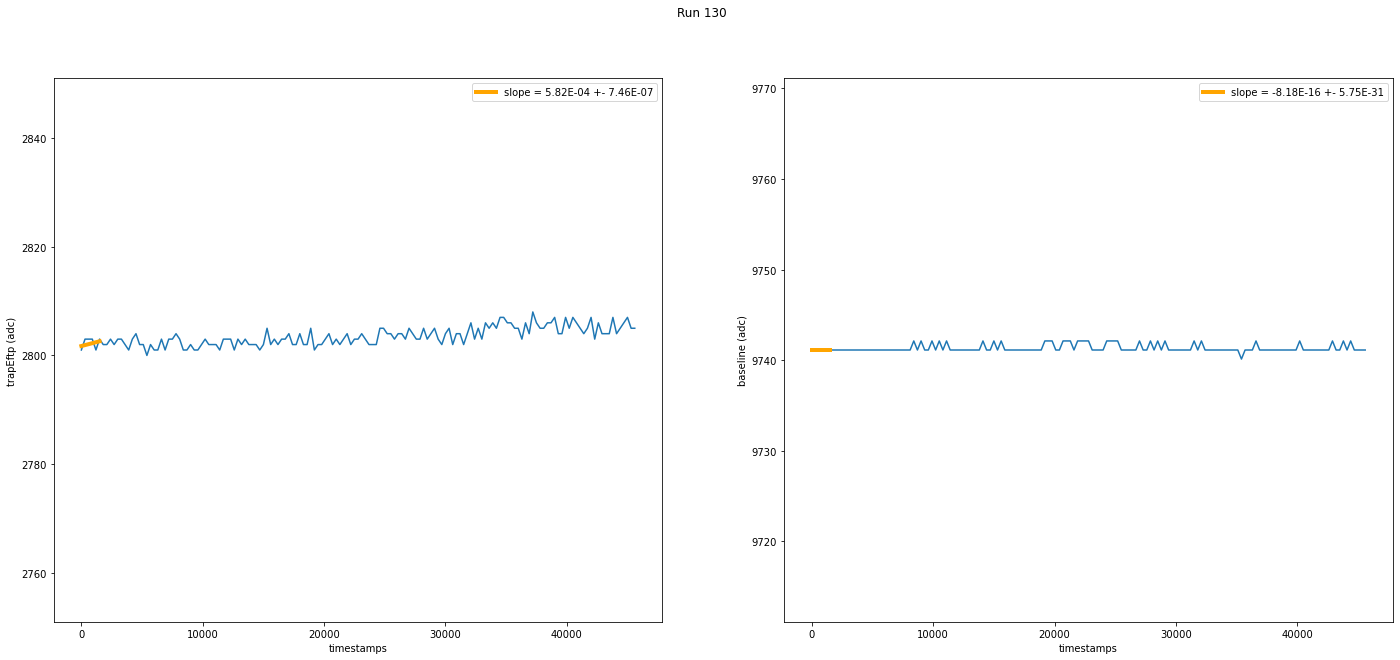

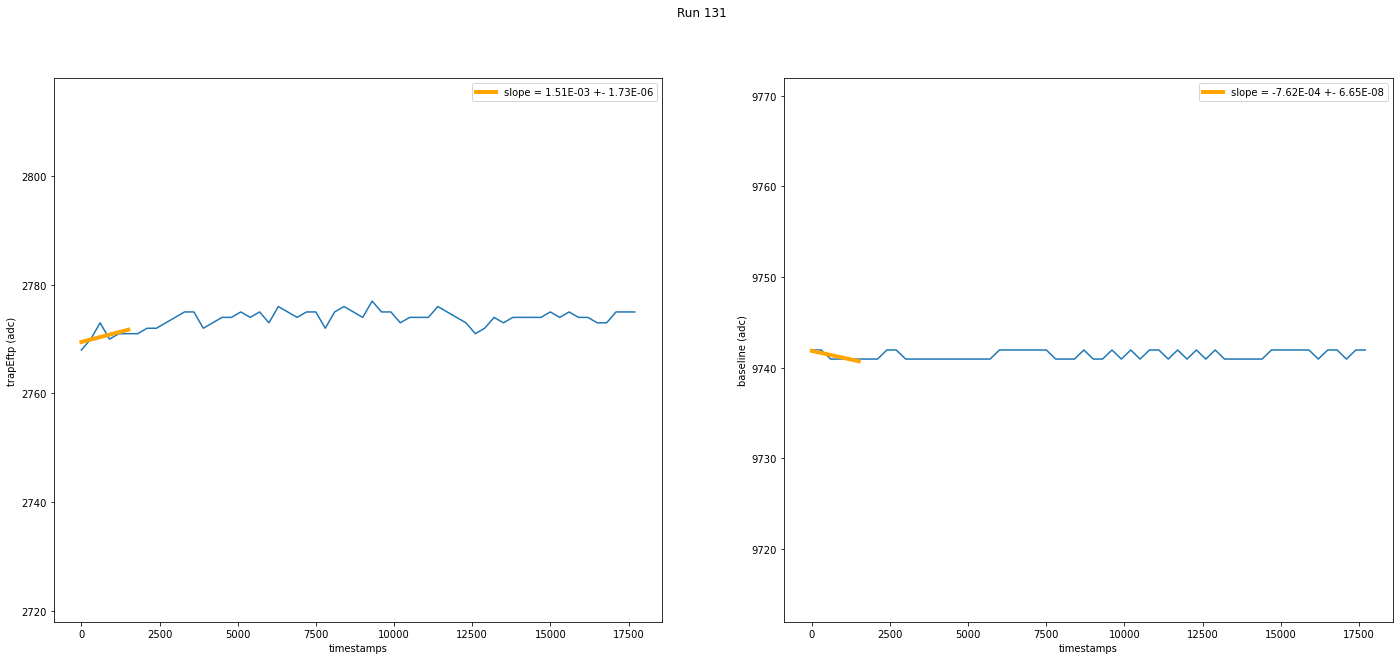

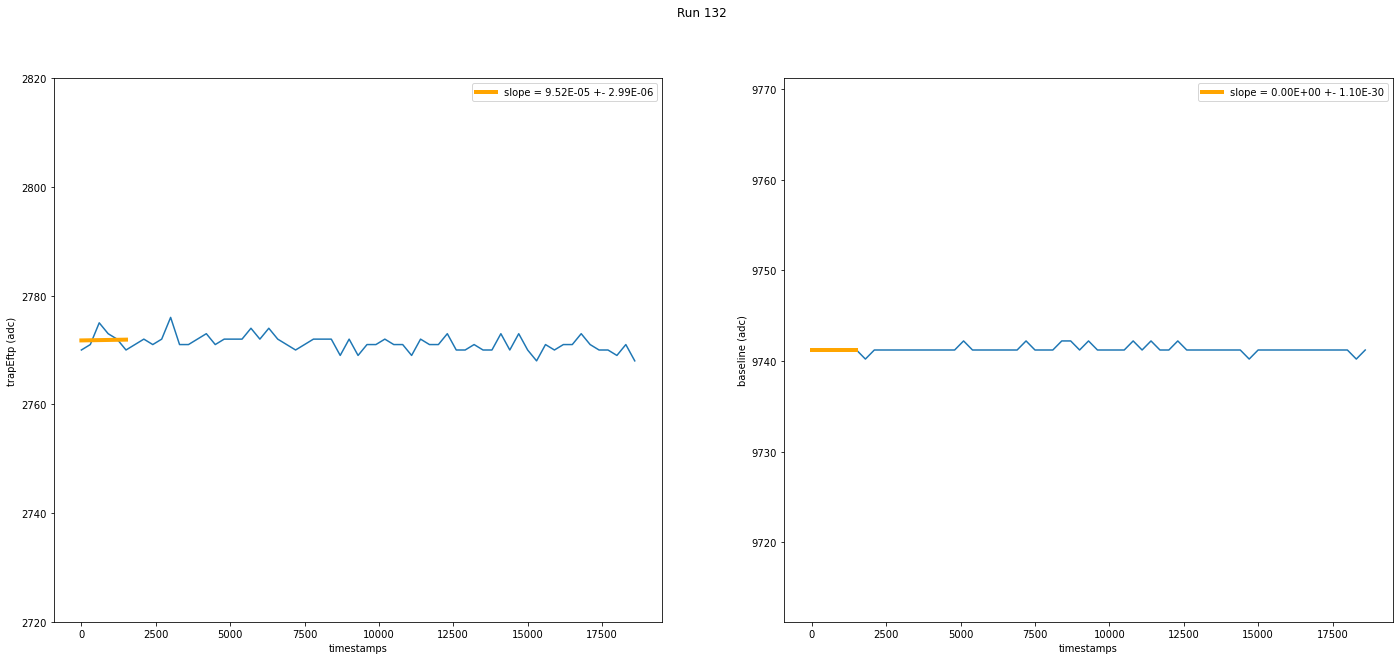

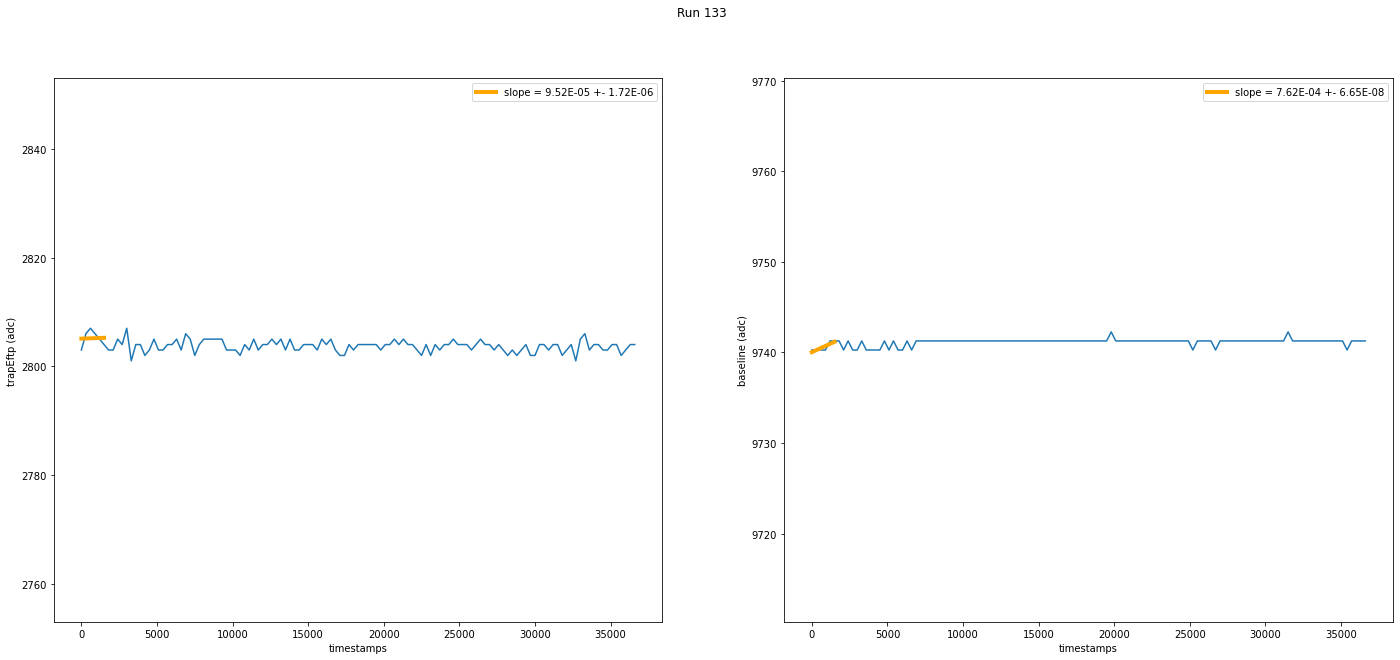

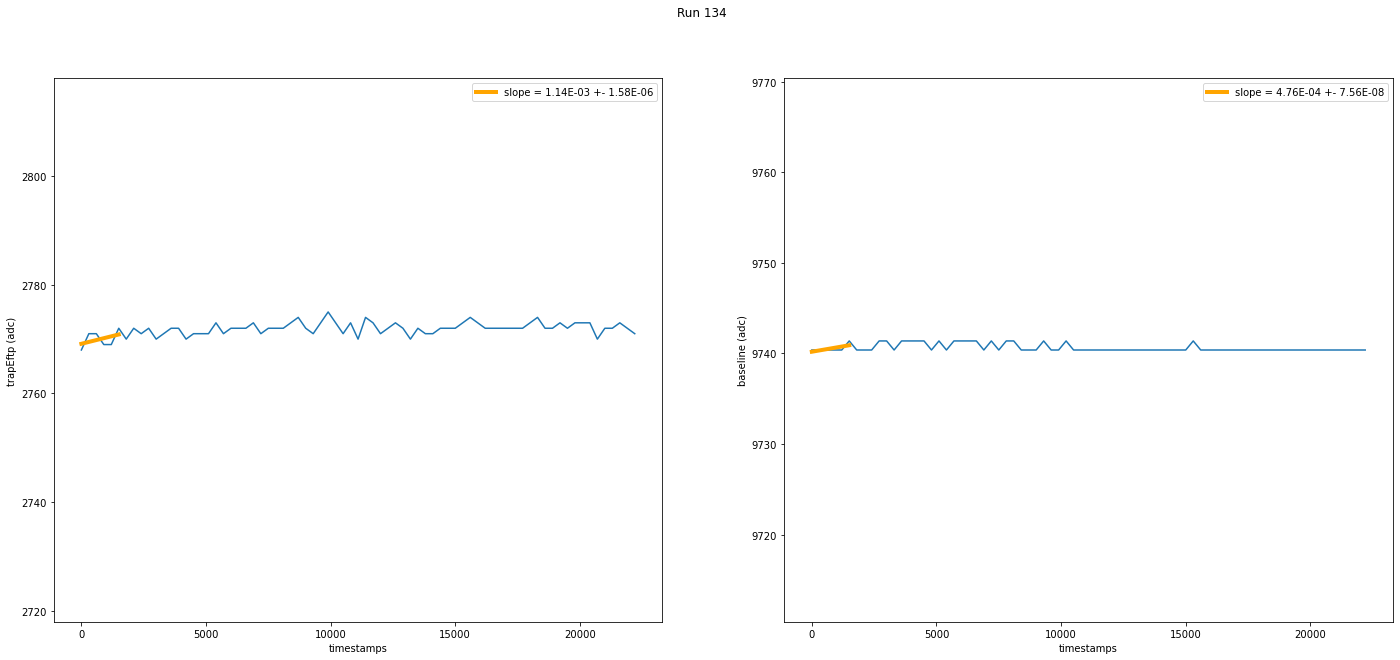

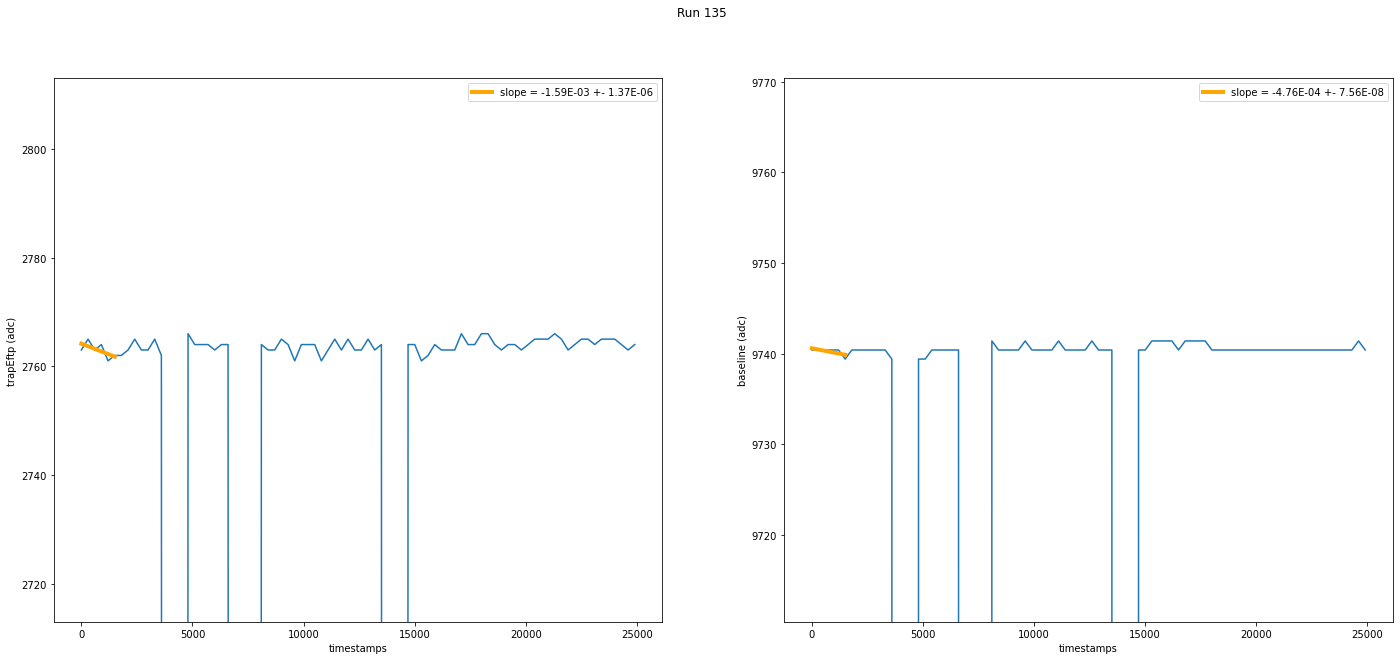

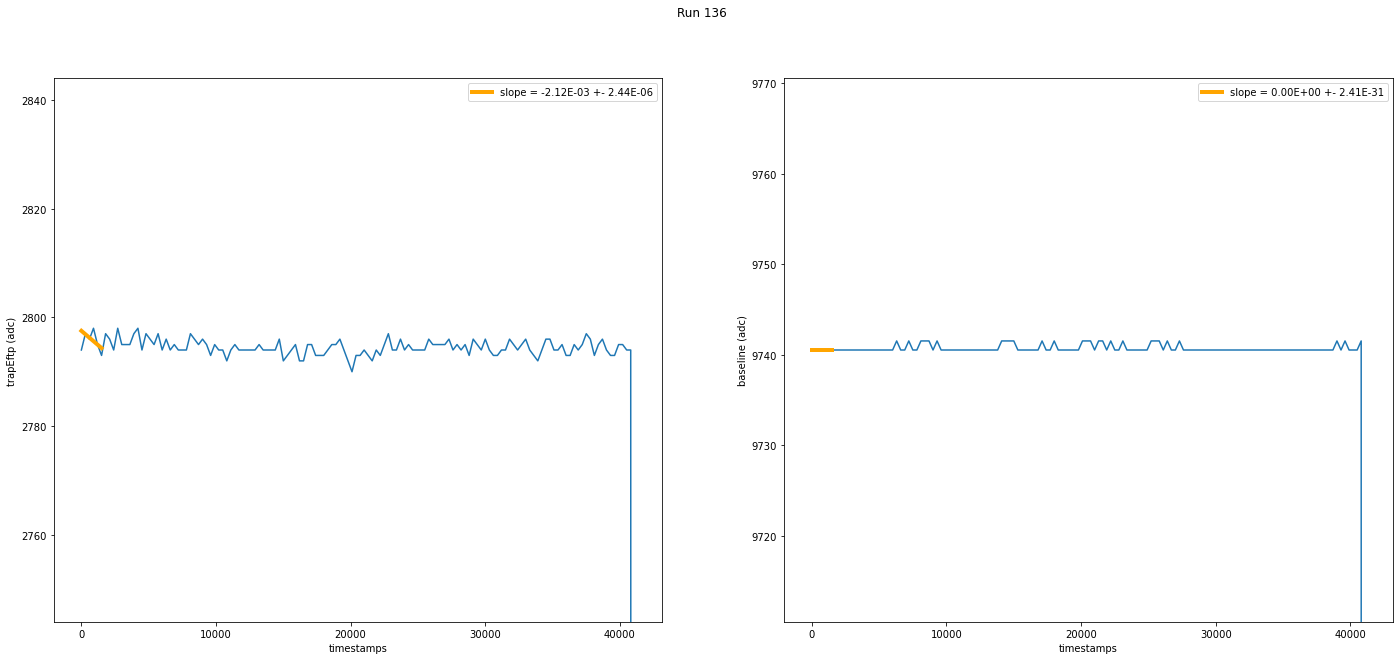


1460:  7.910614525140625 7.814755274479169
Baseline:  2.9432697736625072e-12 2.7495454169735036


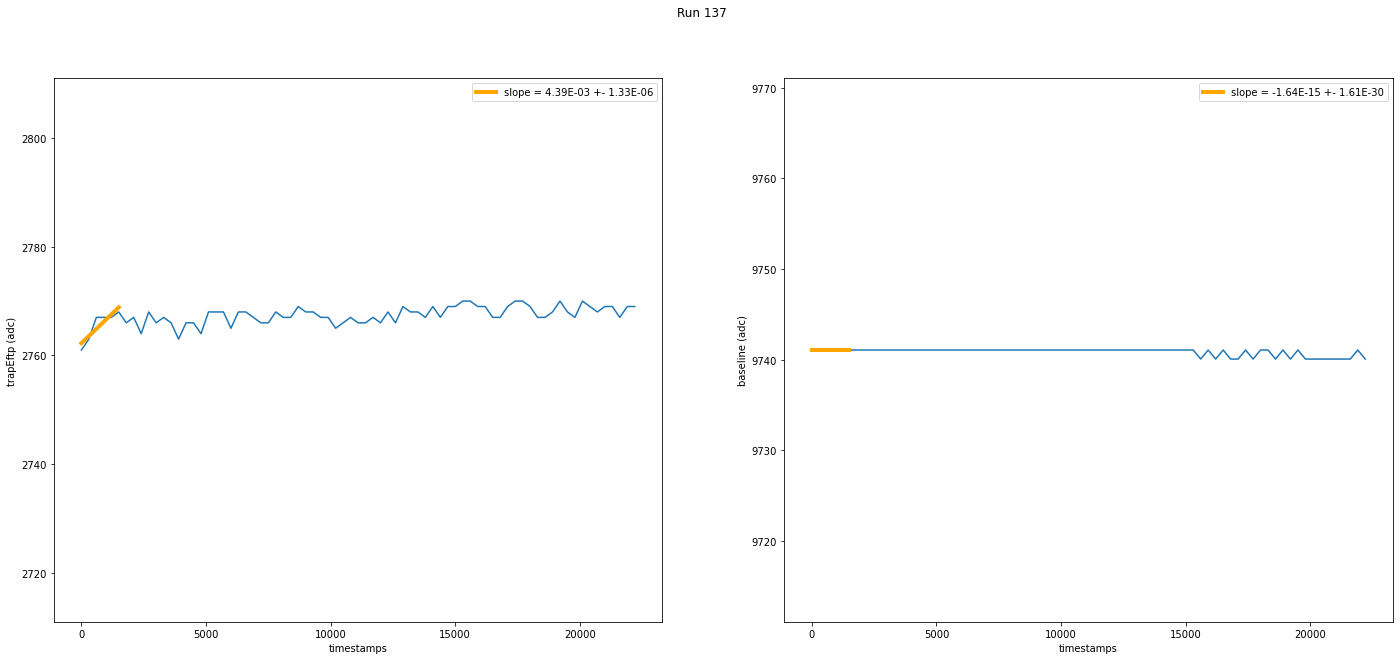

(137, (0.004394785847300347, 2762.2513966480437, 1.332234047349332e-06), (-1.6351498742569484e-15, 9741.049804687495, 1.606440103309737e-30))
1460:  78.58400000000165 8.874119674649425
Baseline:  1.7859999999976113 3.0


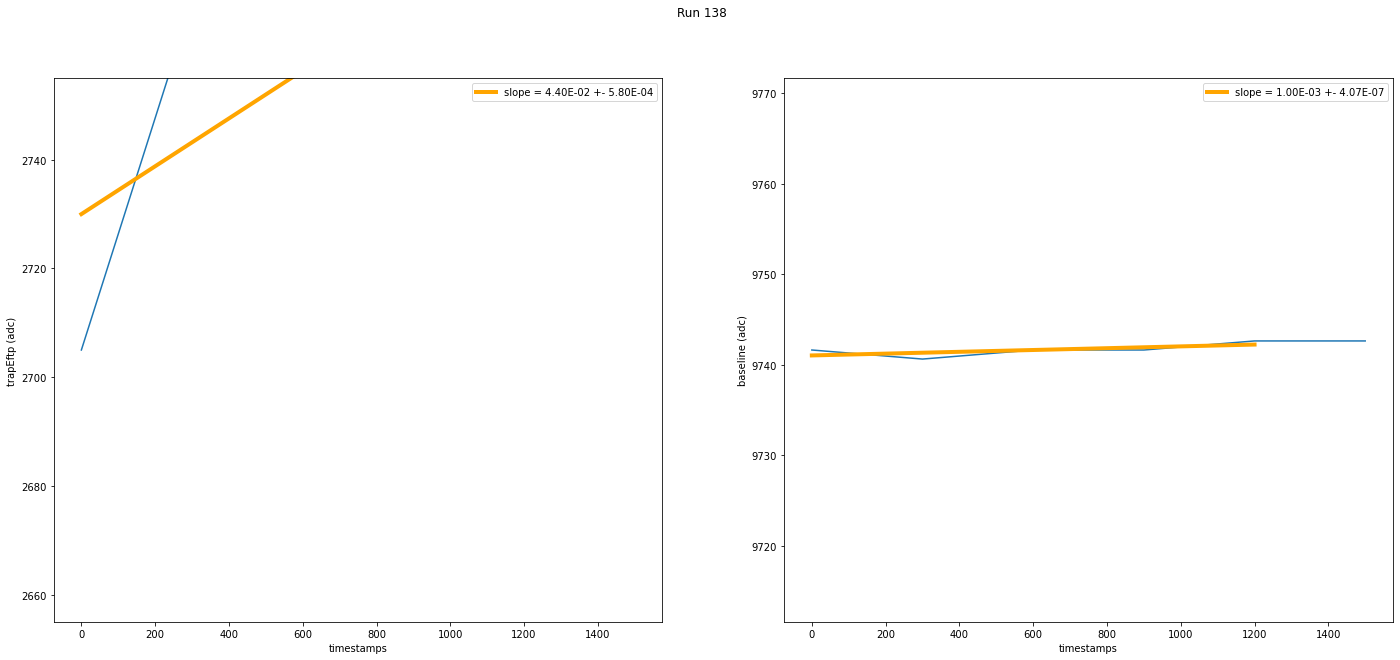

(138, (0.04400000000000092, 2729.9999999999977, 0.0005795555555555529), (0.0009999999999986625, 9741.041601562494, 4.0740740740803693e-07))


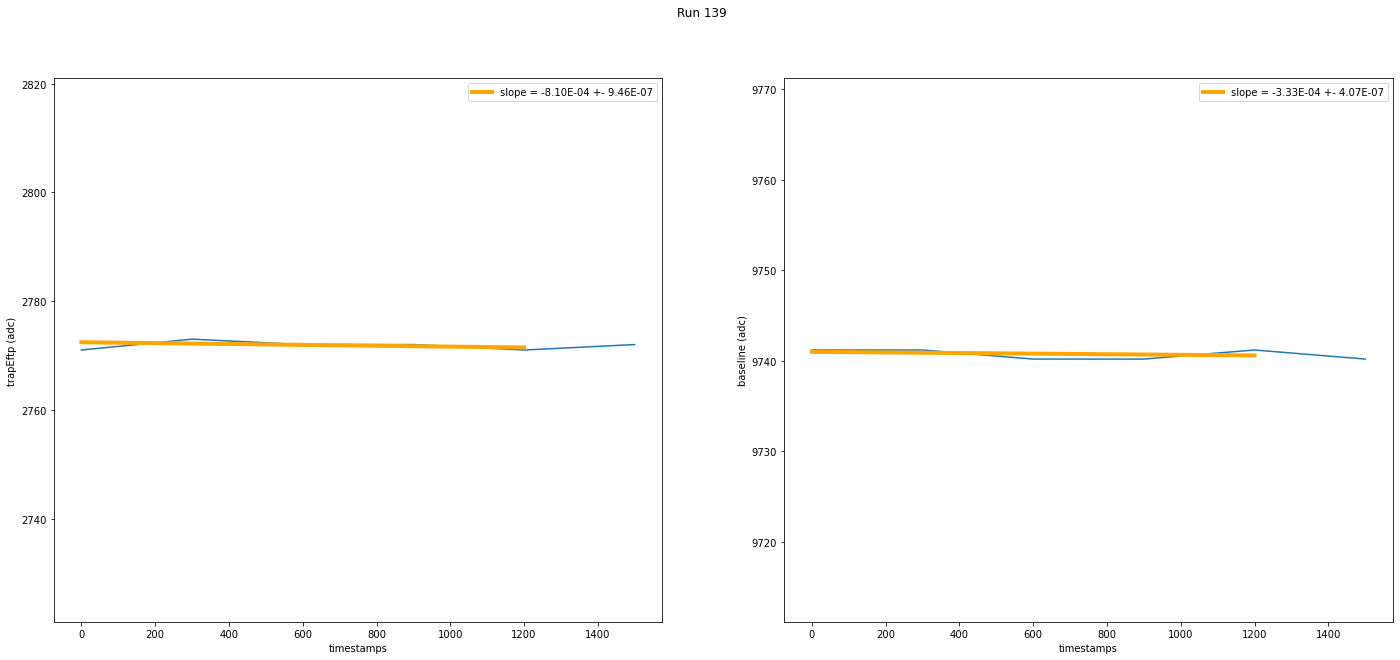

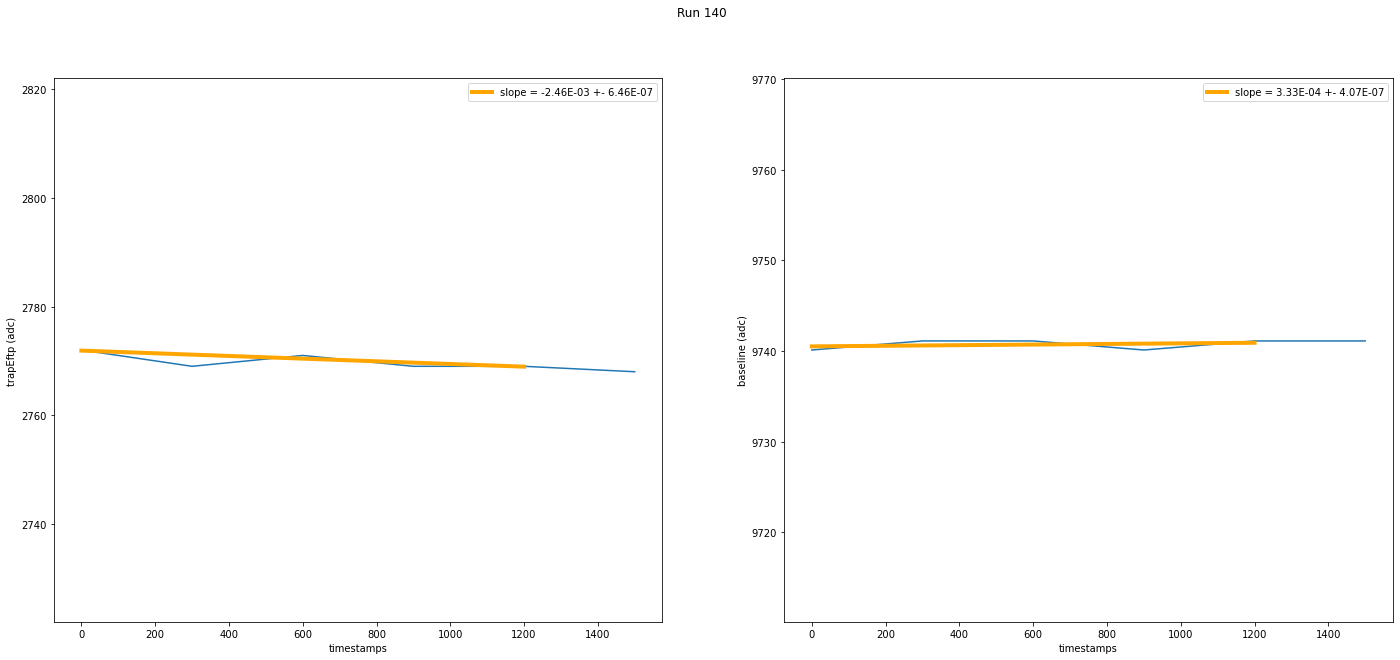

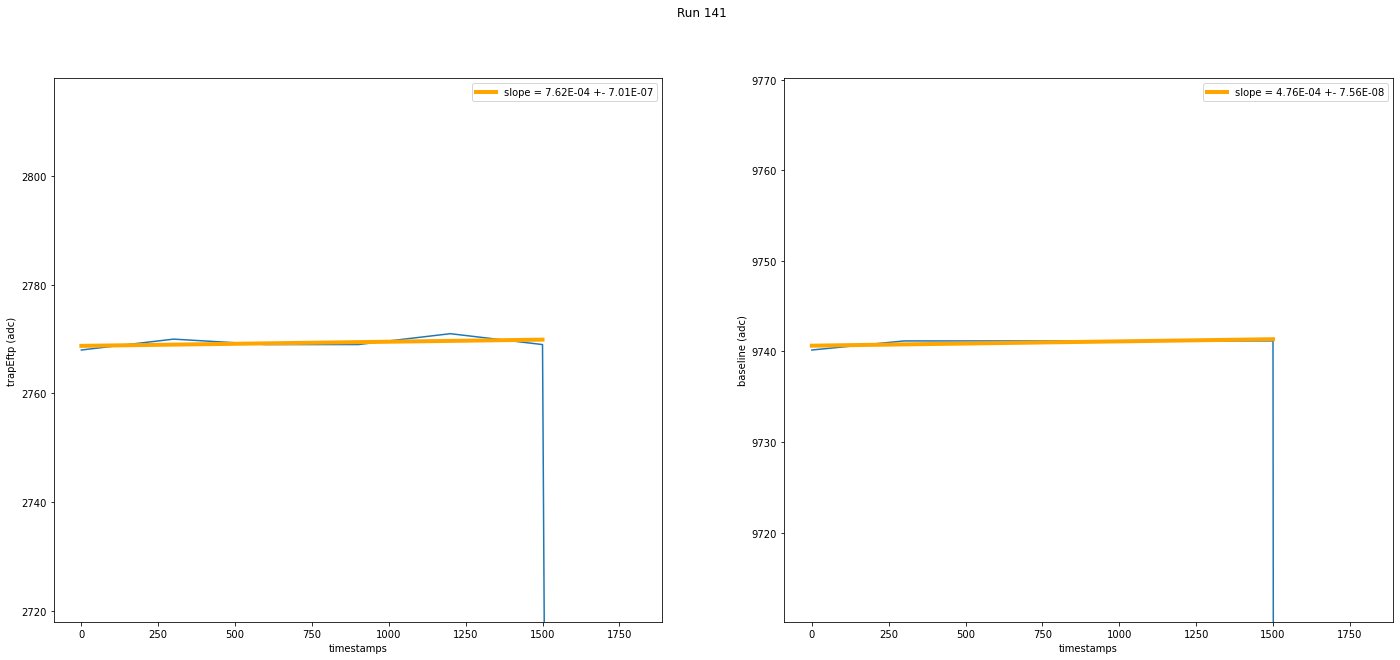

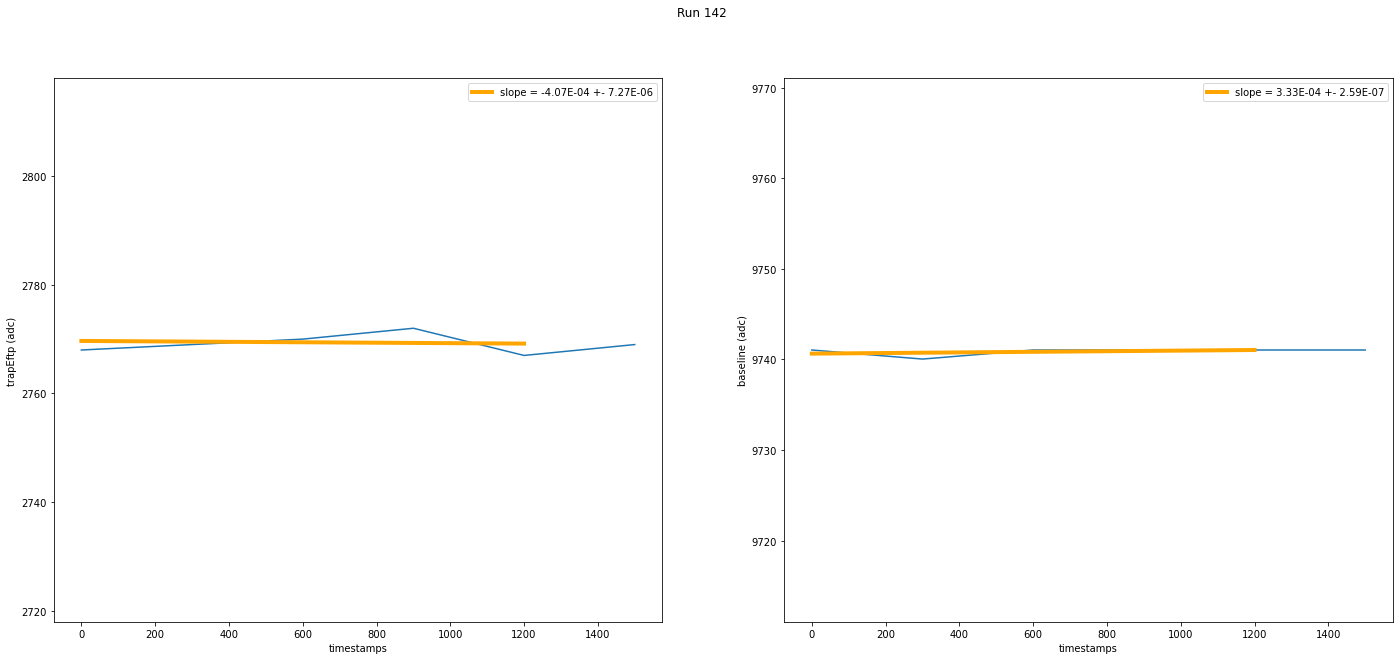


1460:  7.499999999998768 7.059577404922669
Baseline:  0.34285714285413826 2.6848688441075055


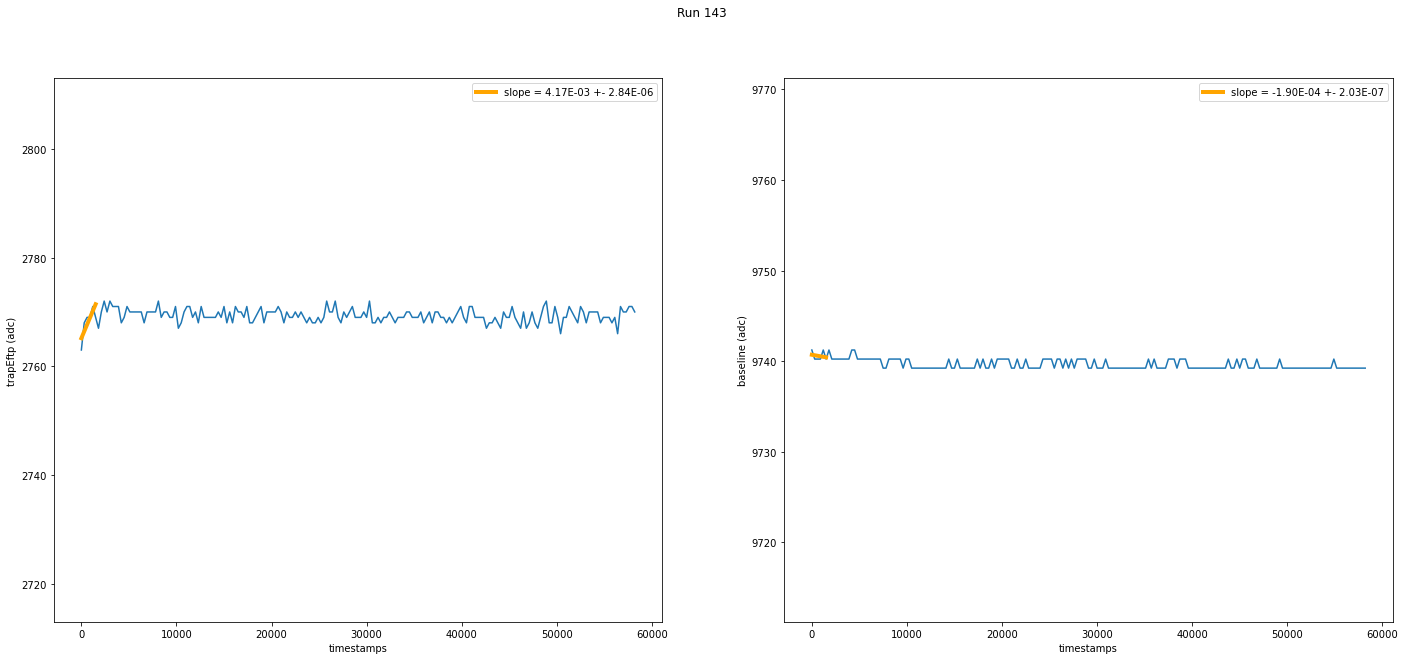

(143, (0.004166666666665982, 2765.166666666666, 2.8356481481497526e-06), (-0.00019047619047452124, 9740.708612351184, 2.025699168553695e-07))


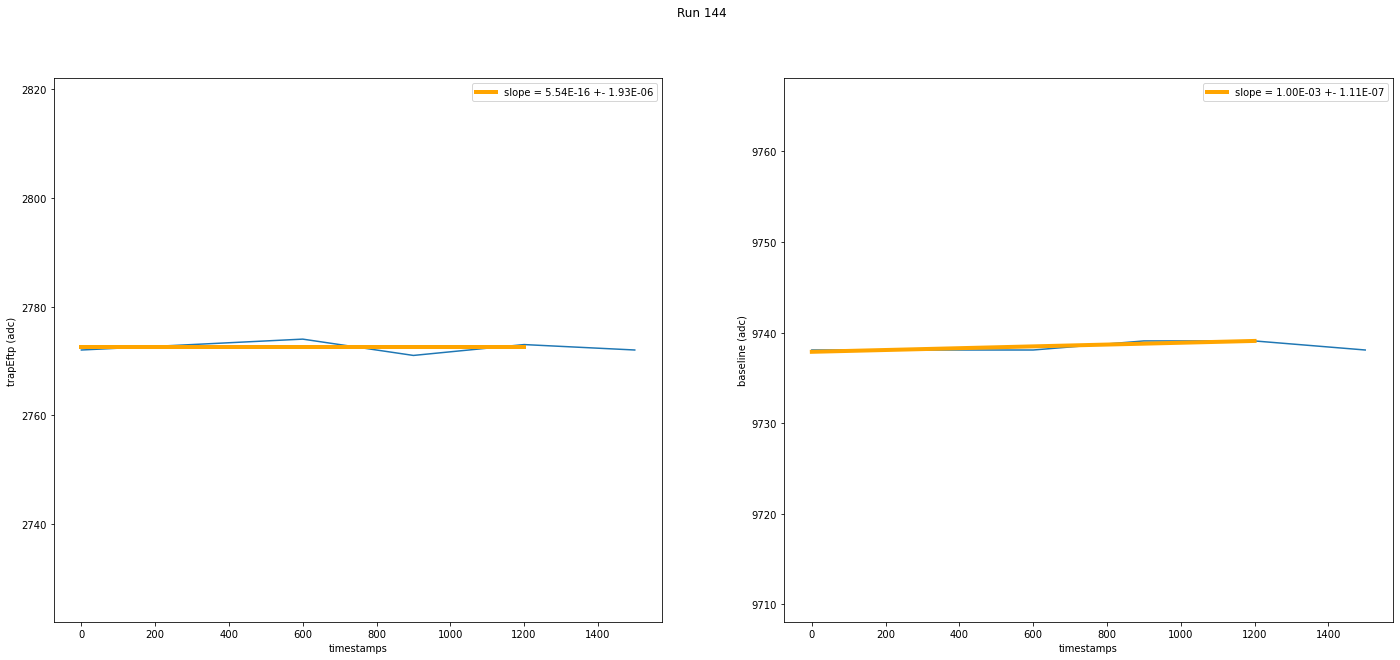

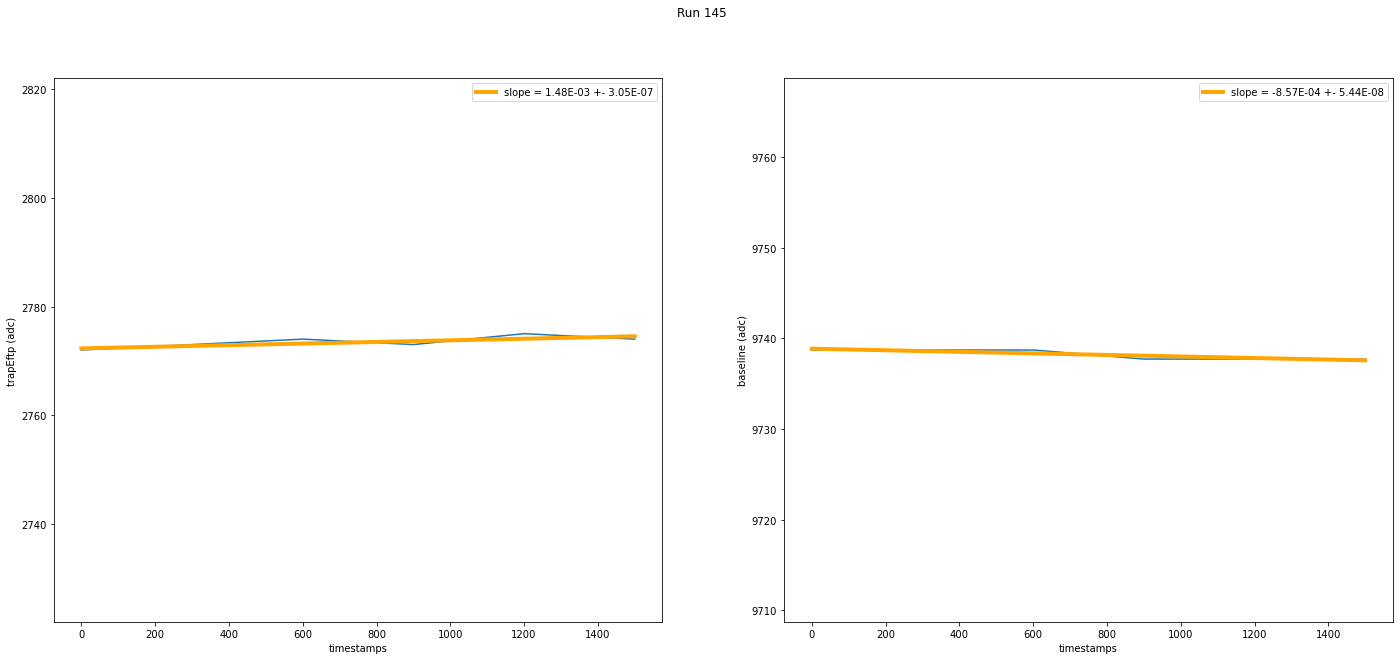

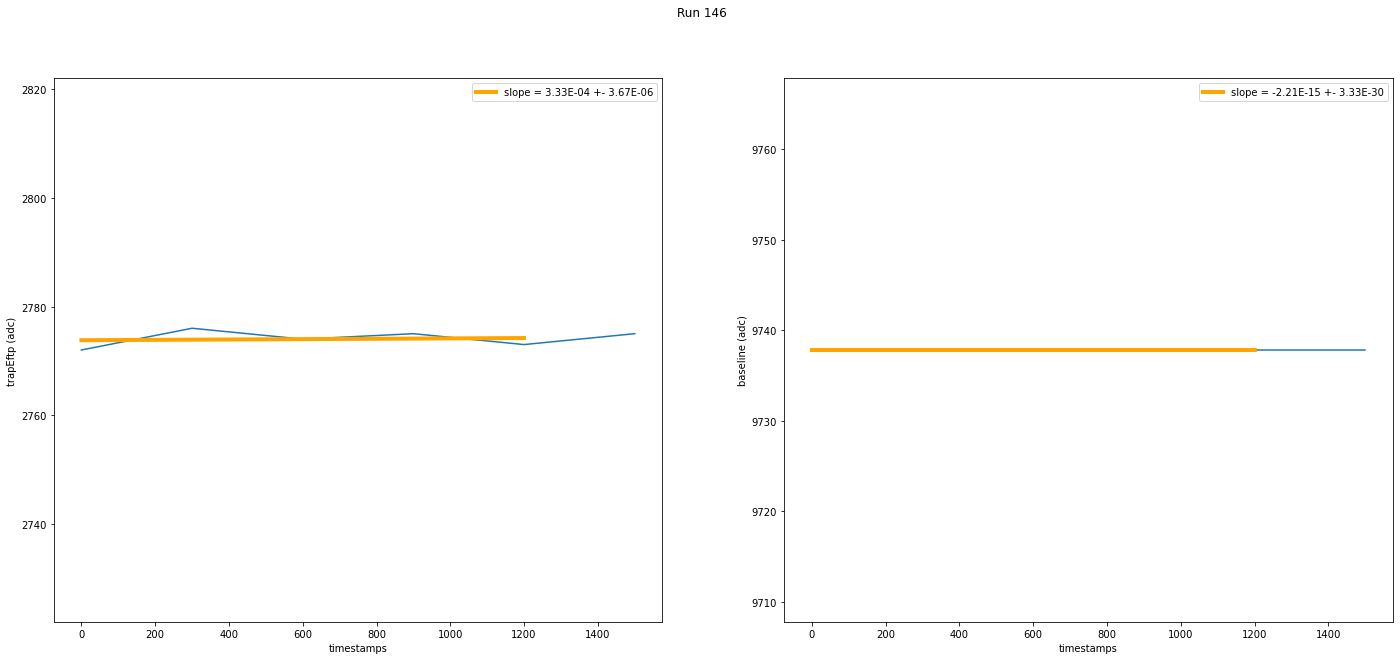

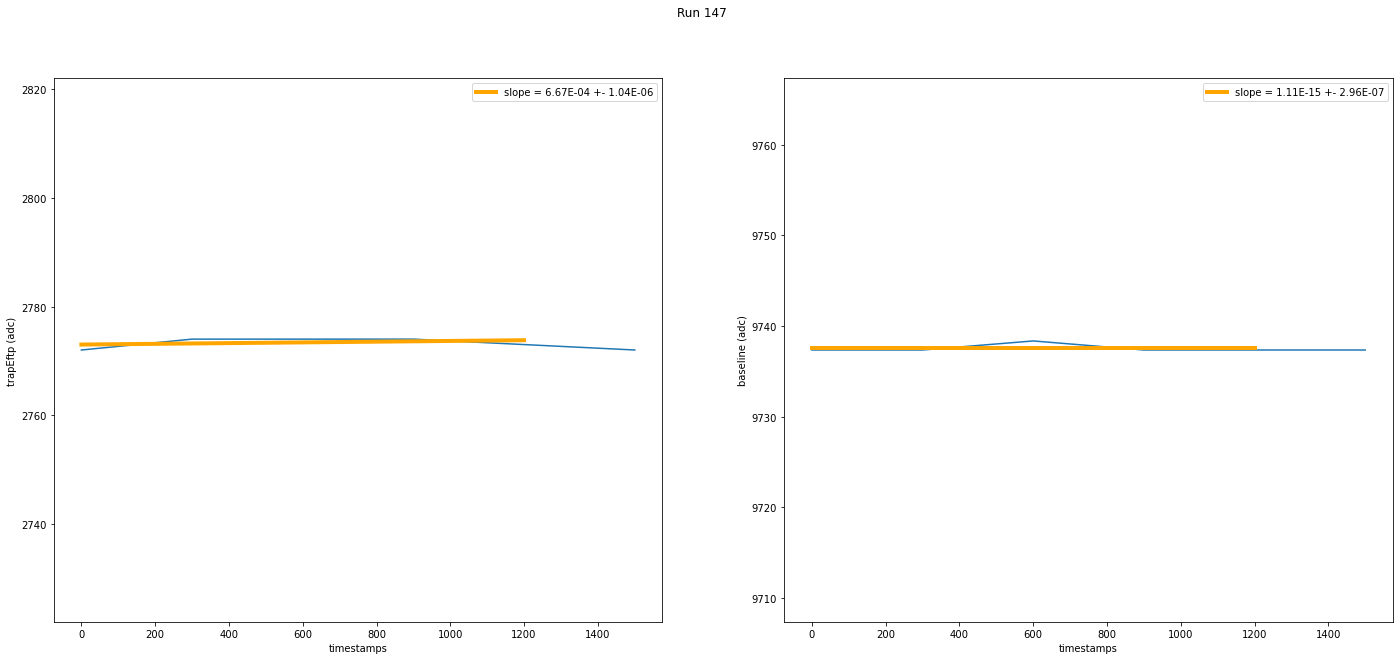

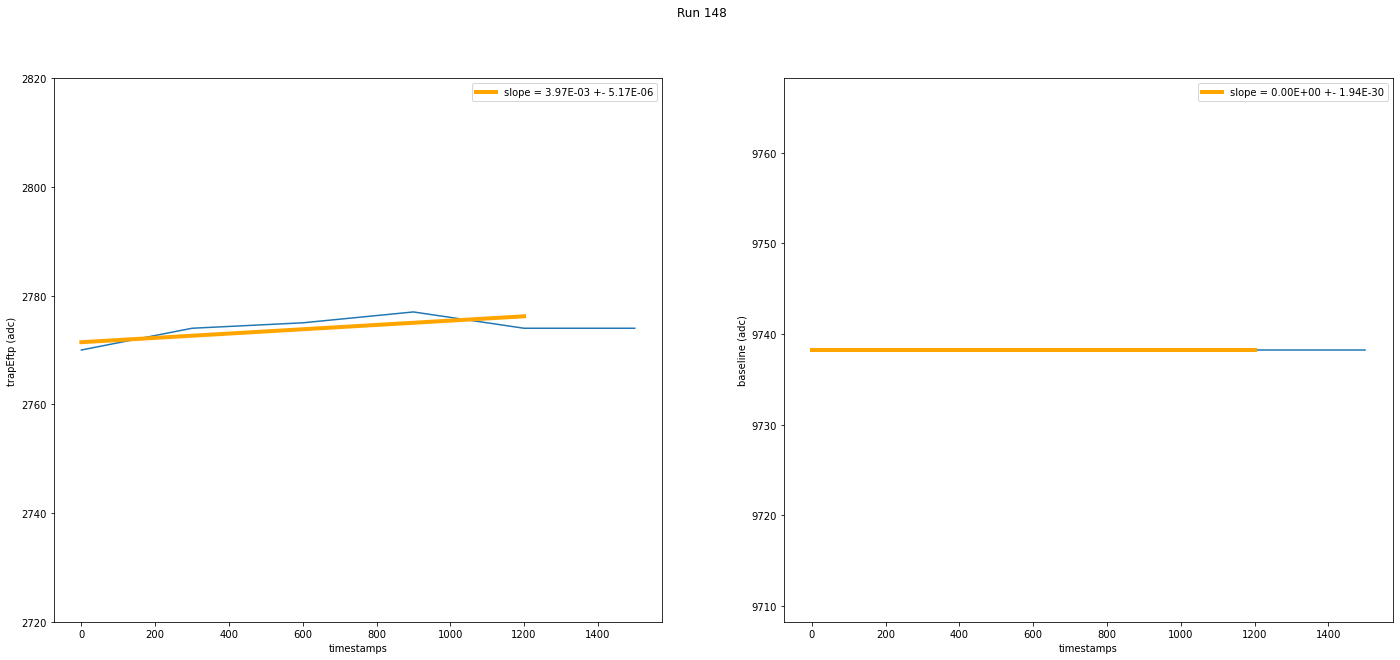

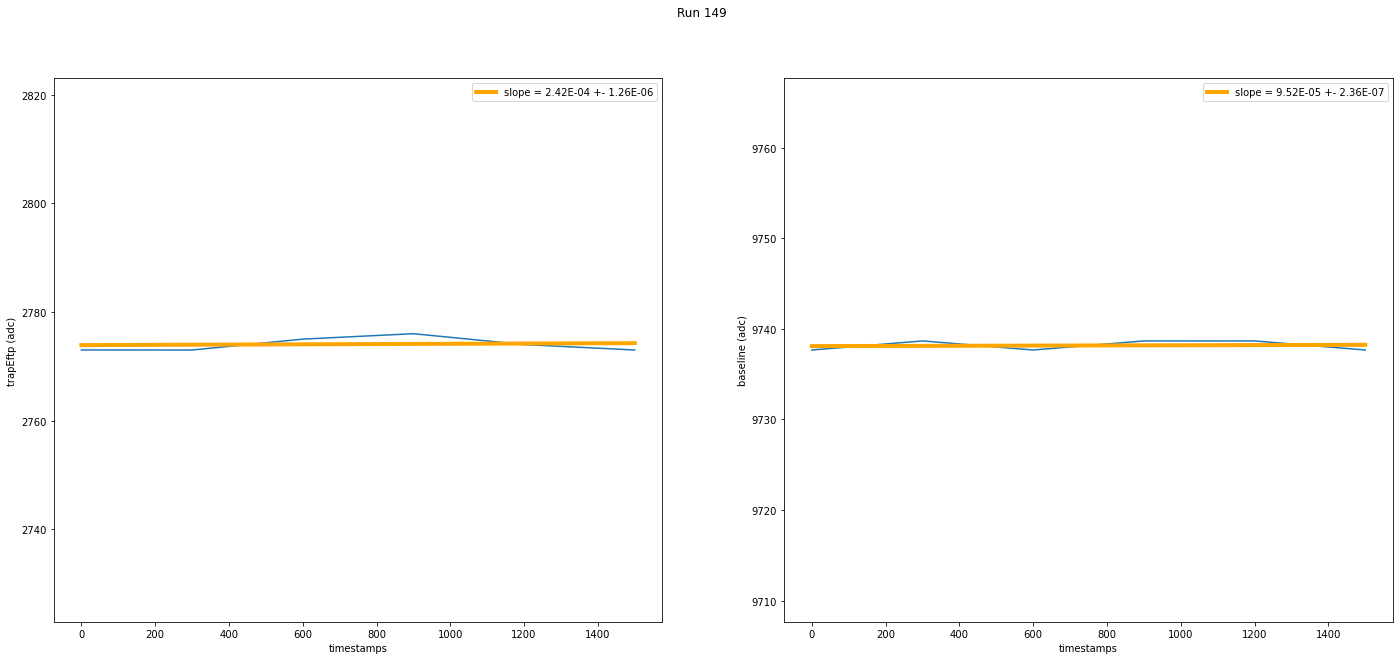

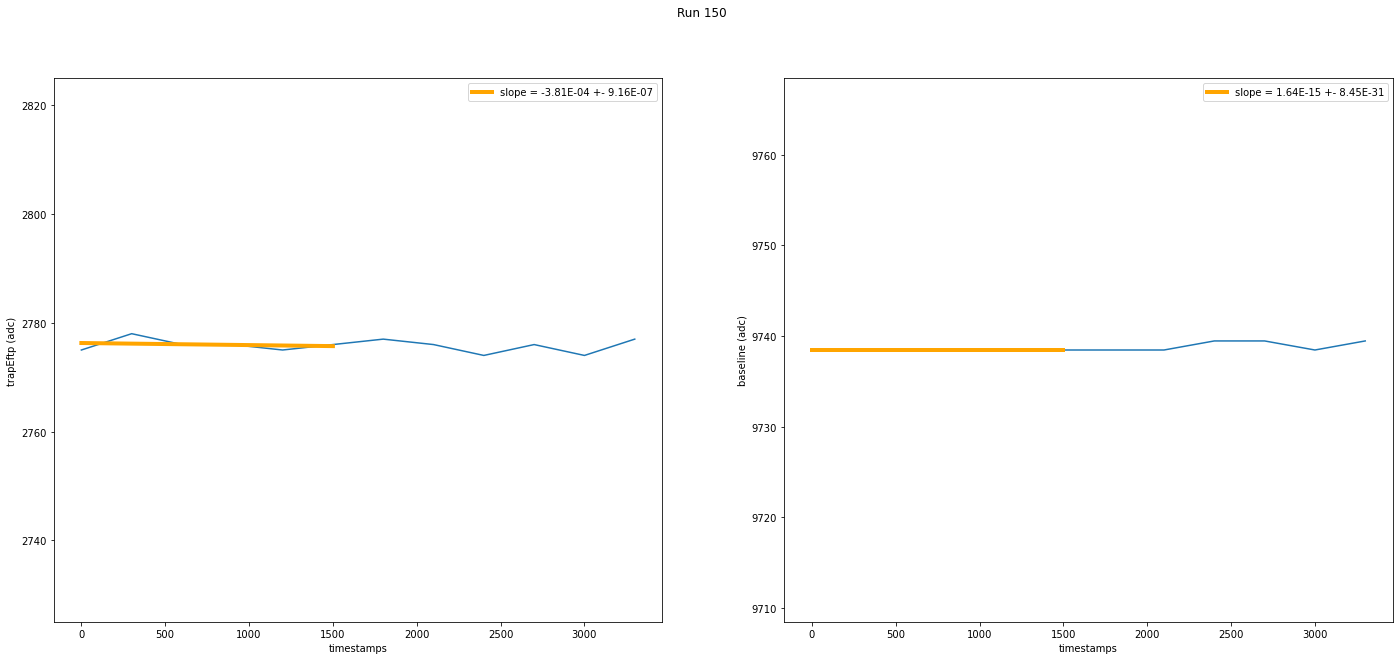

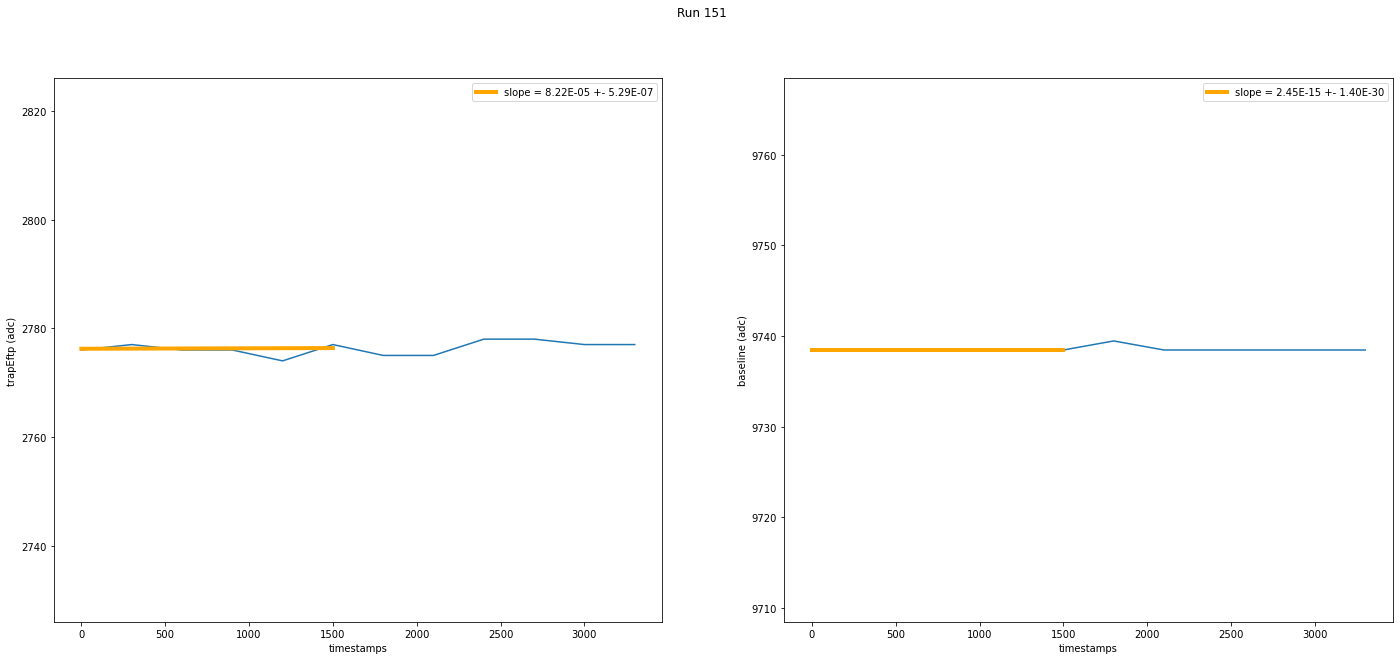

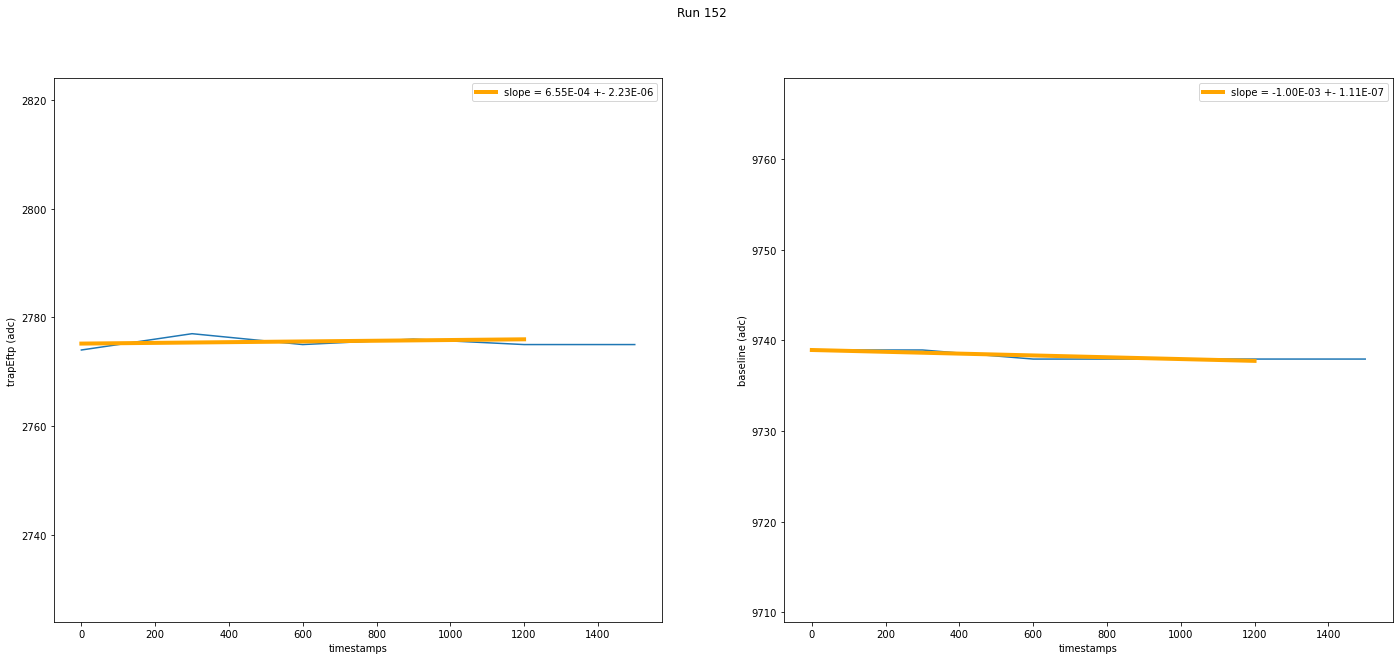

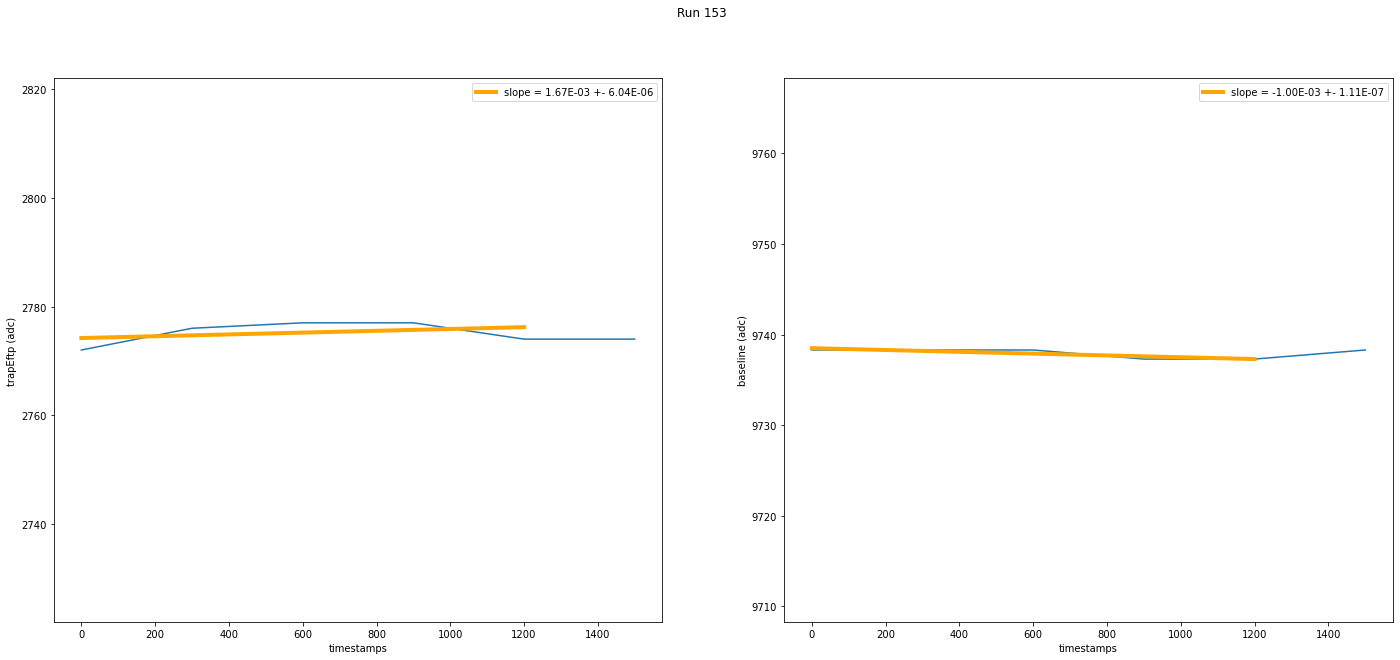

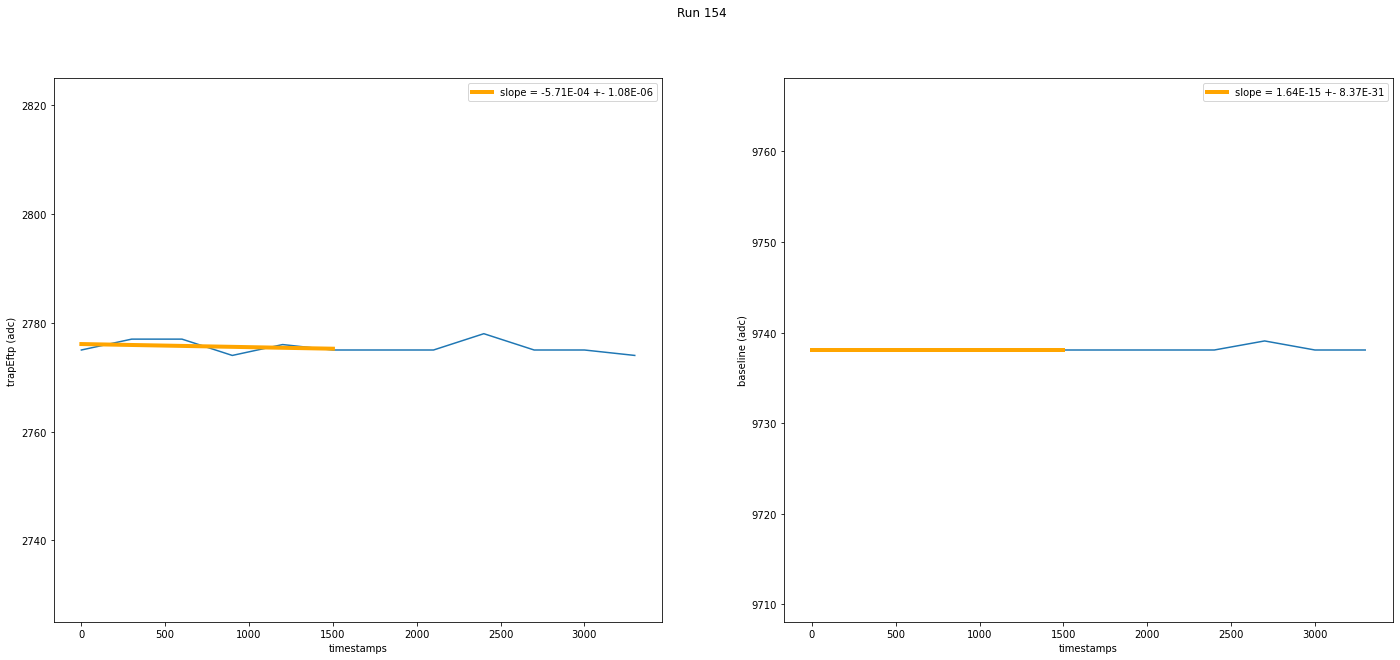

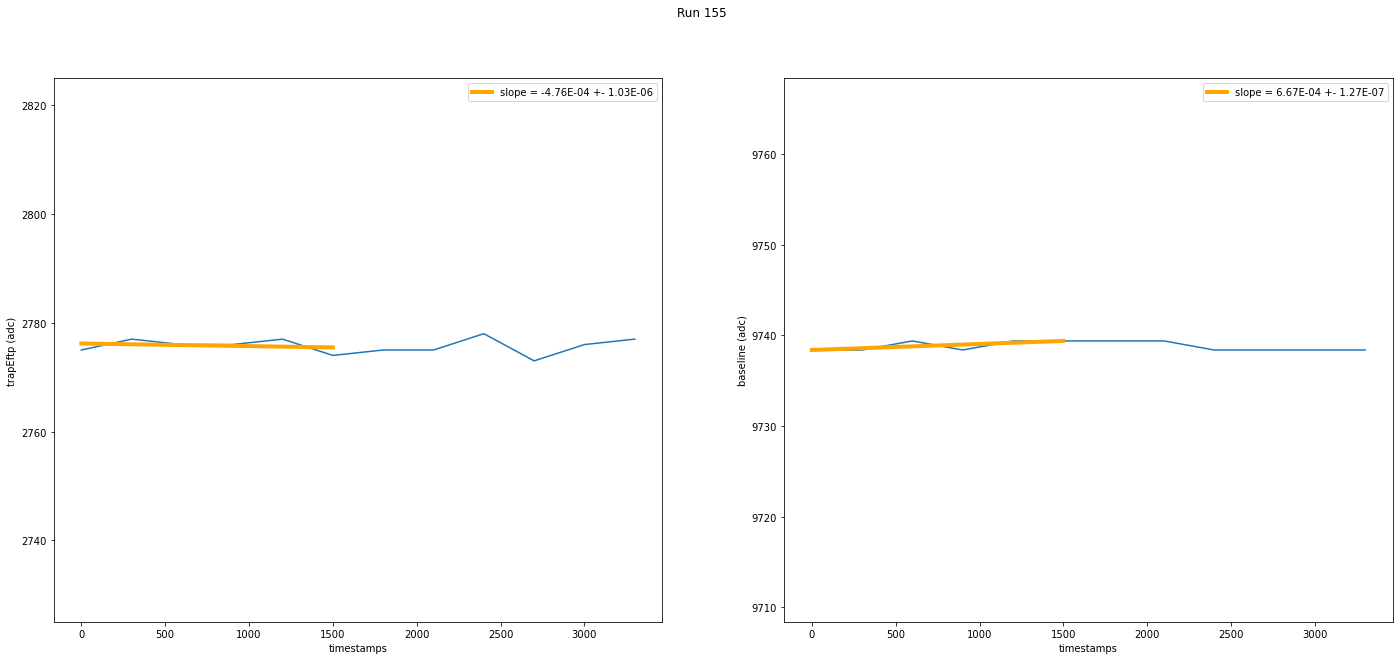

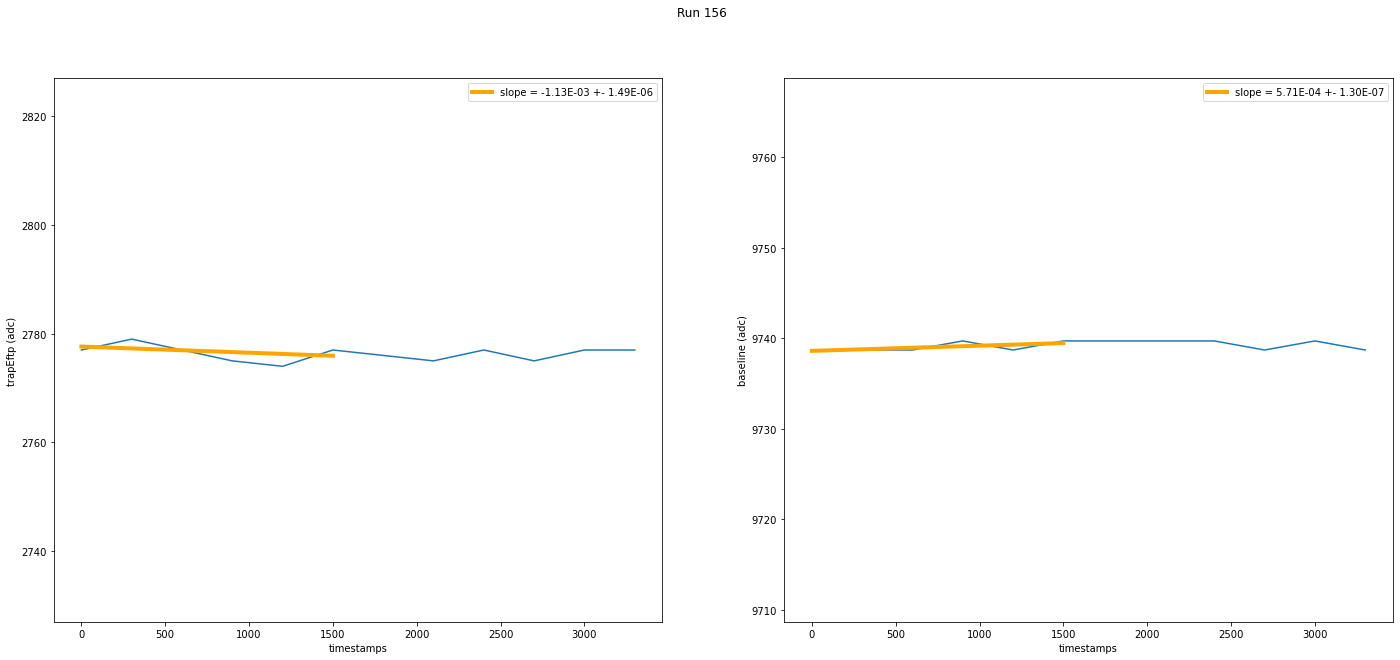

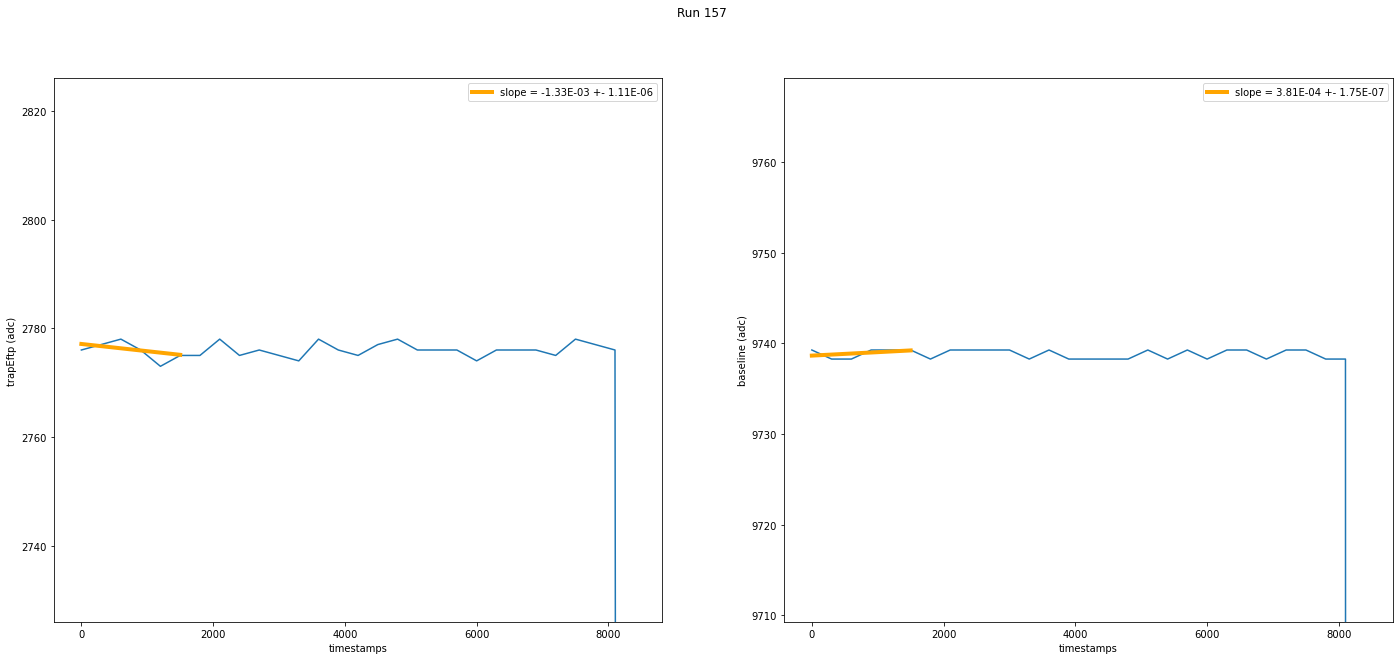

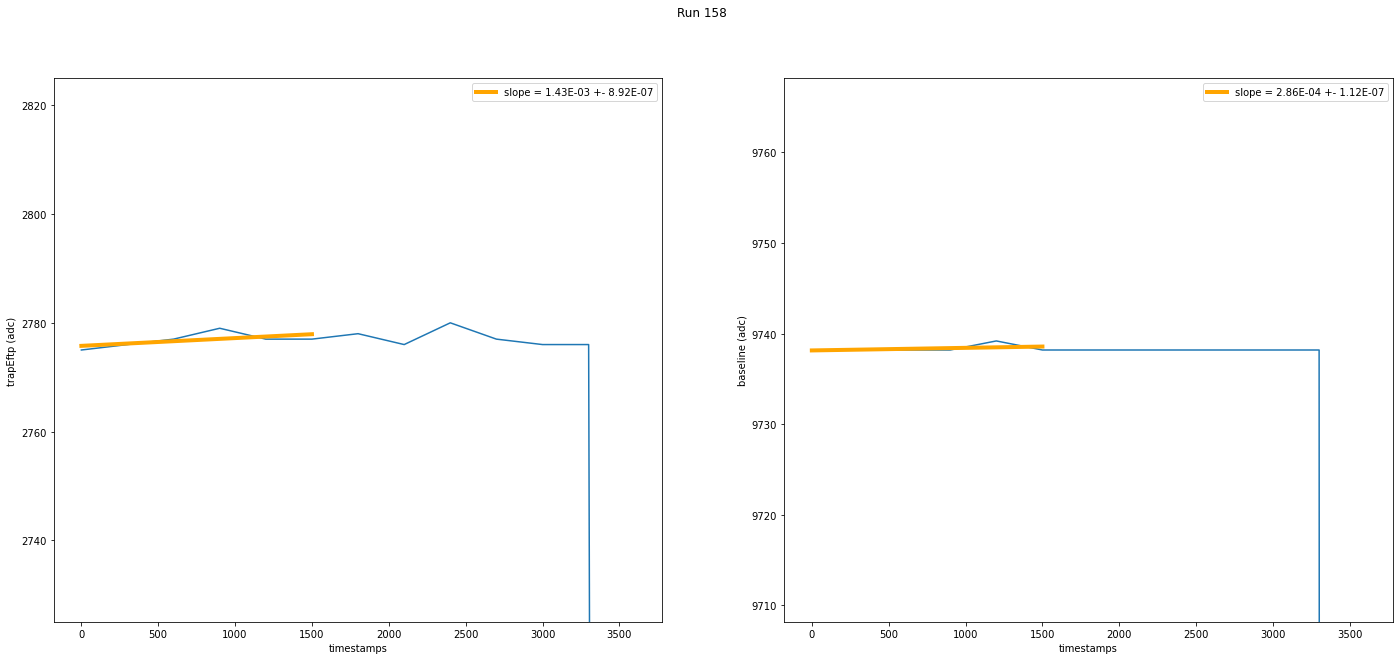

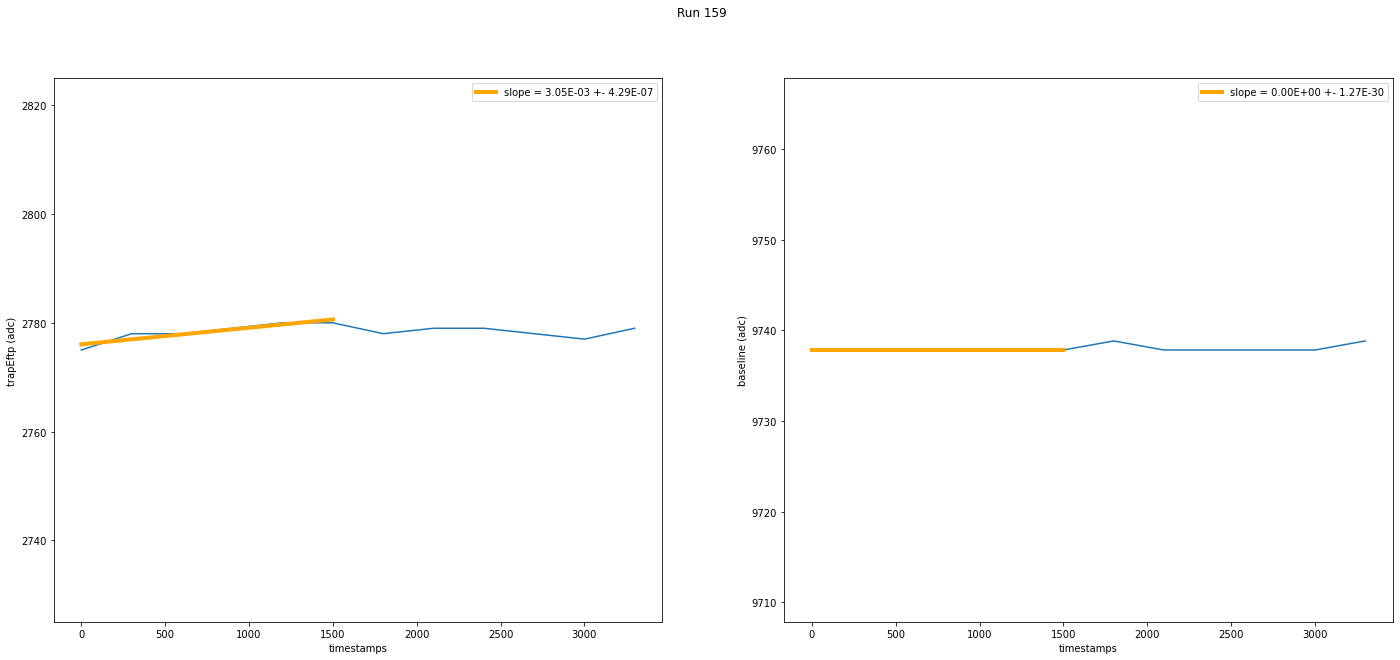

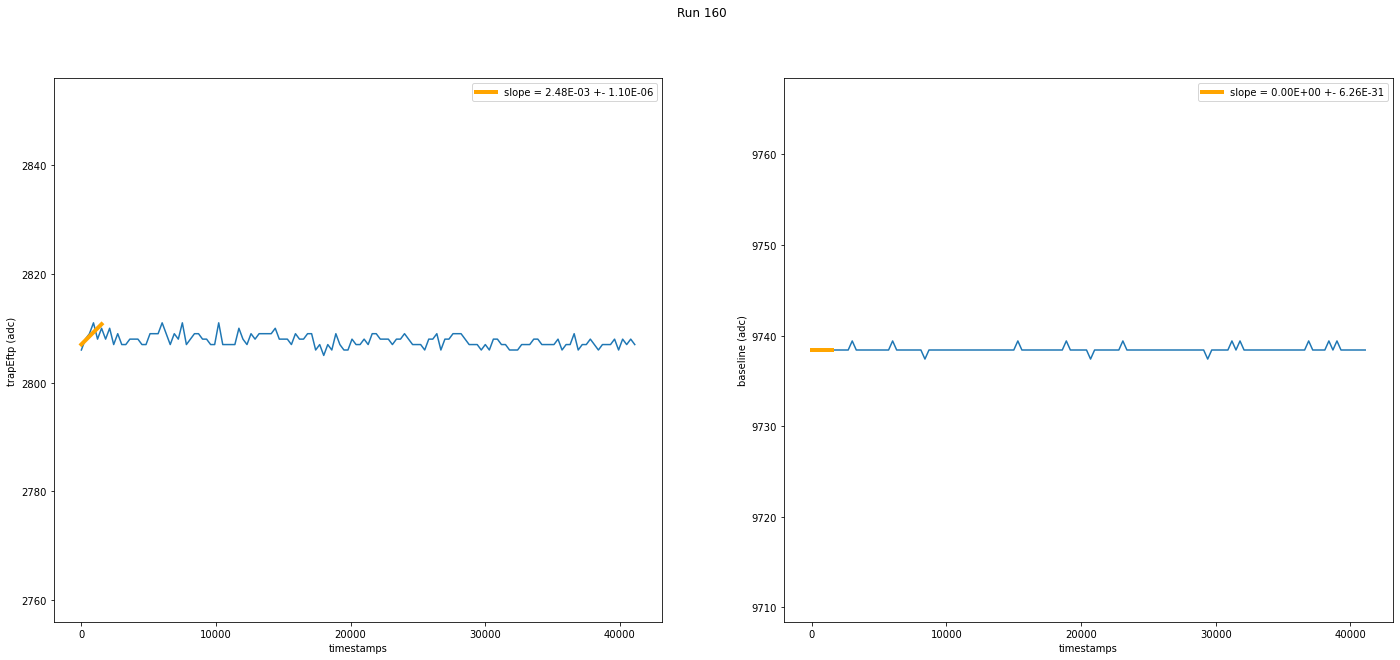

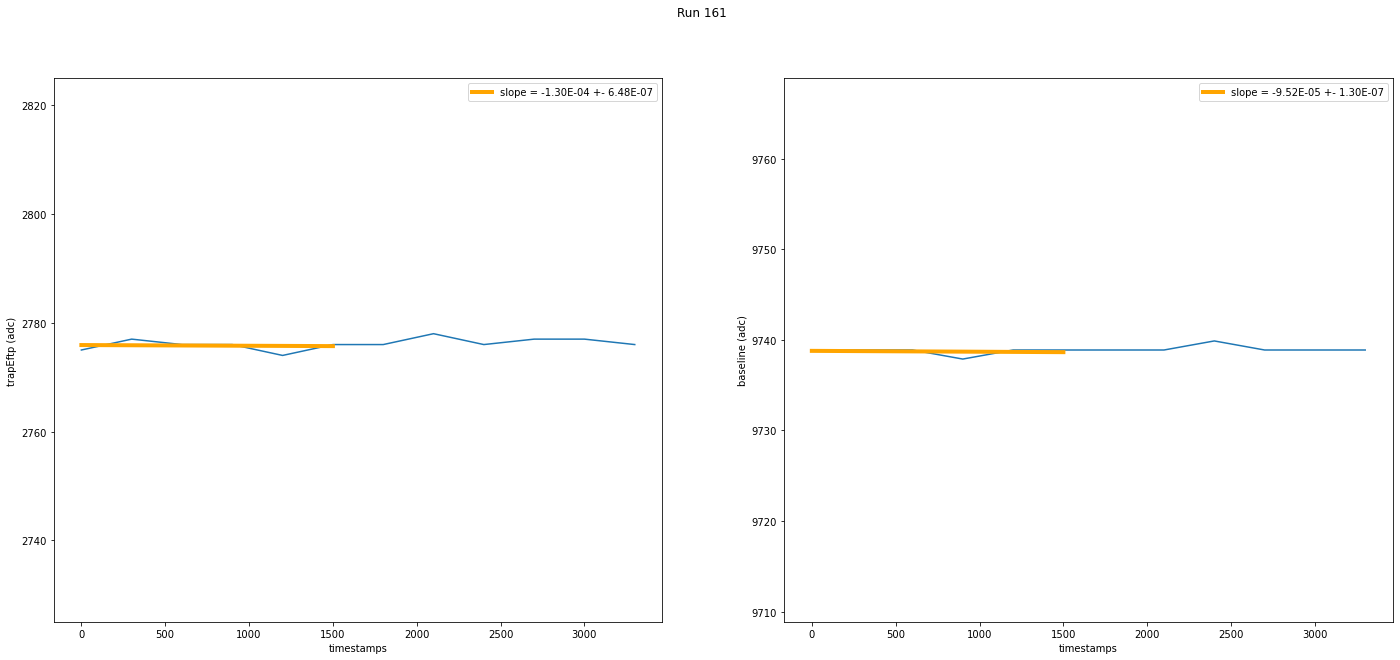

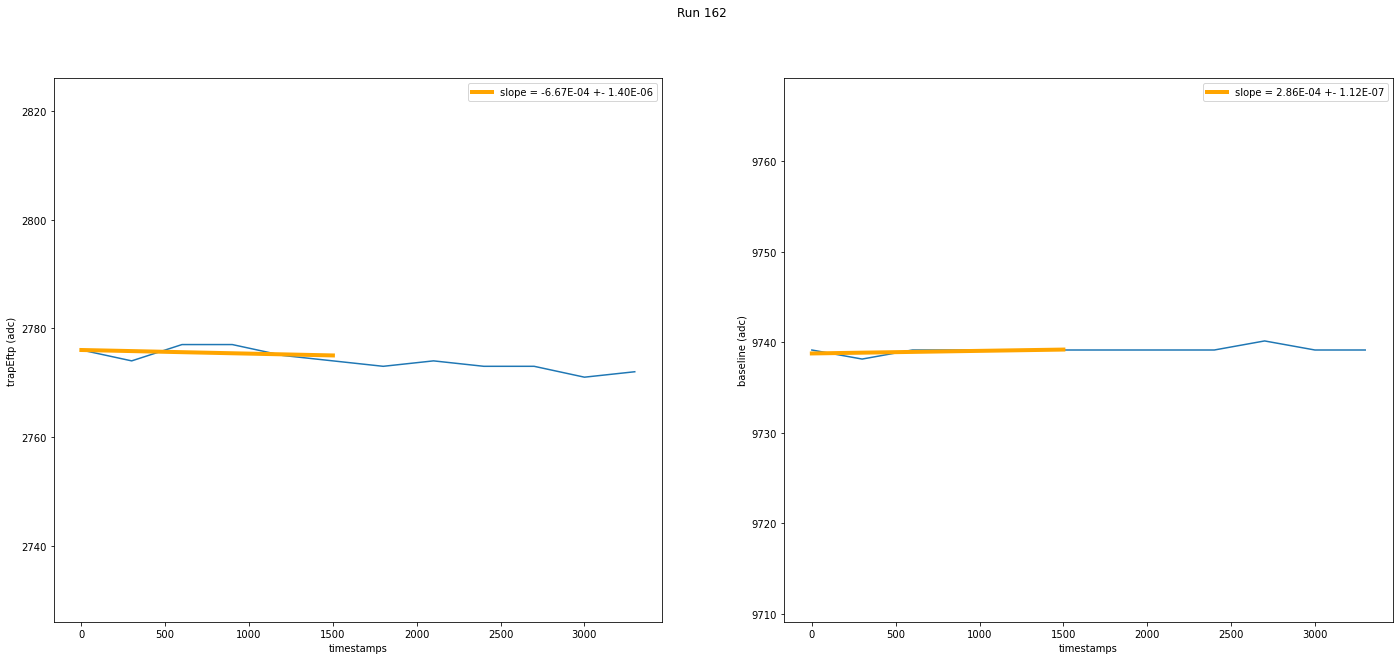

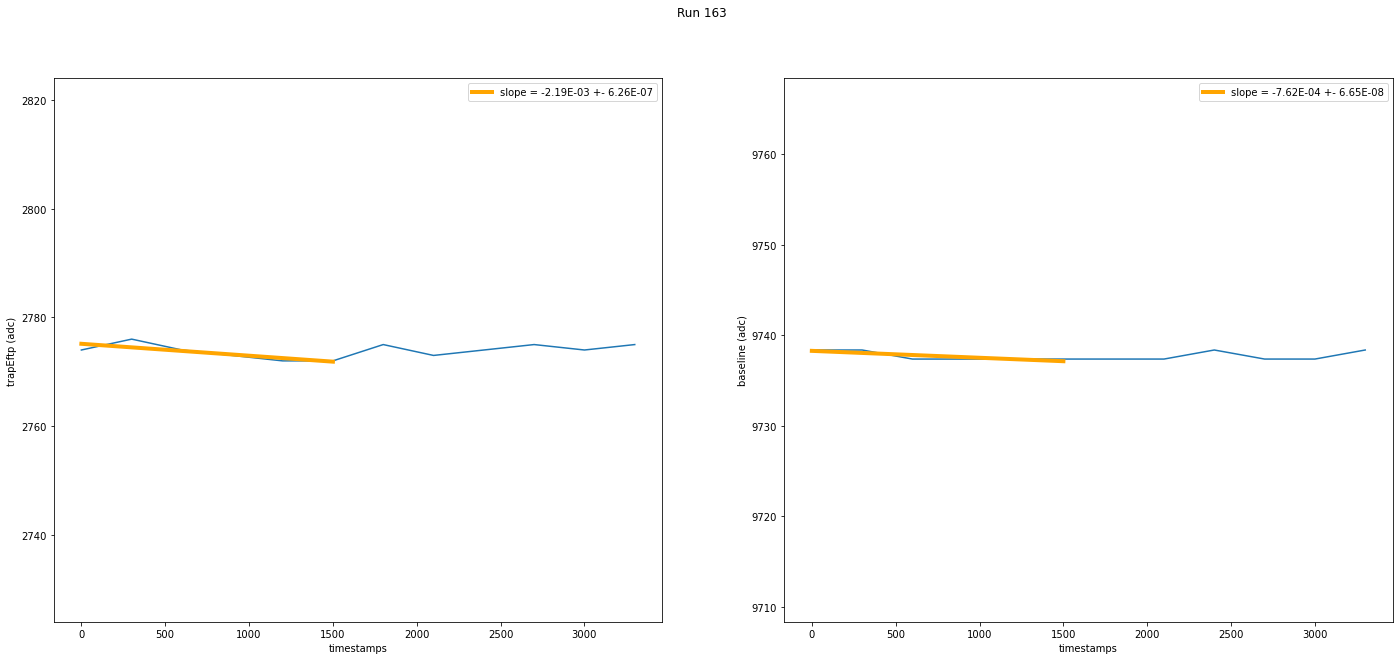

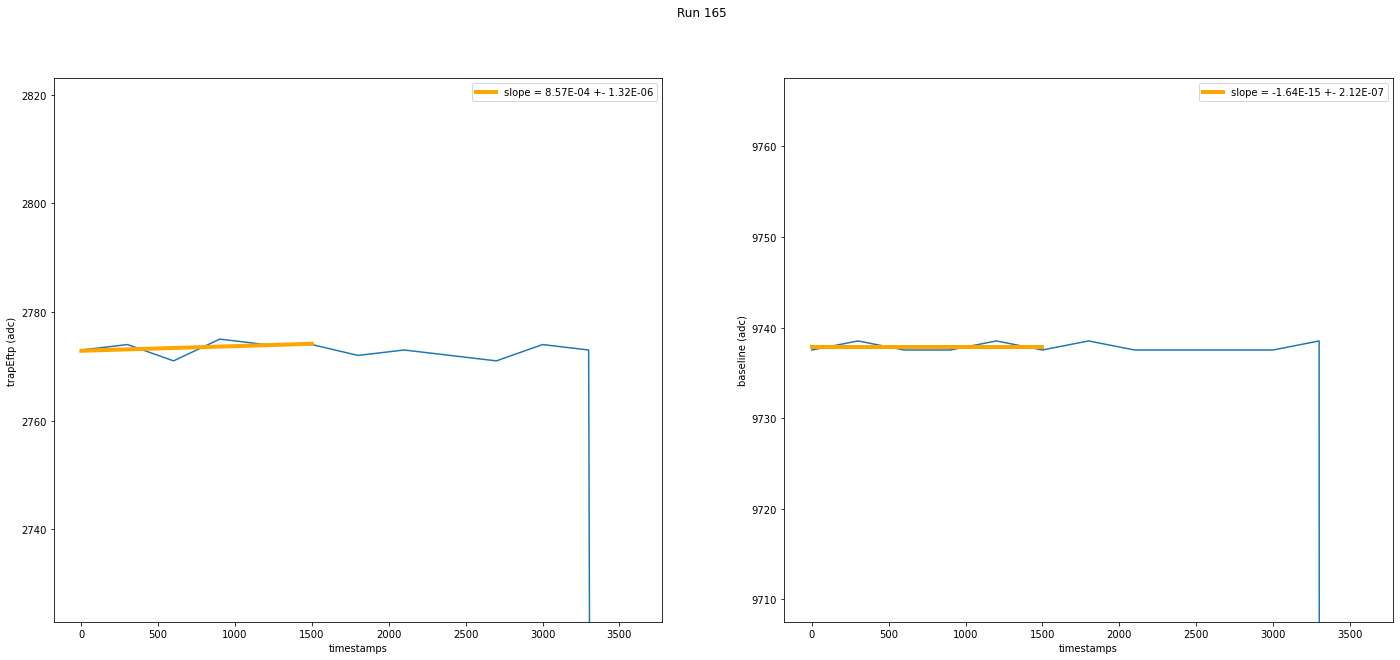

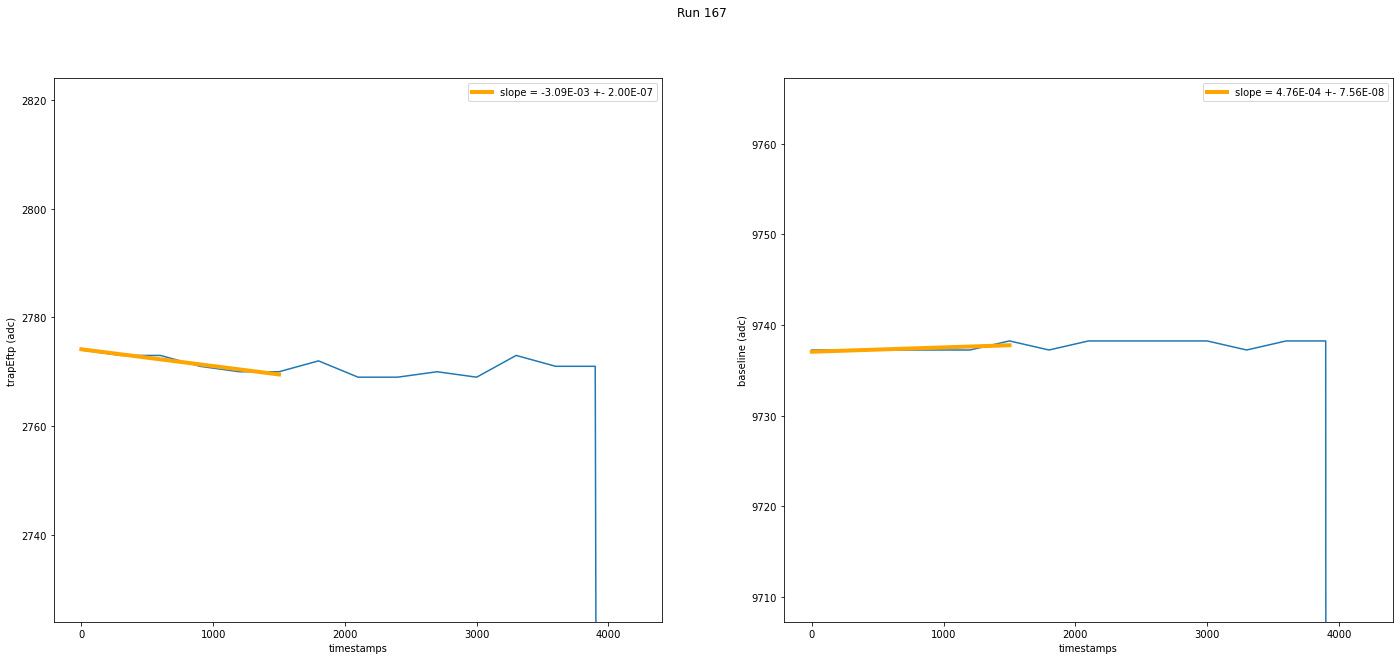

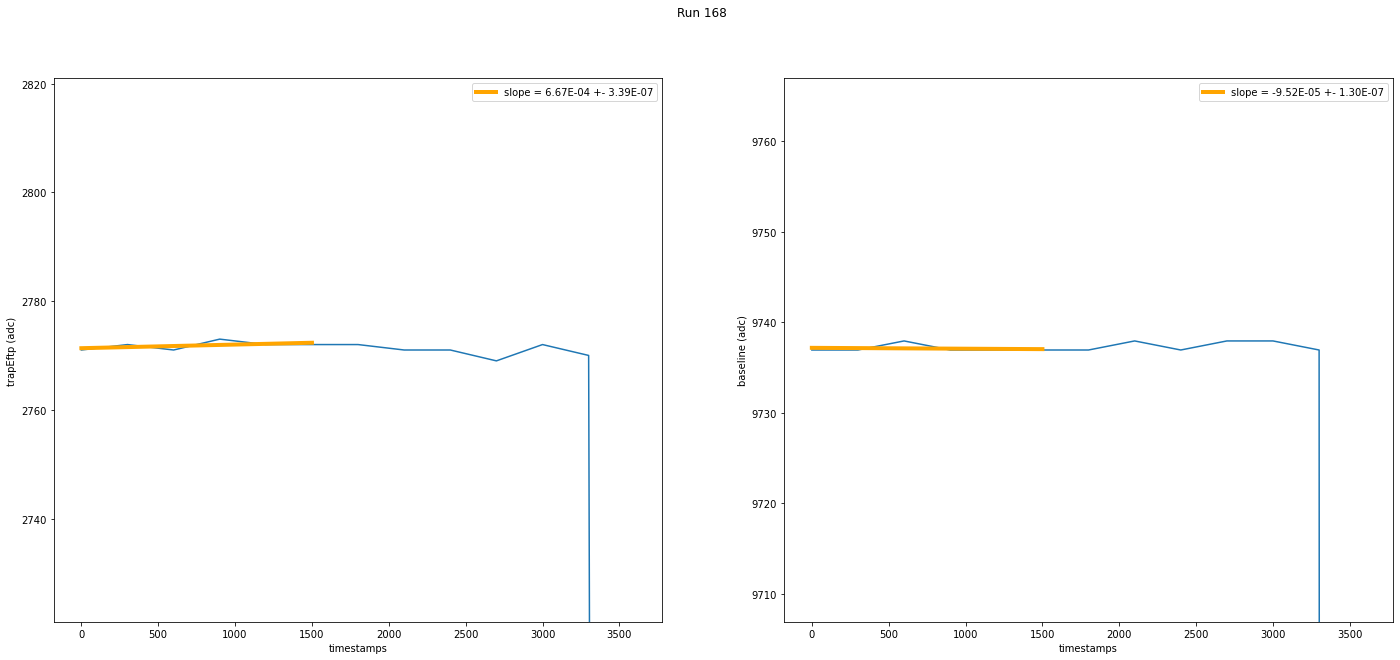

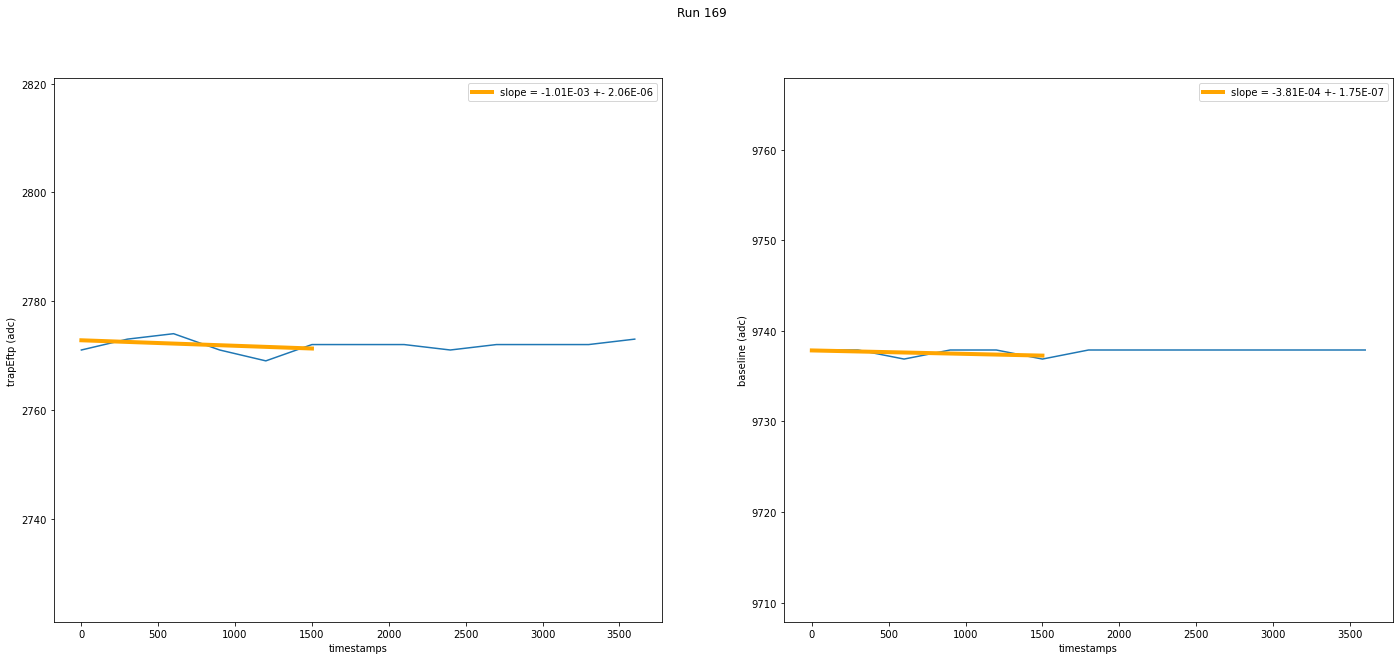

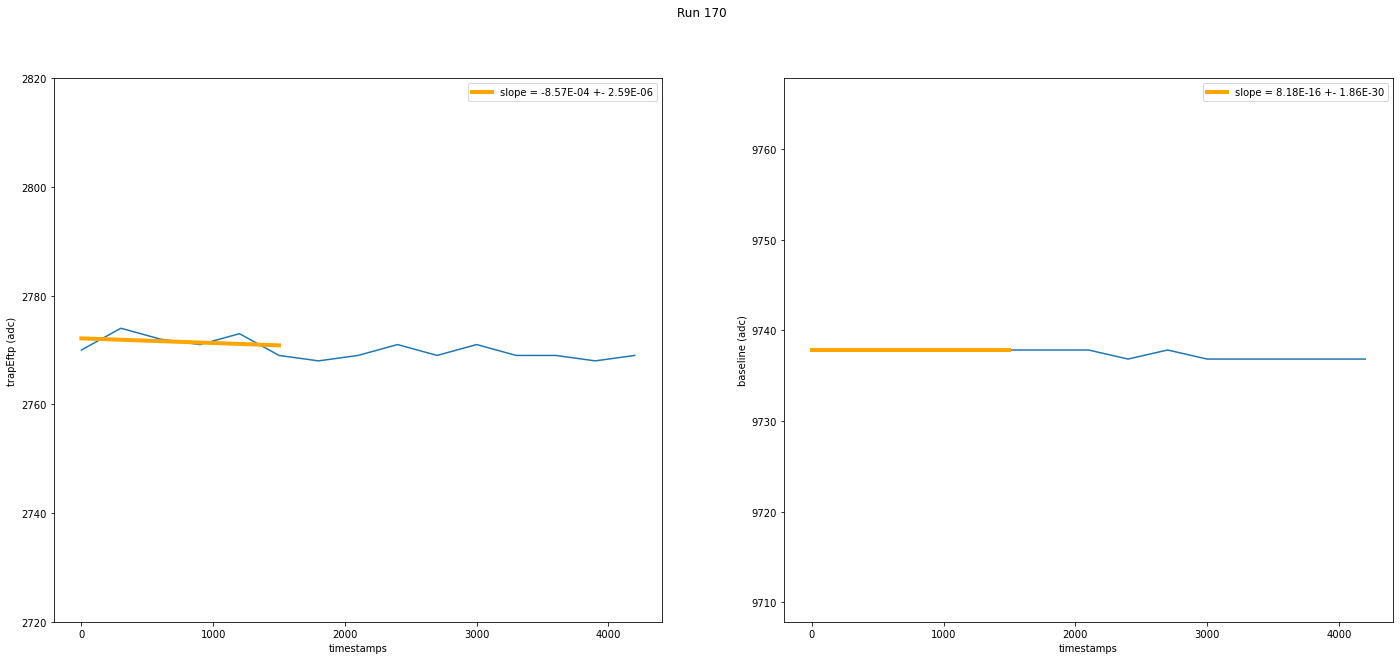

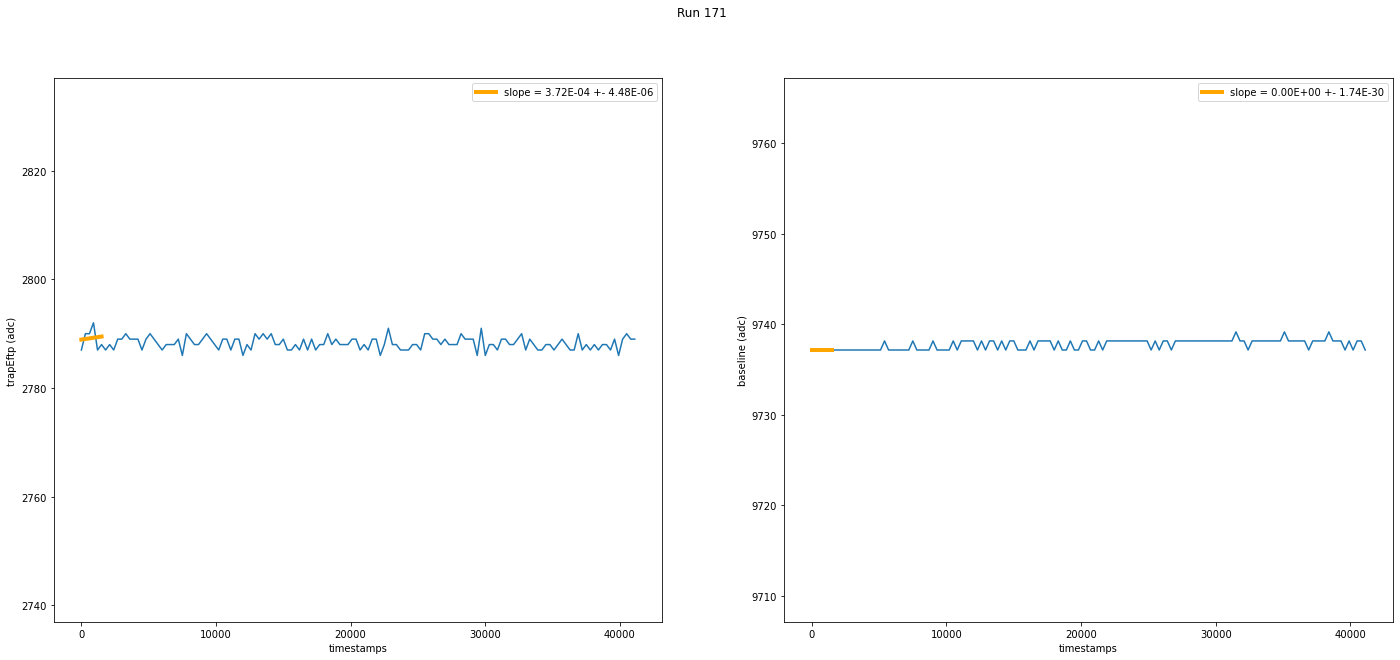


1460:  14.392000000001016 7.794228634059948
Baseline:  0.5996666666685199 2.598076211353316


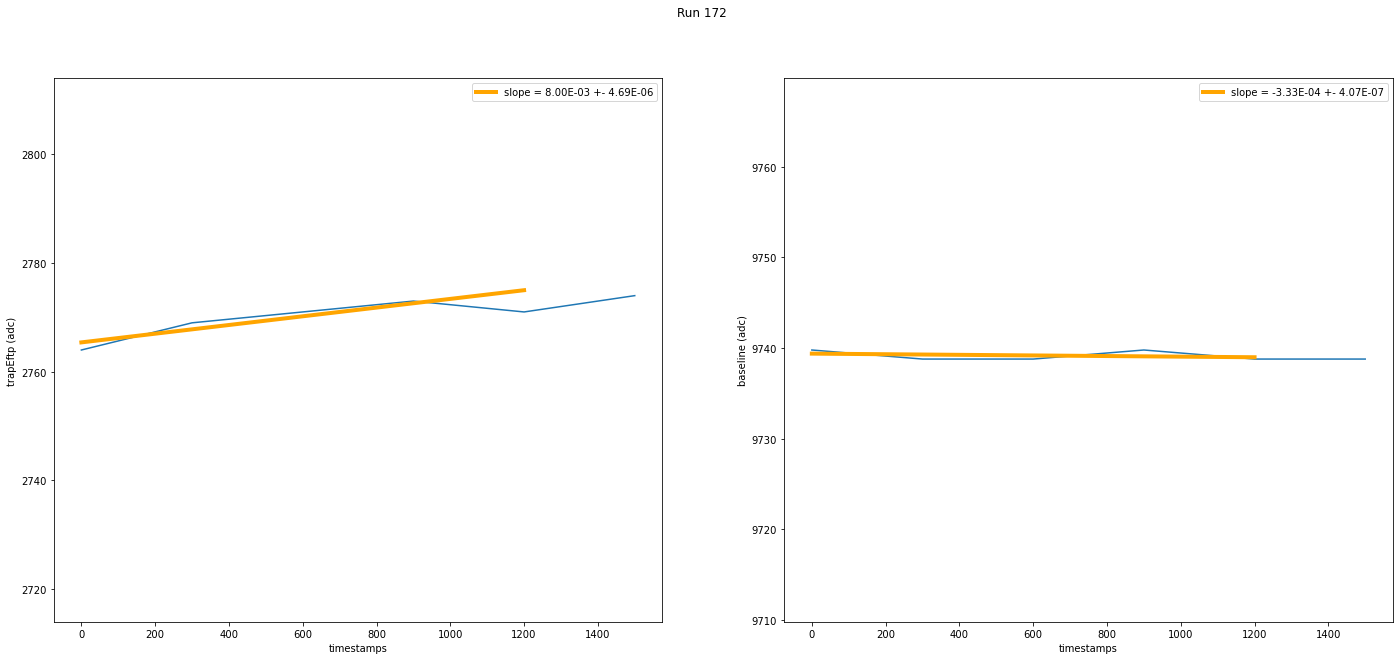

(172, (0.008000000000000564, 2765.4, 4.693602693603052e-06), (-0.0003333333333343635, 9739.369531249997, 4.0740740740729435e-07))


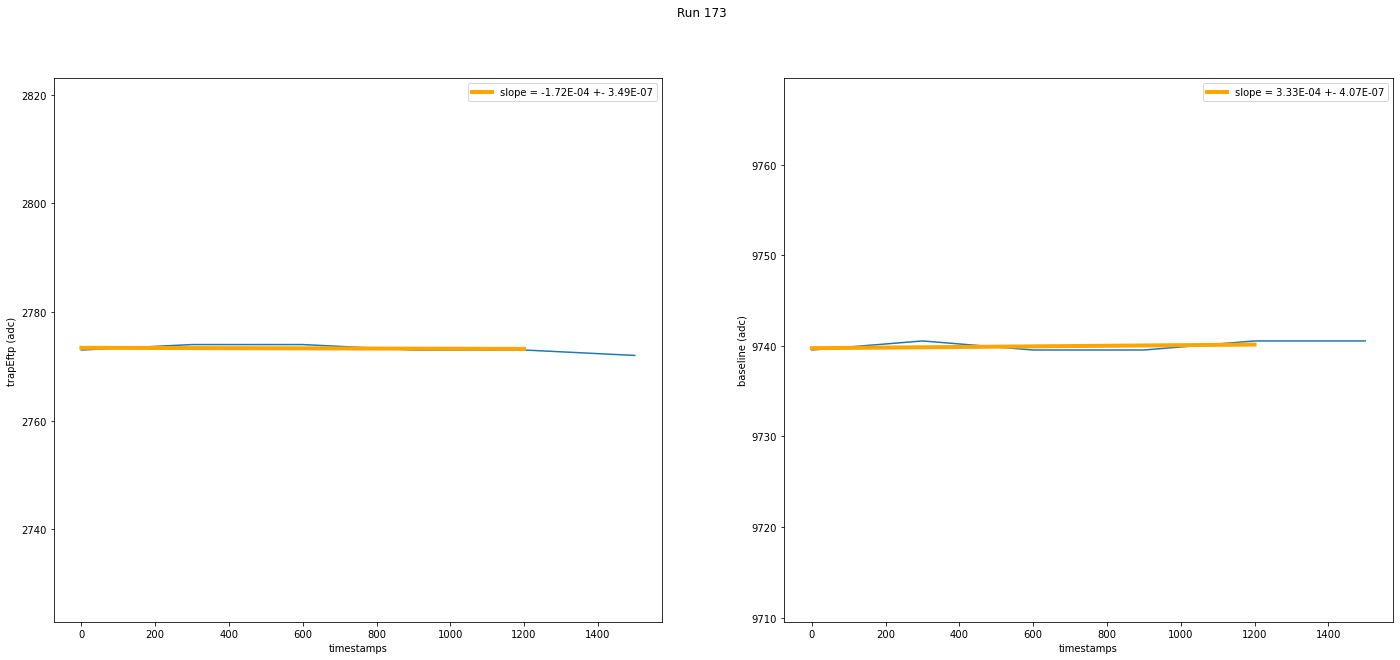

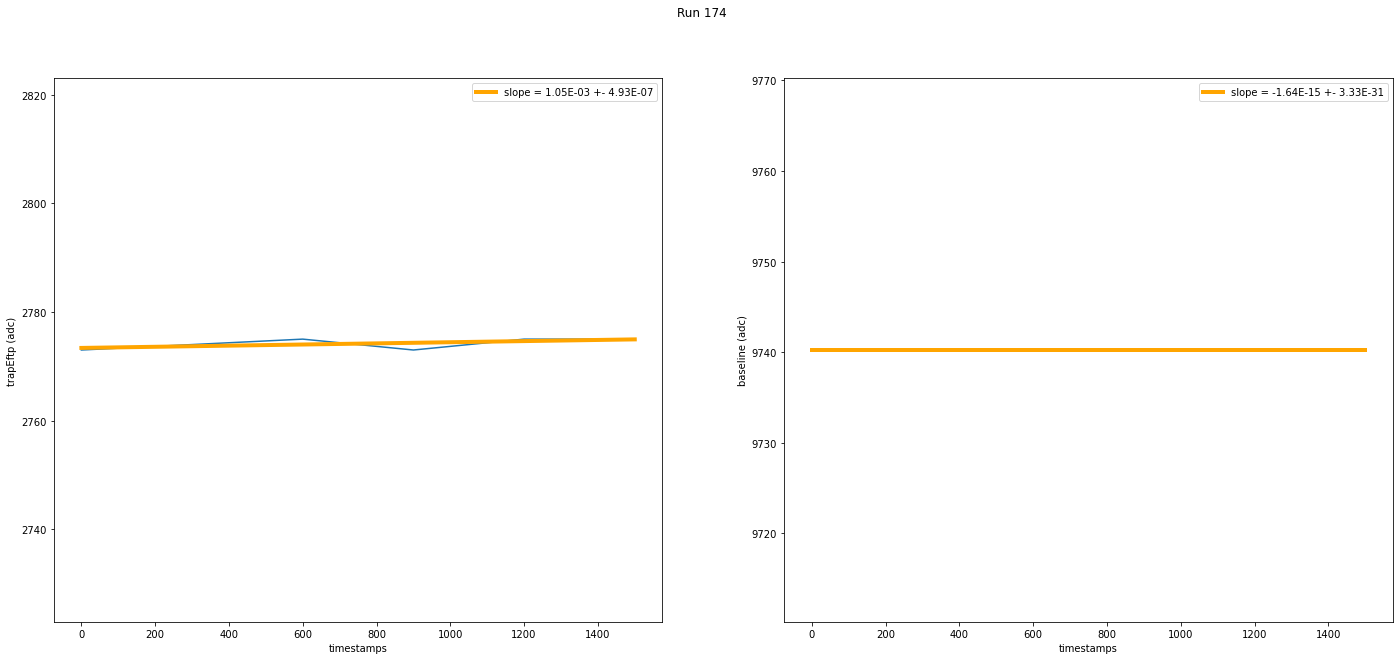

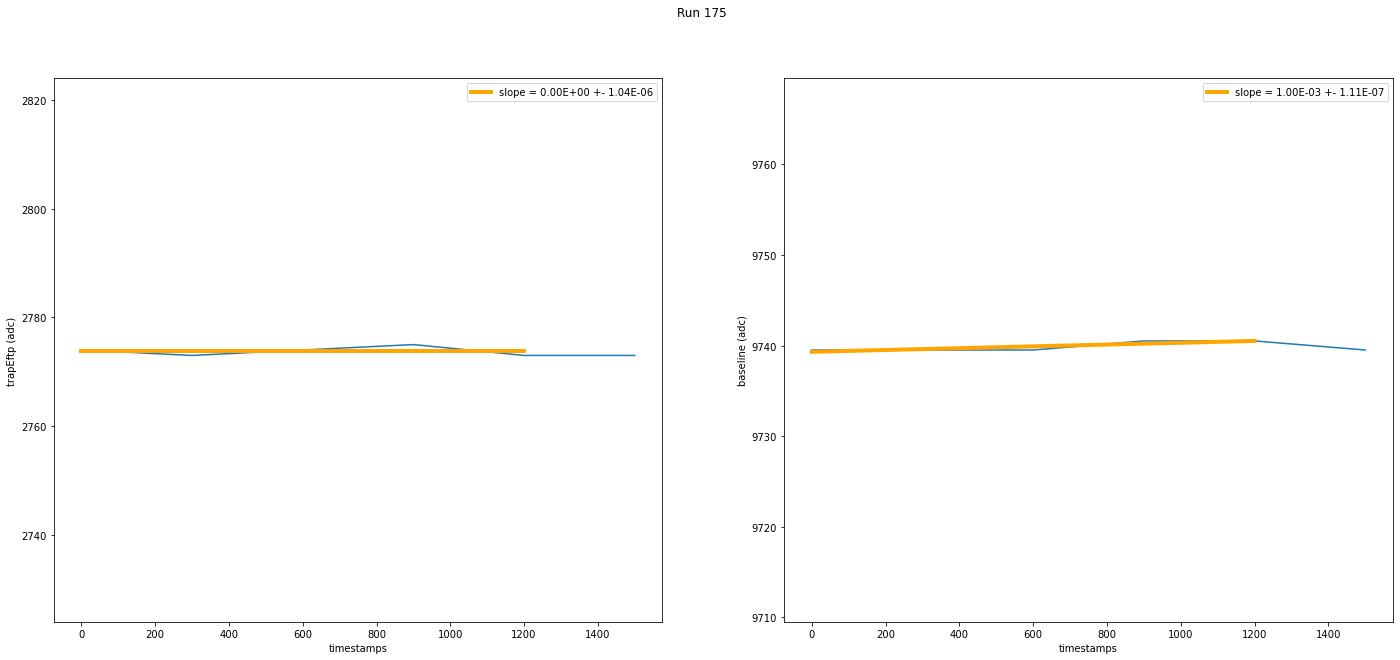

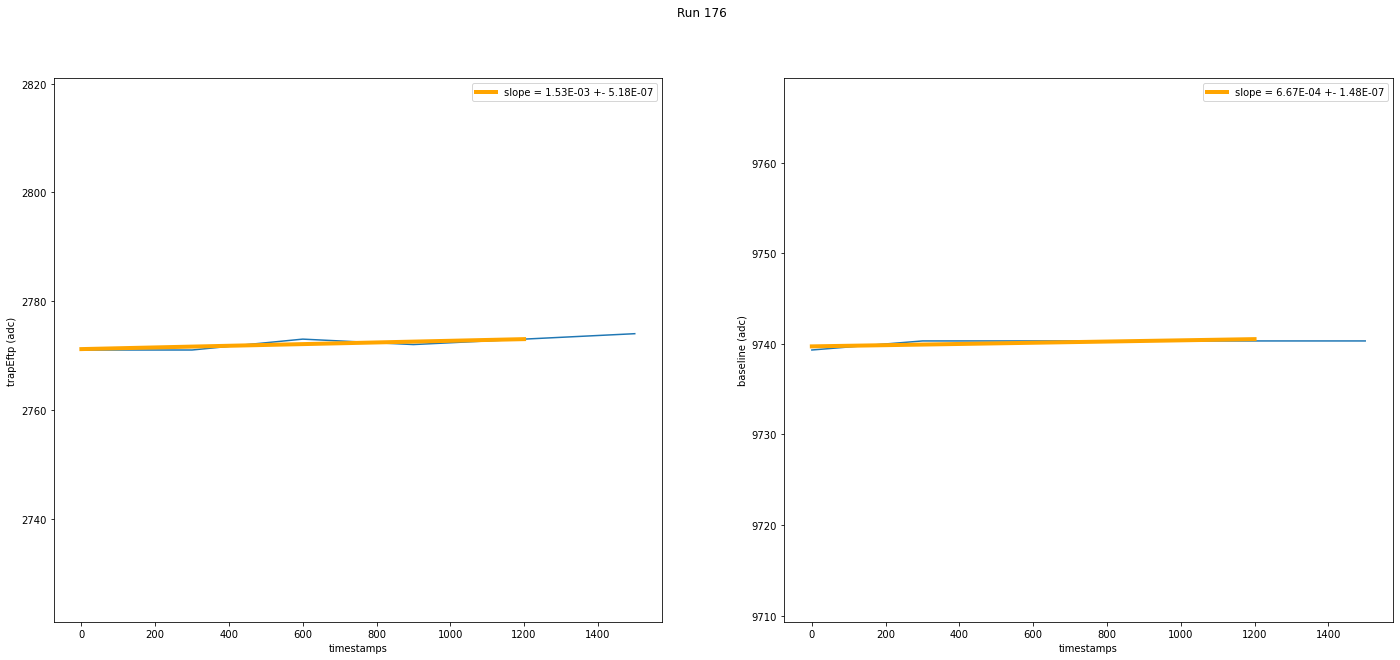

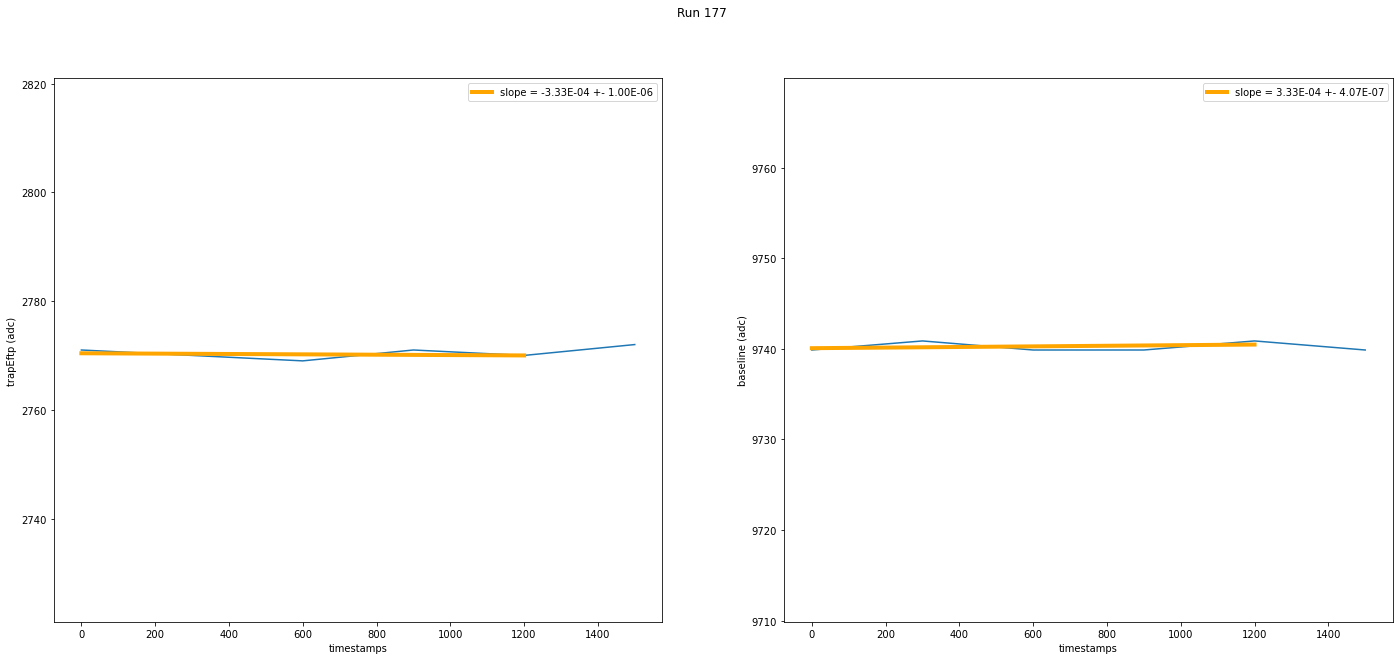

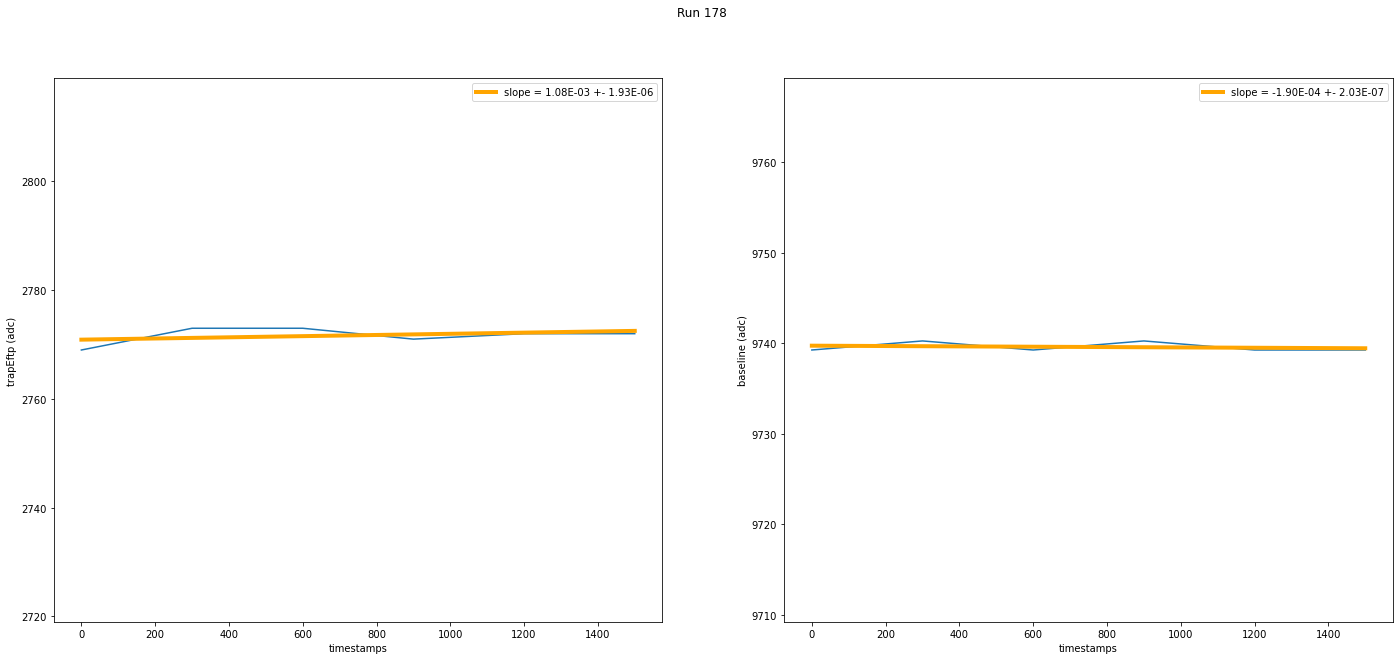

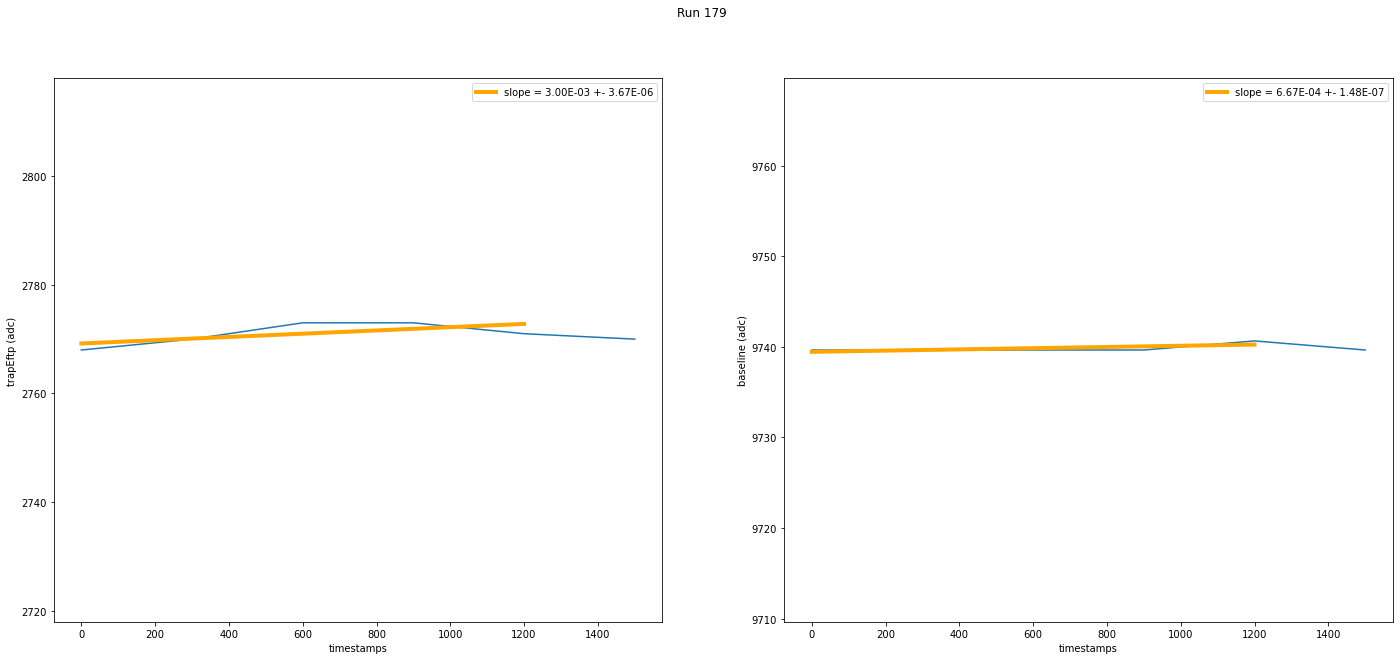

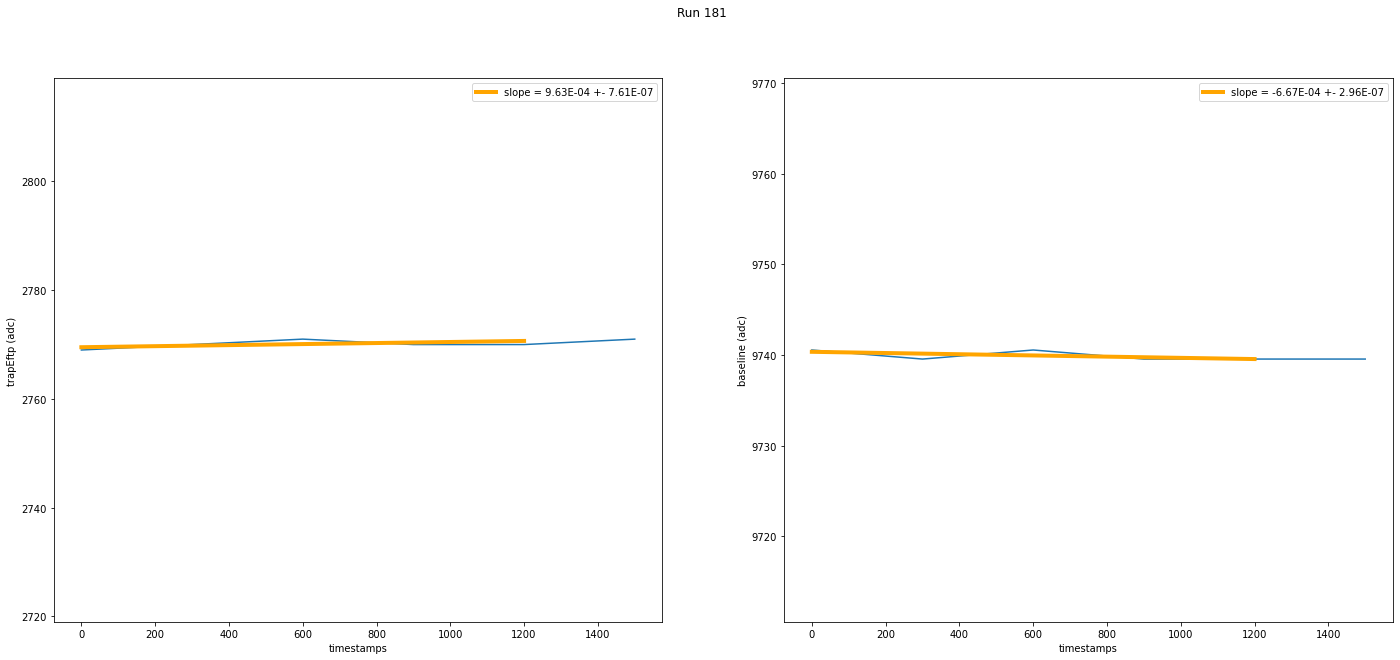

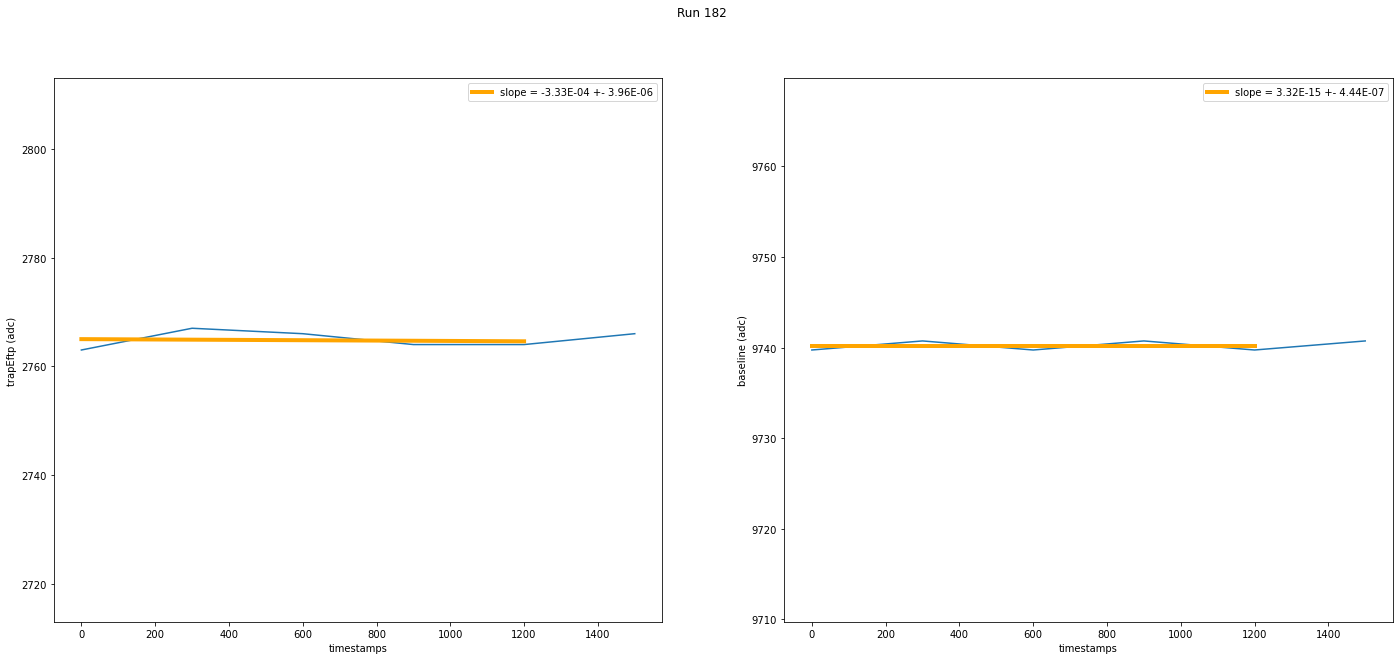

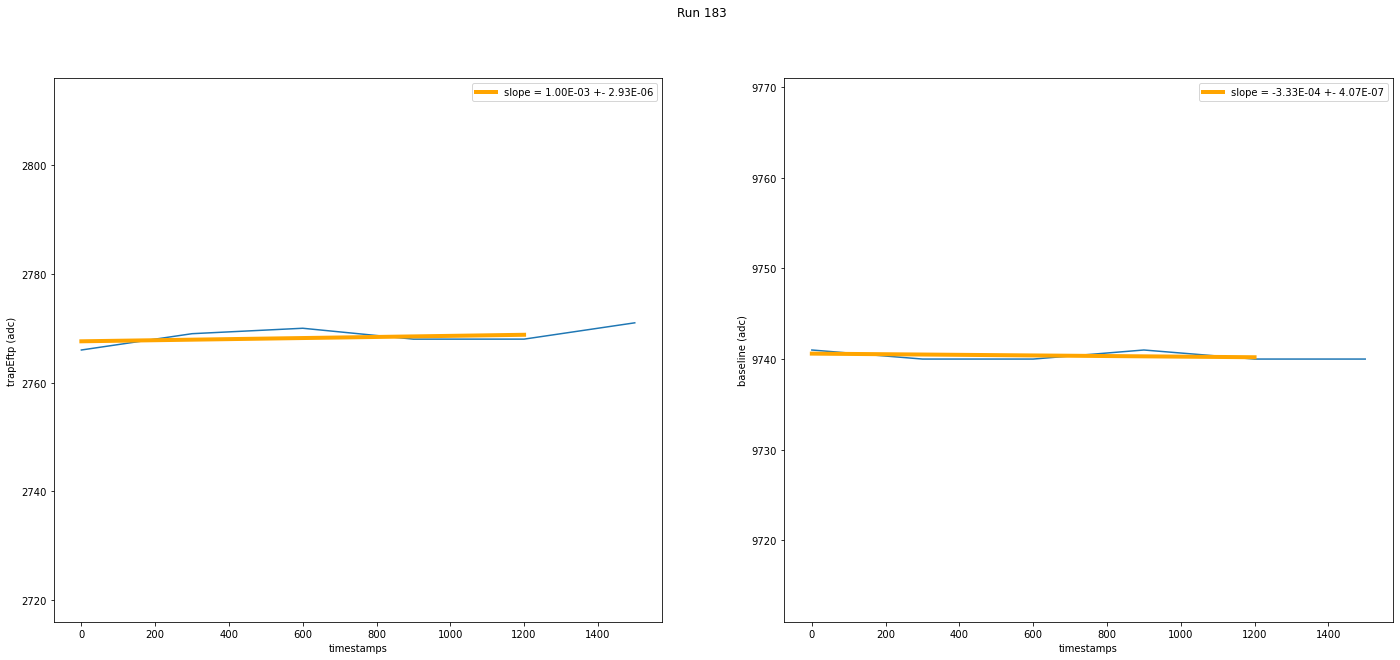

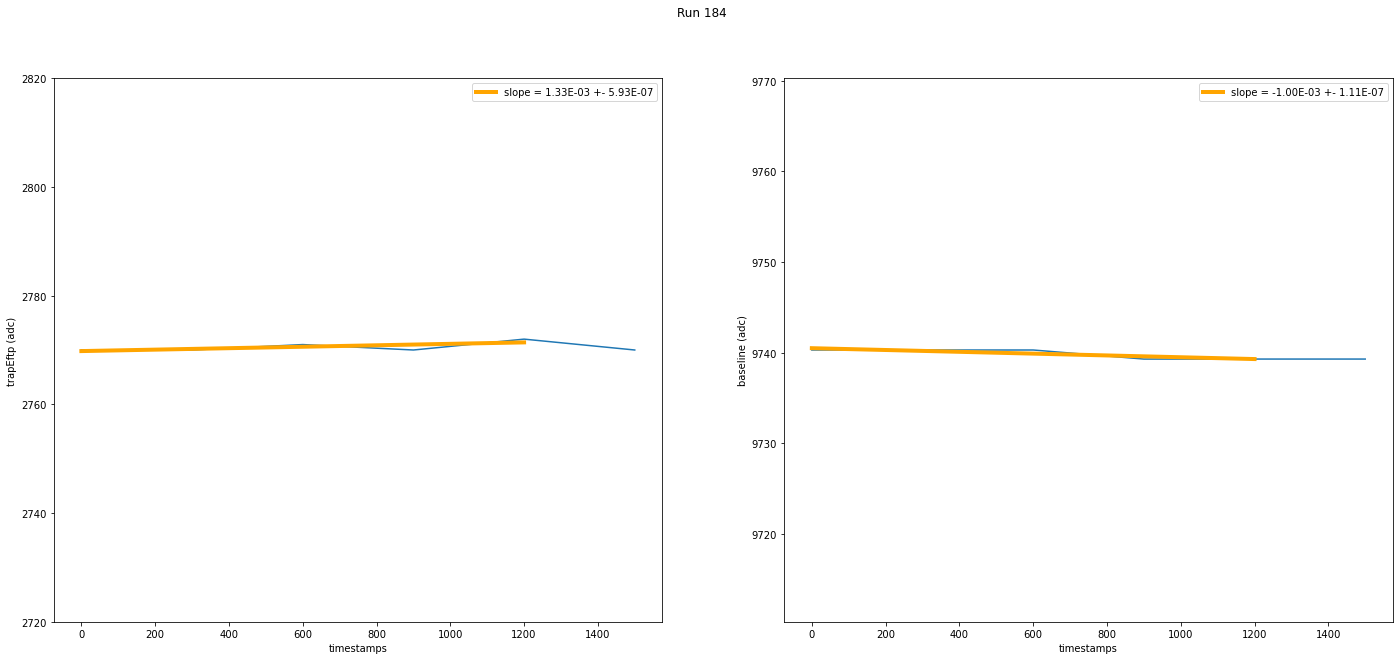

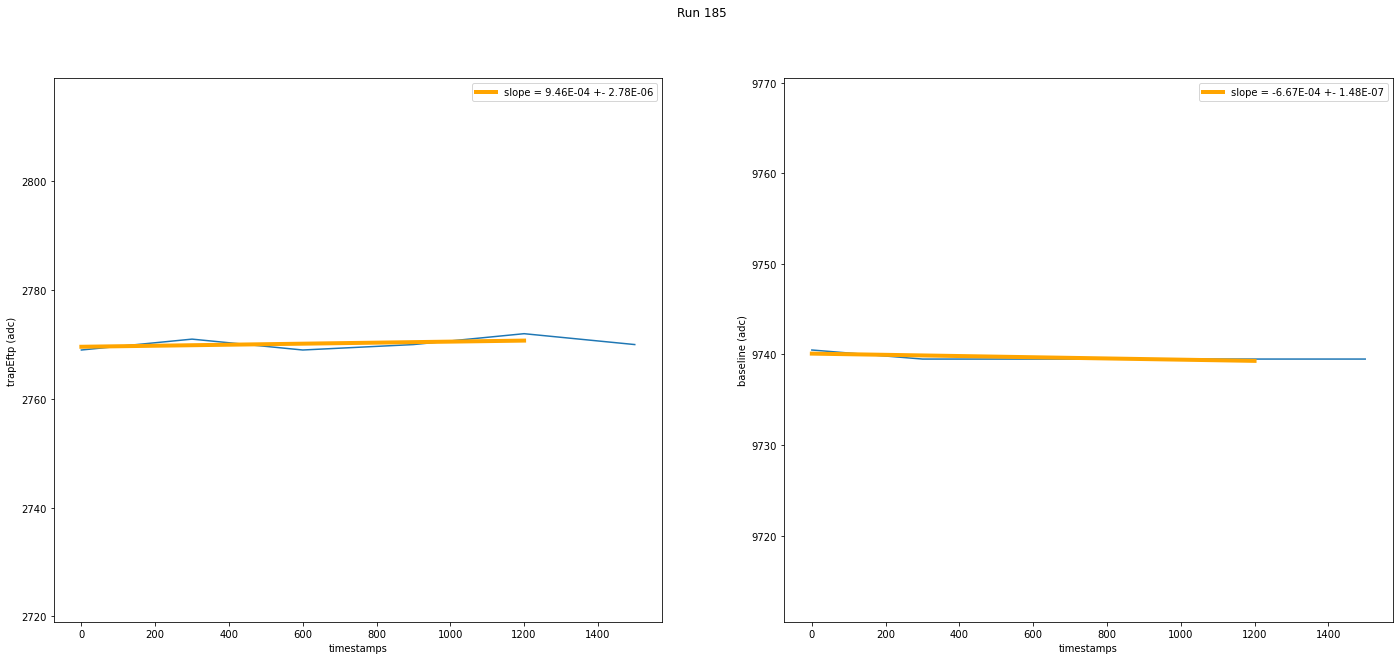

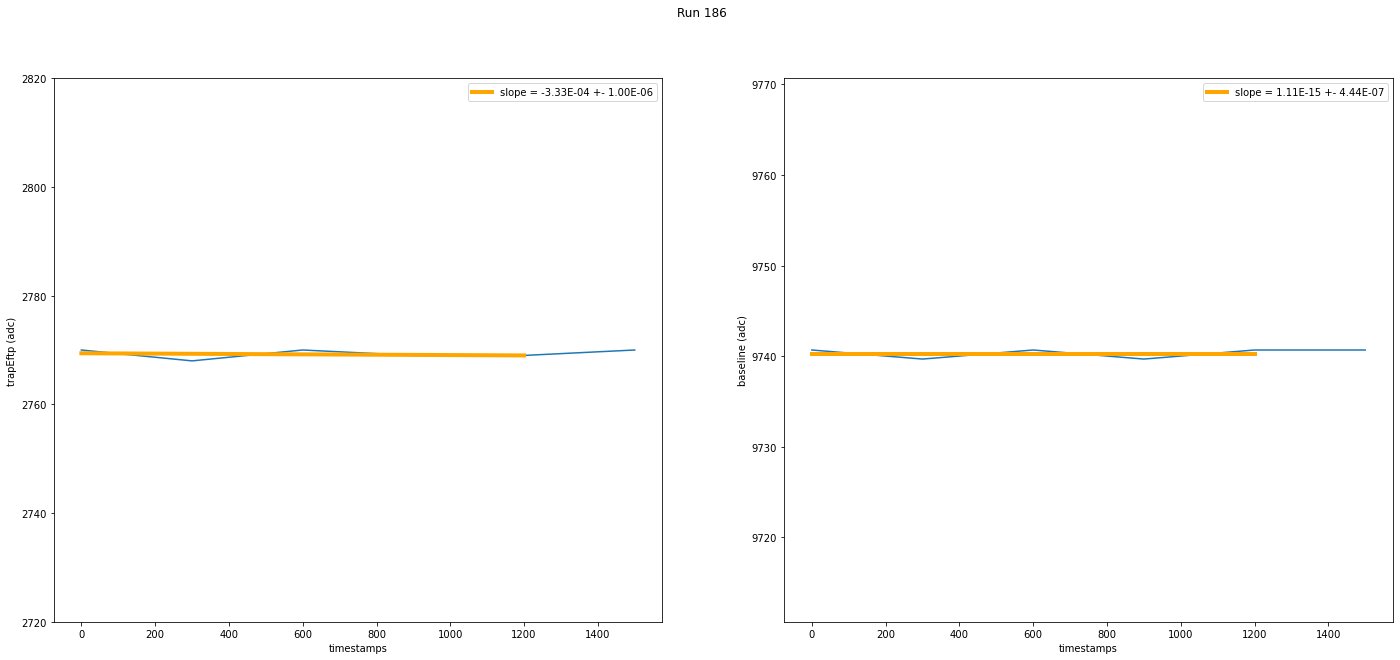


1460:  3.595999999999764 2.598076211353316
Baseline:  0.5993333333312048 3.0


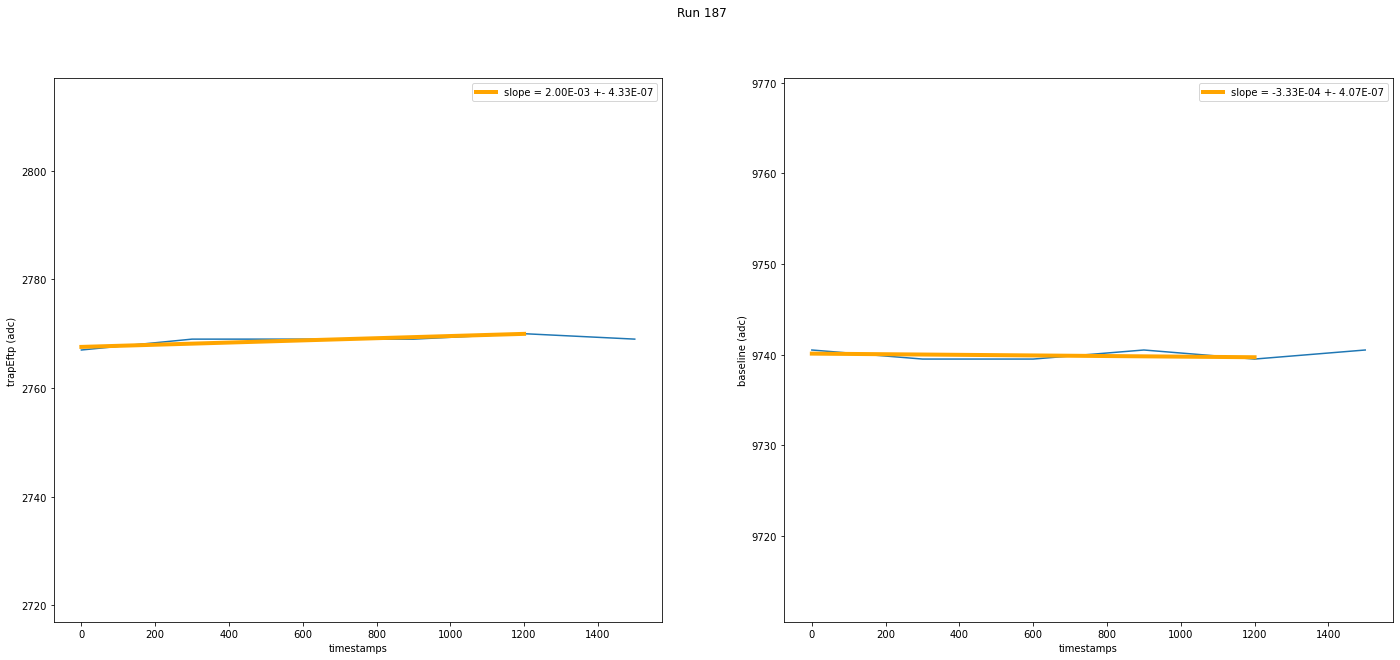

(187, (0.0019999999999998686, 2767.5692307692298, 4.330484330492245e-07), (-0.0003333333333321495, 9740.110742187491, 4.07407407406751e-07))


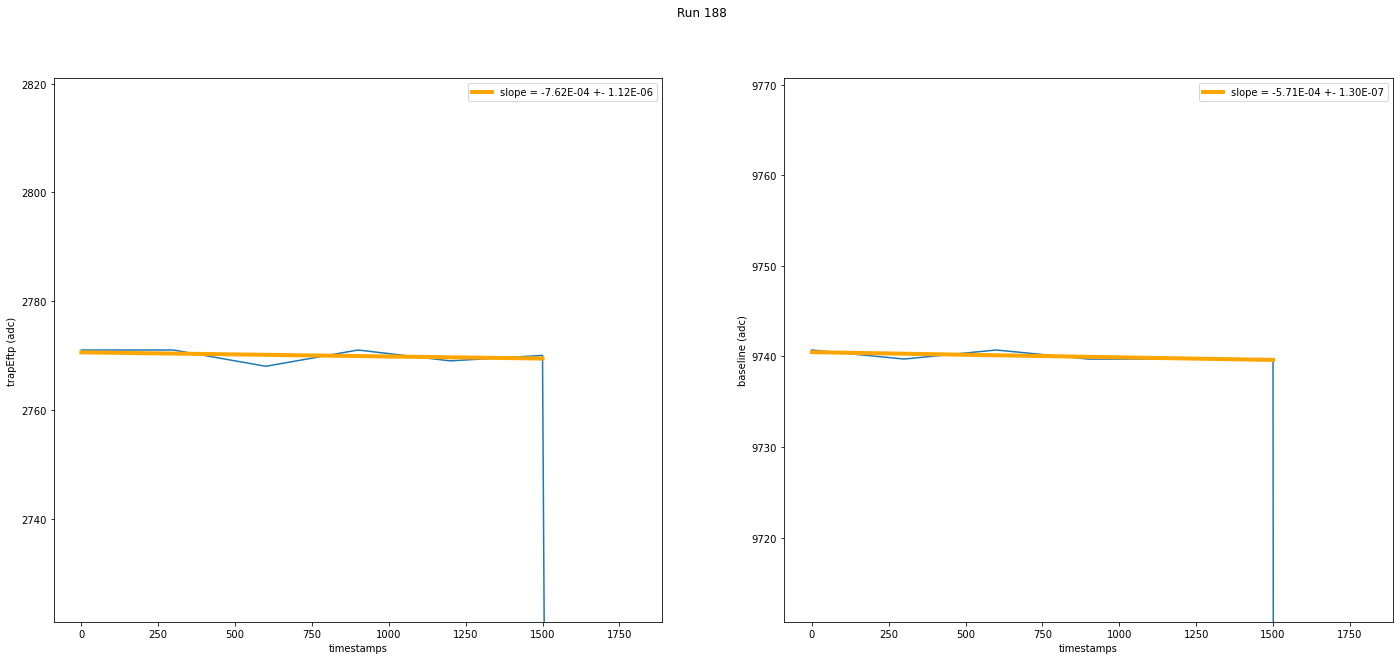

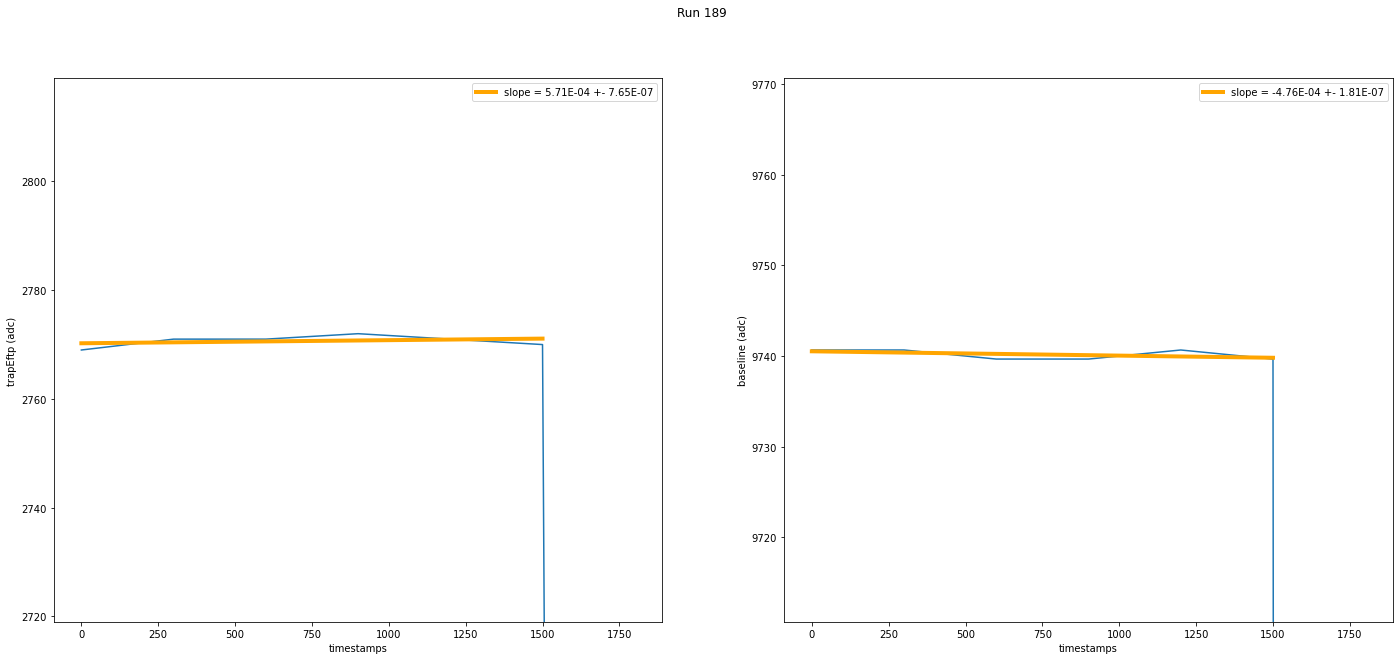

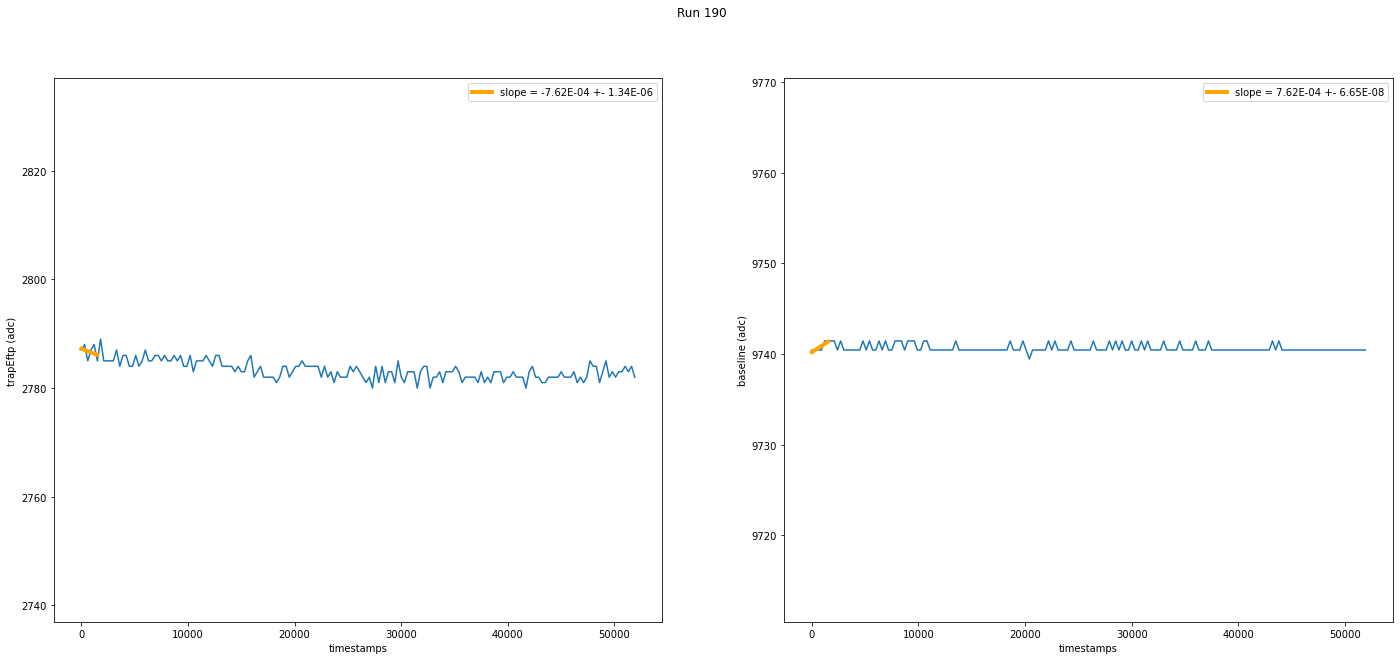

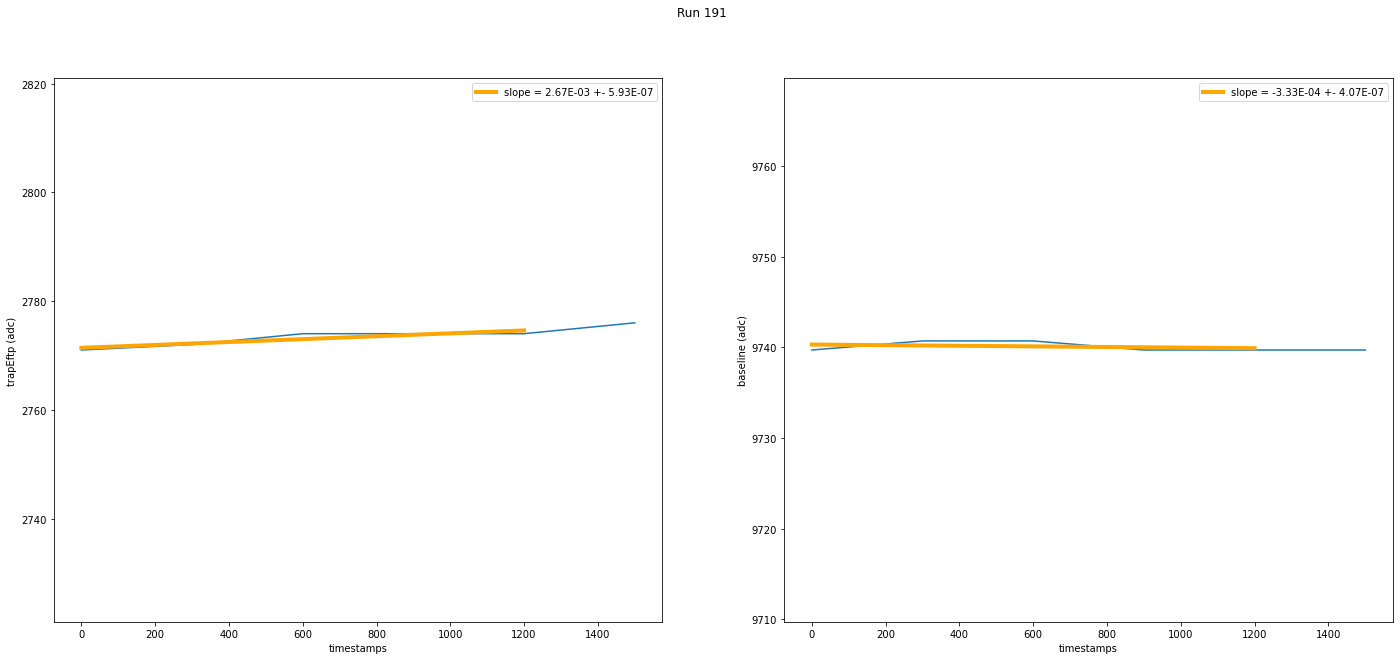

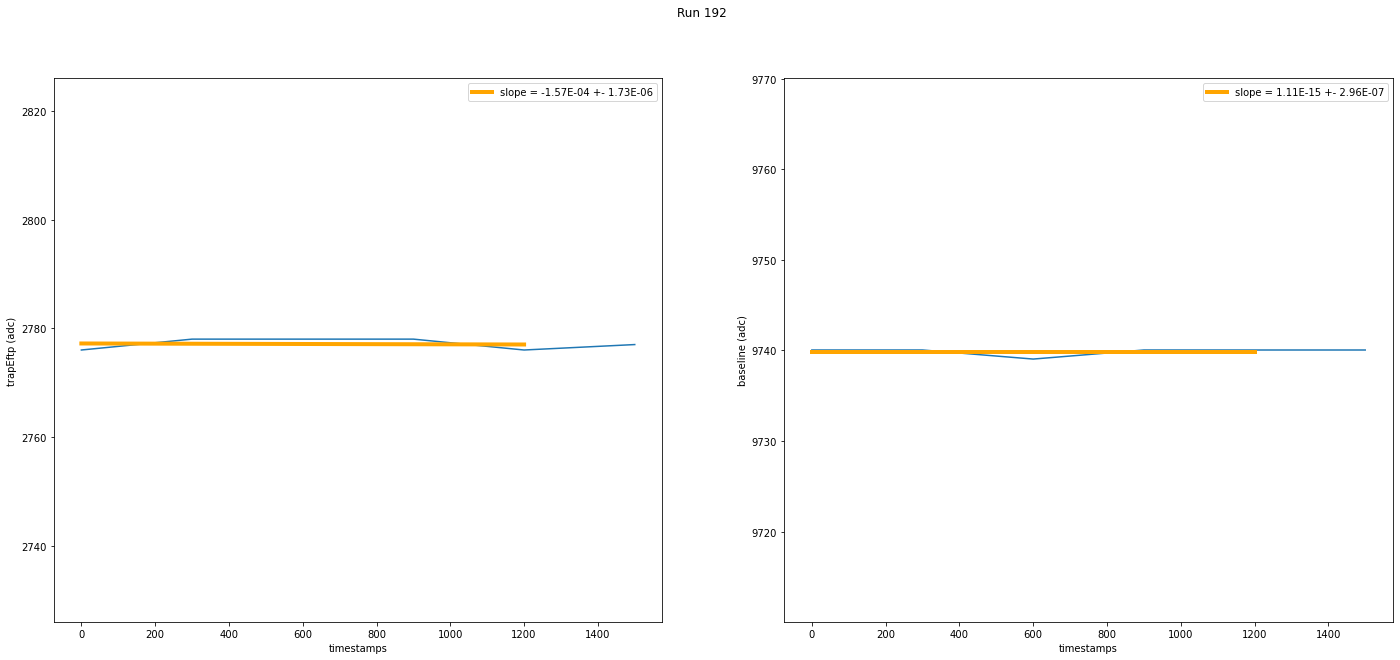

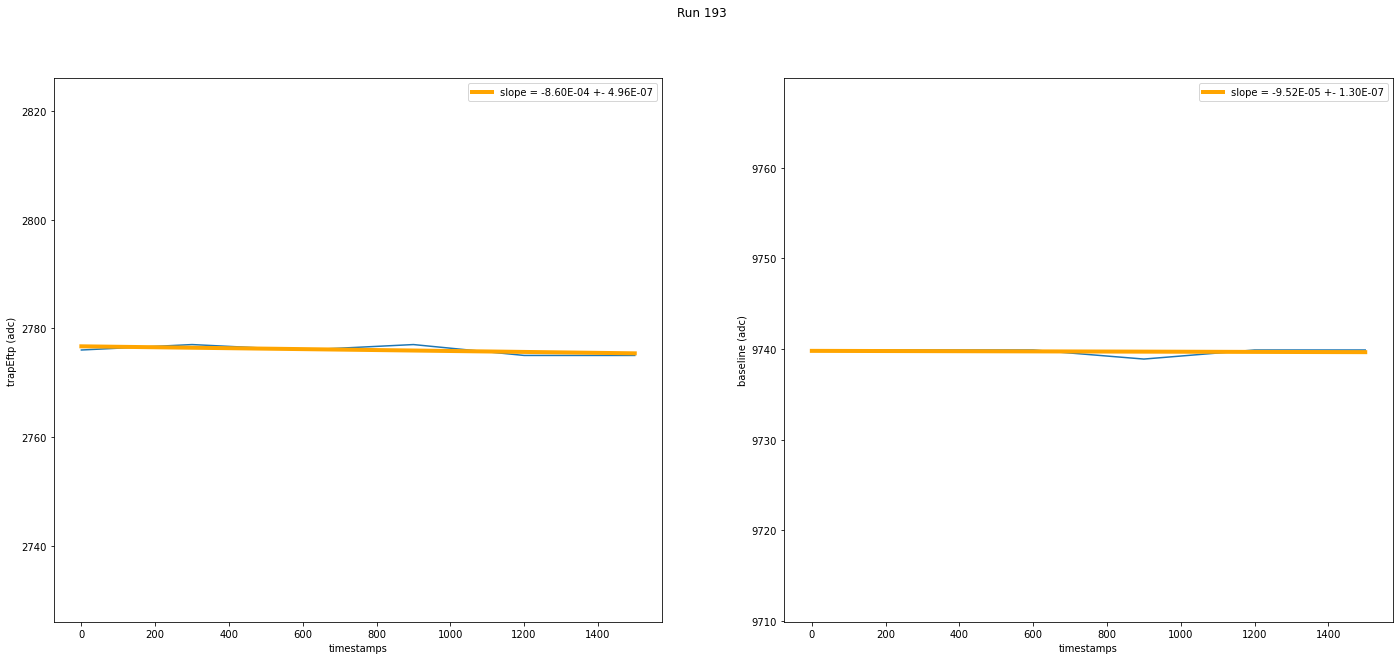

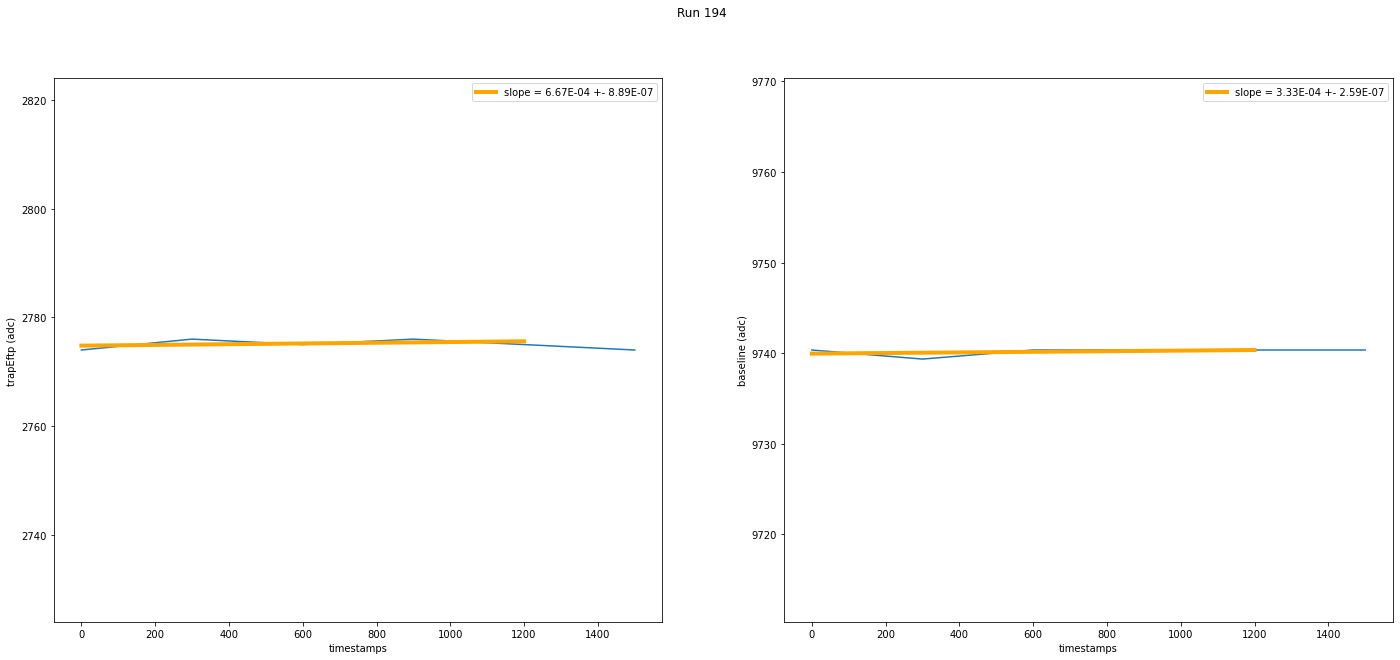

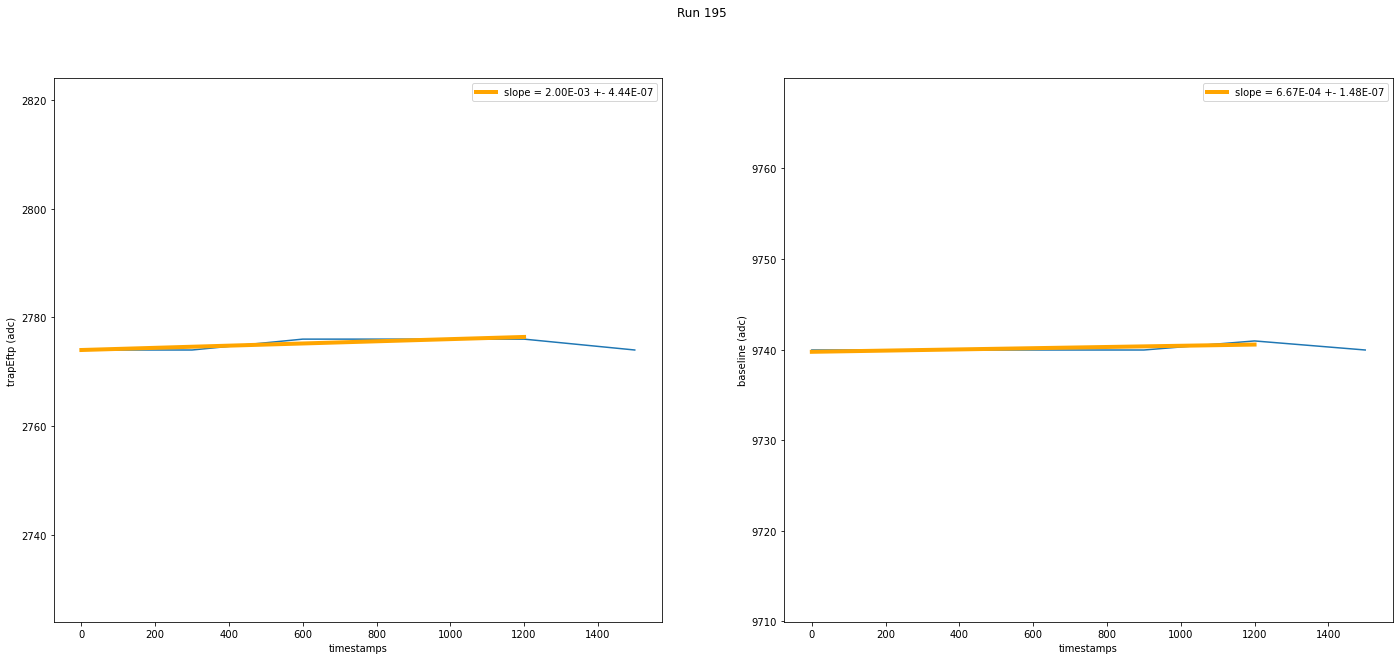

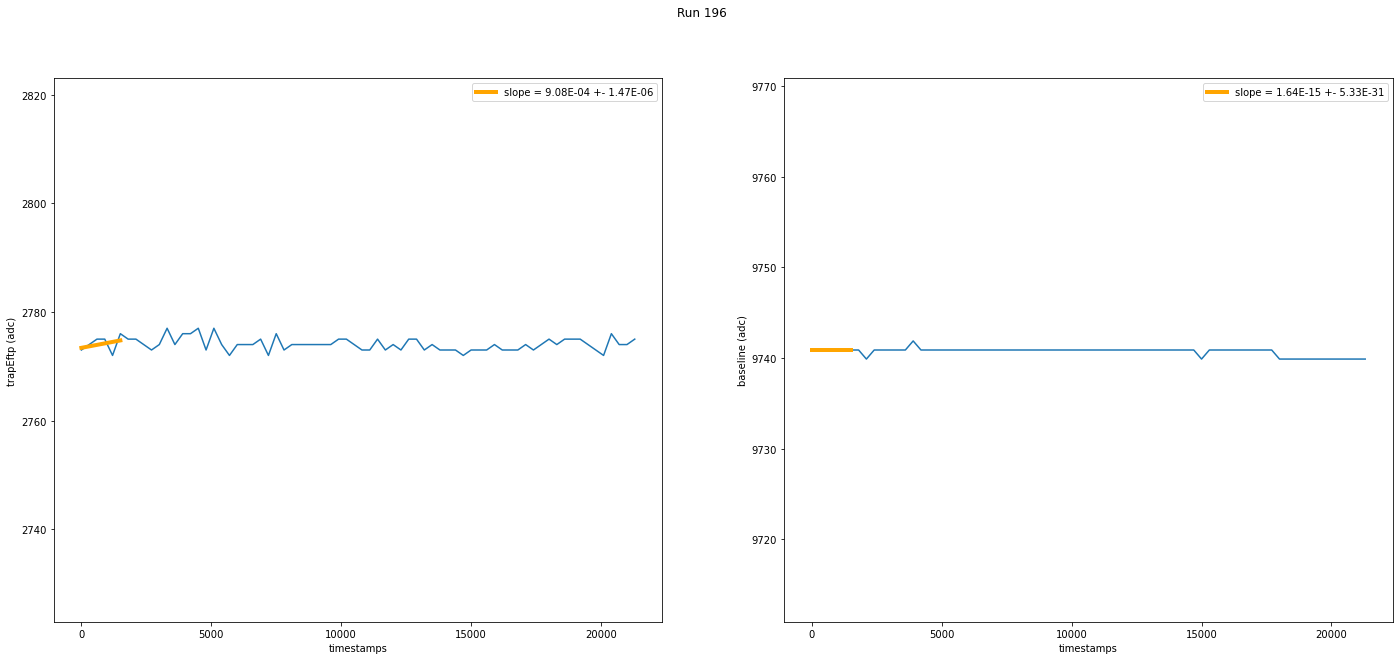

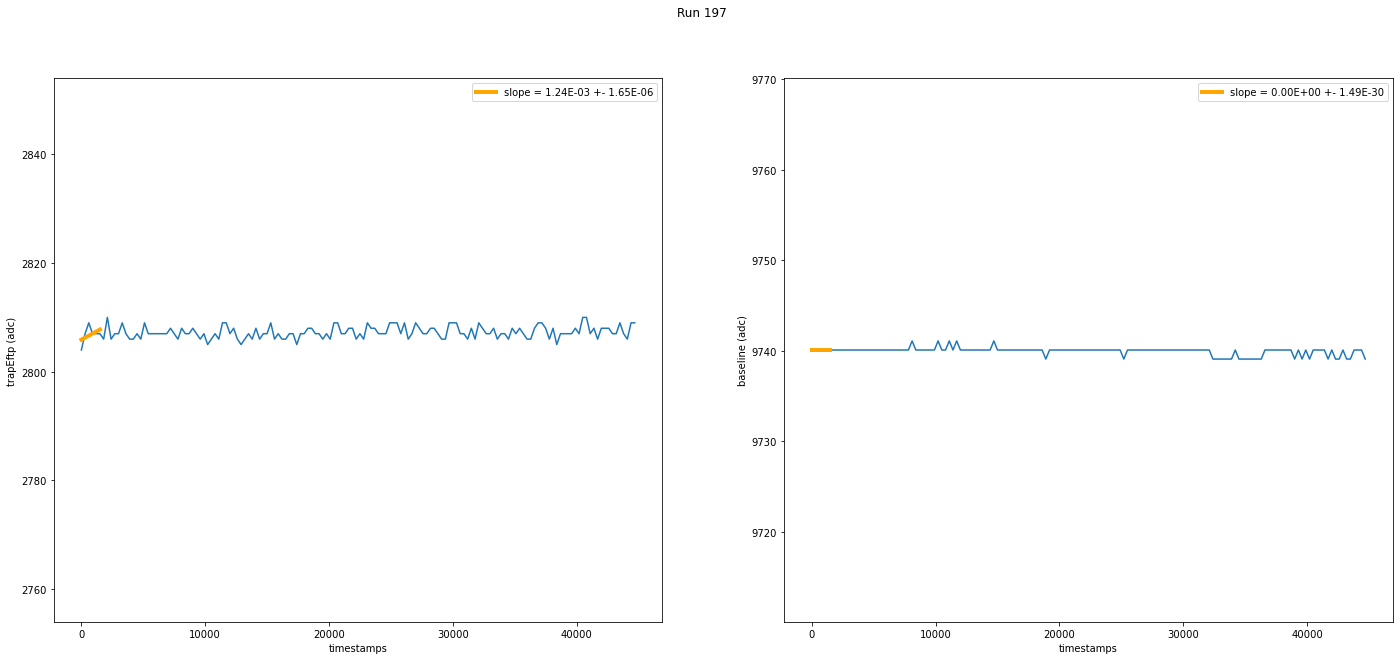

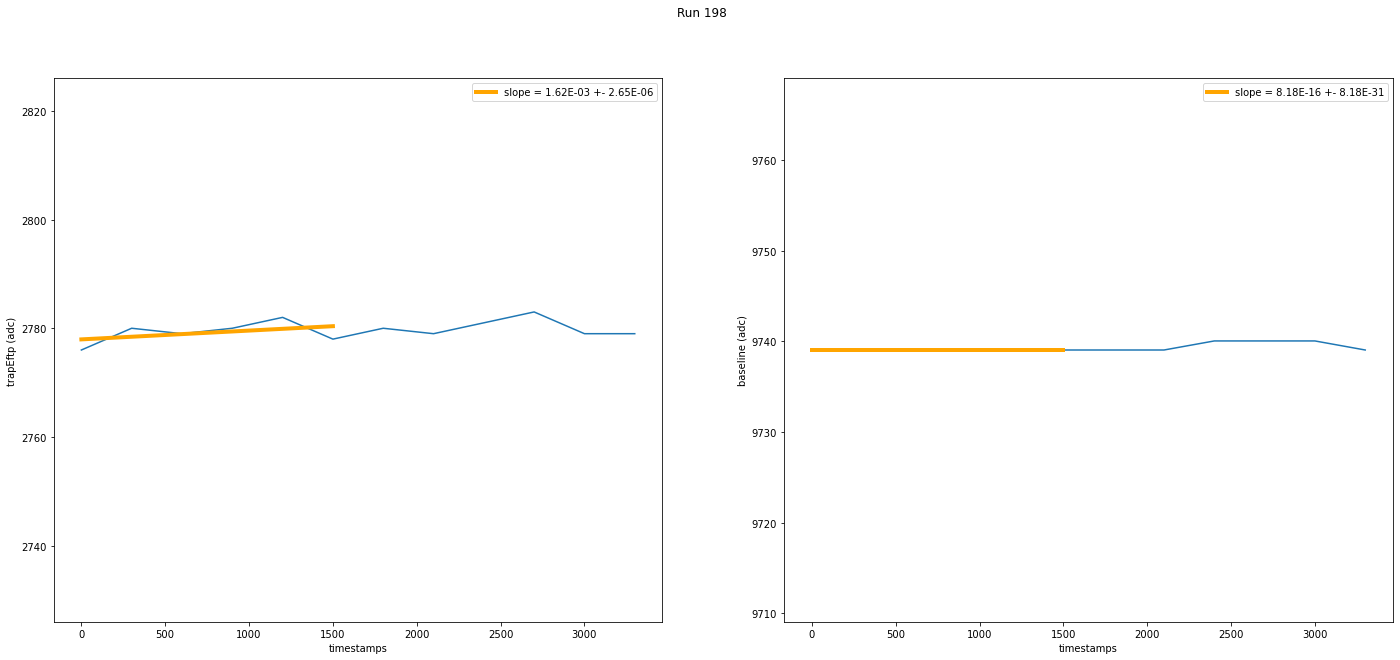

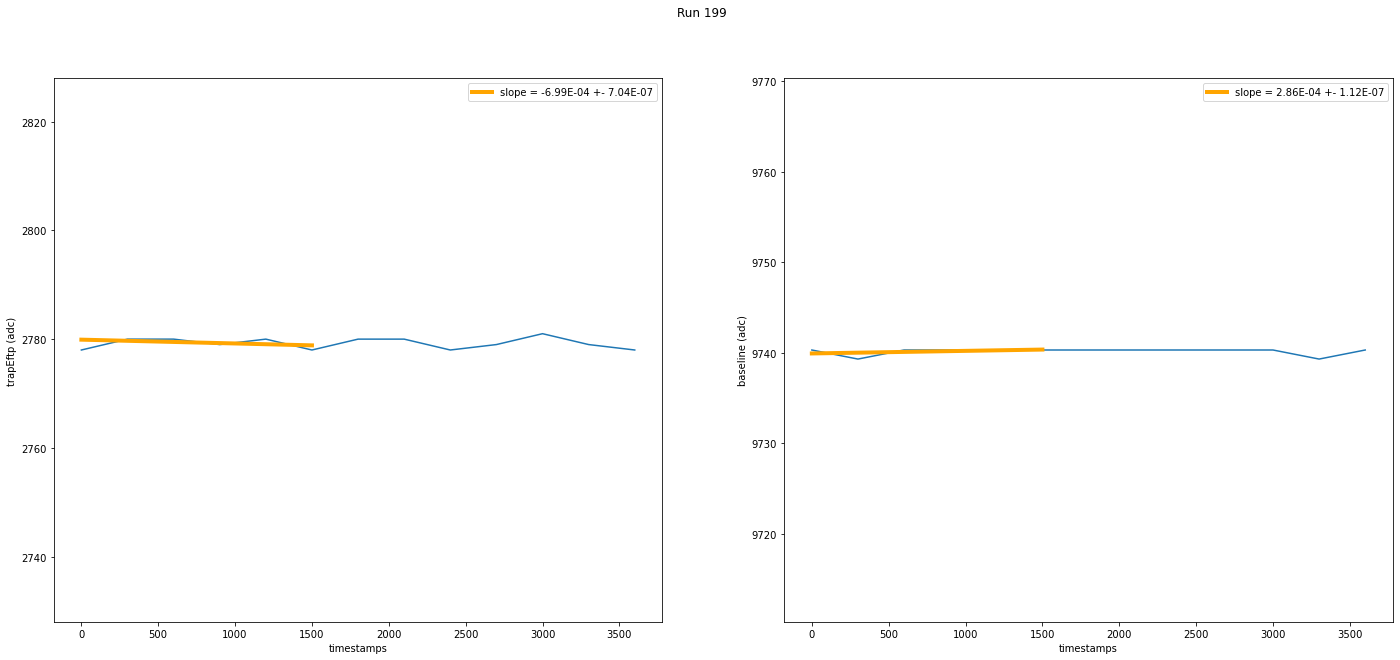

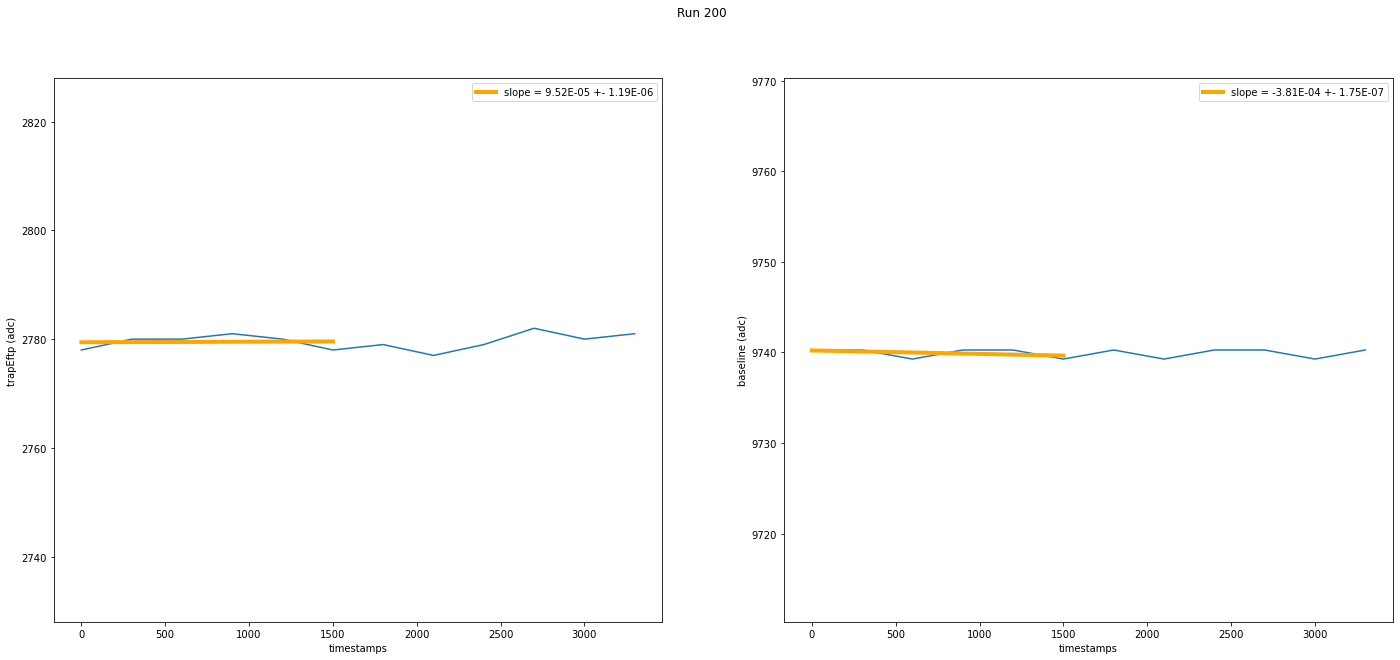

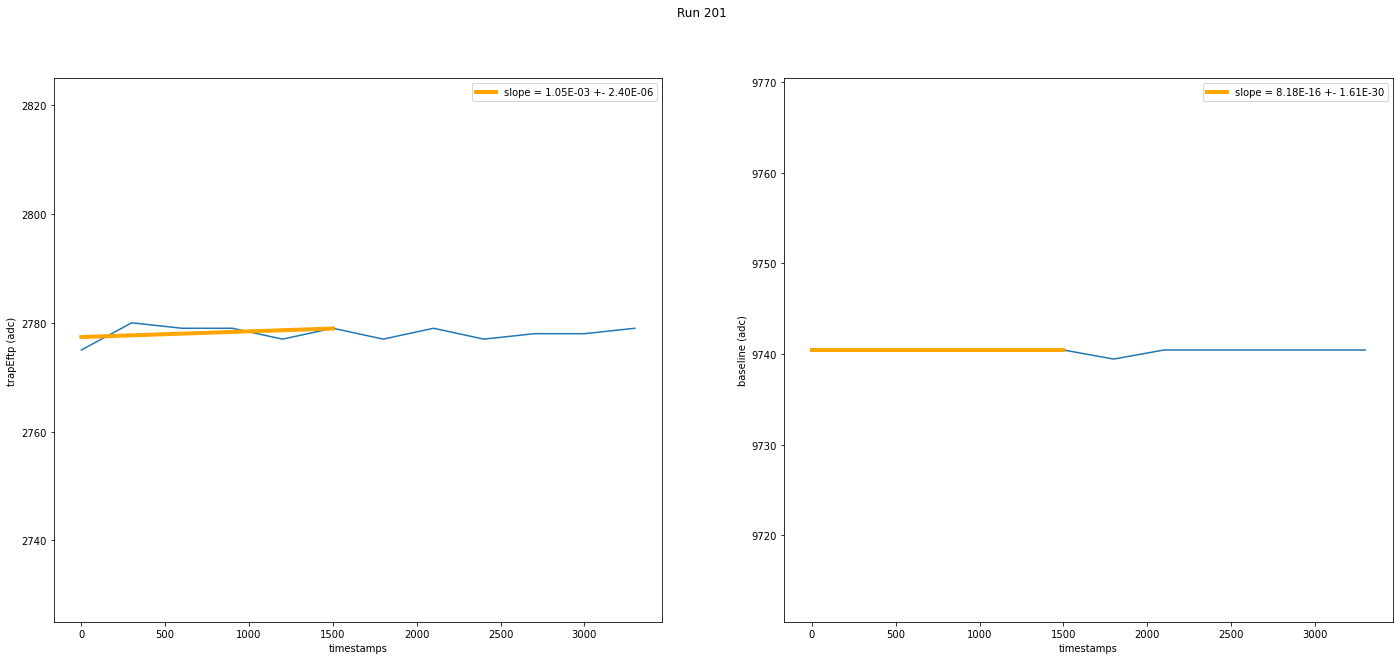

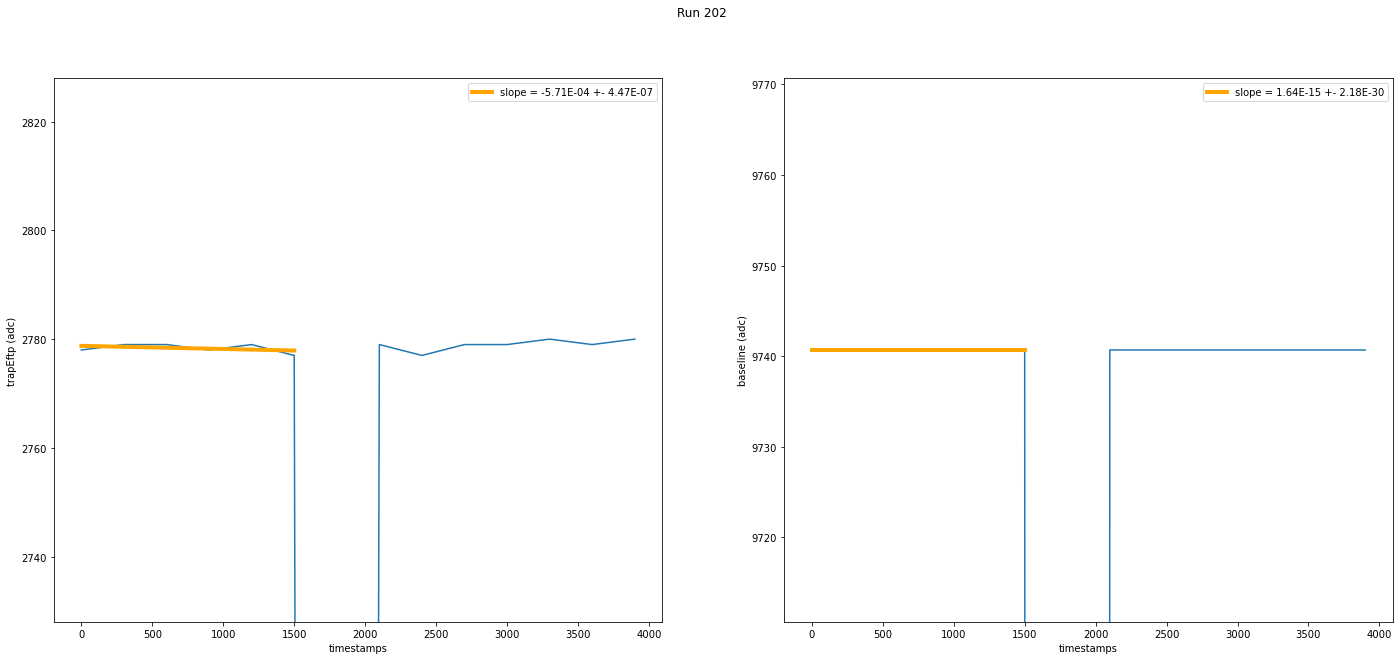

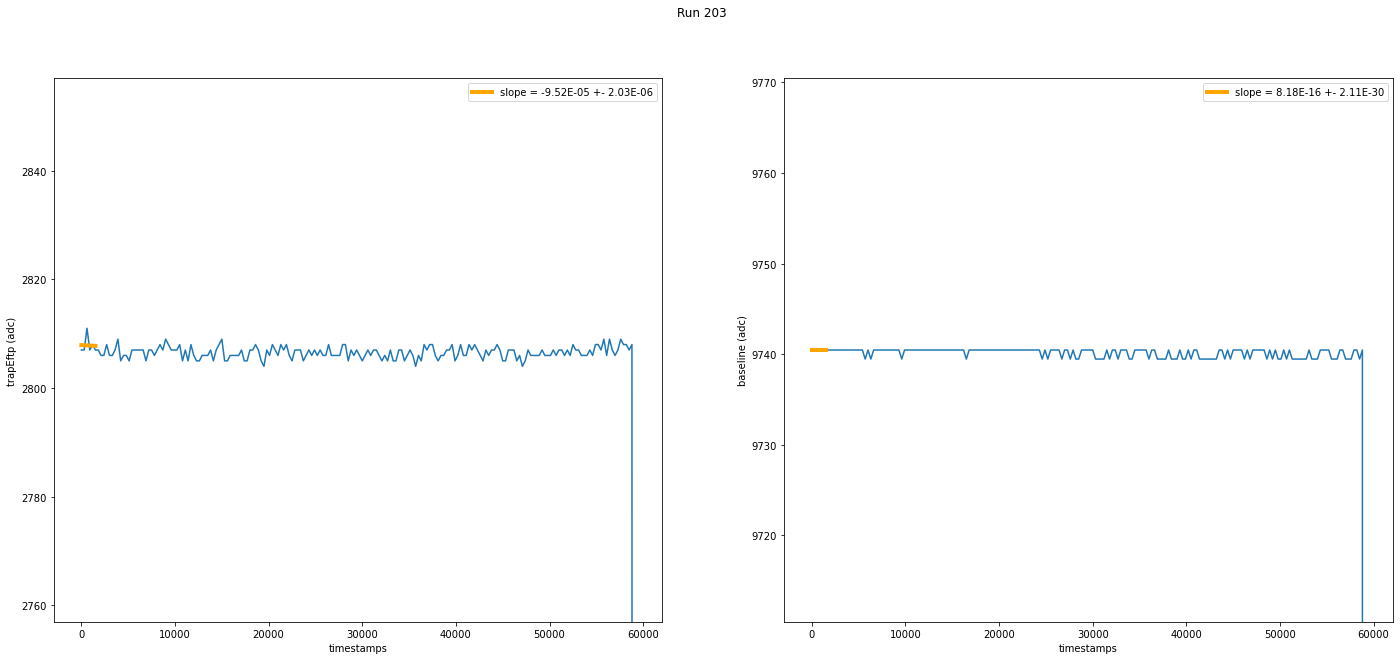

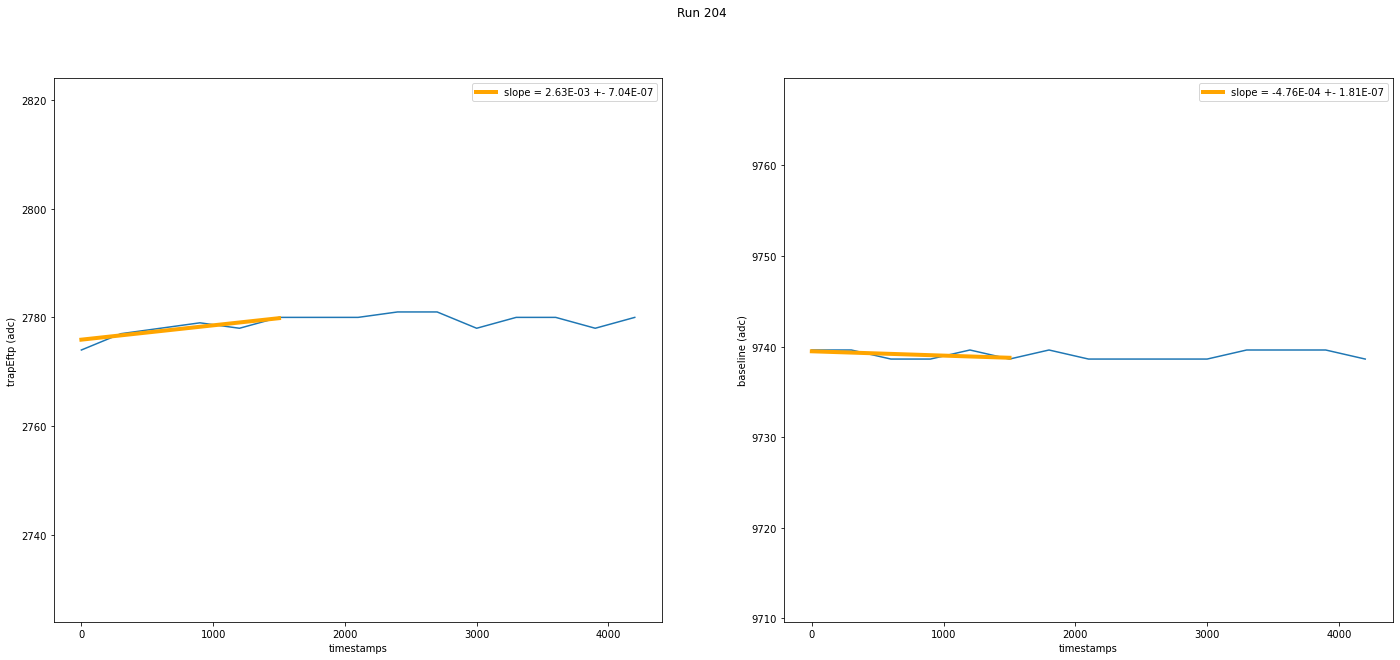

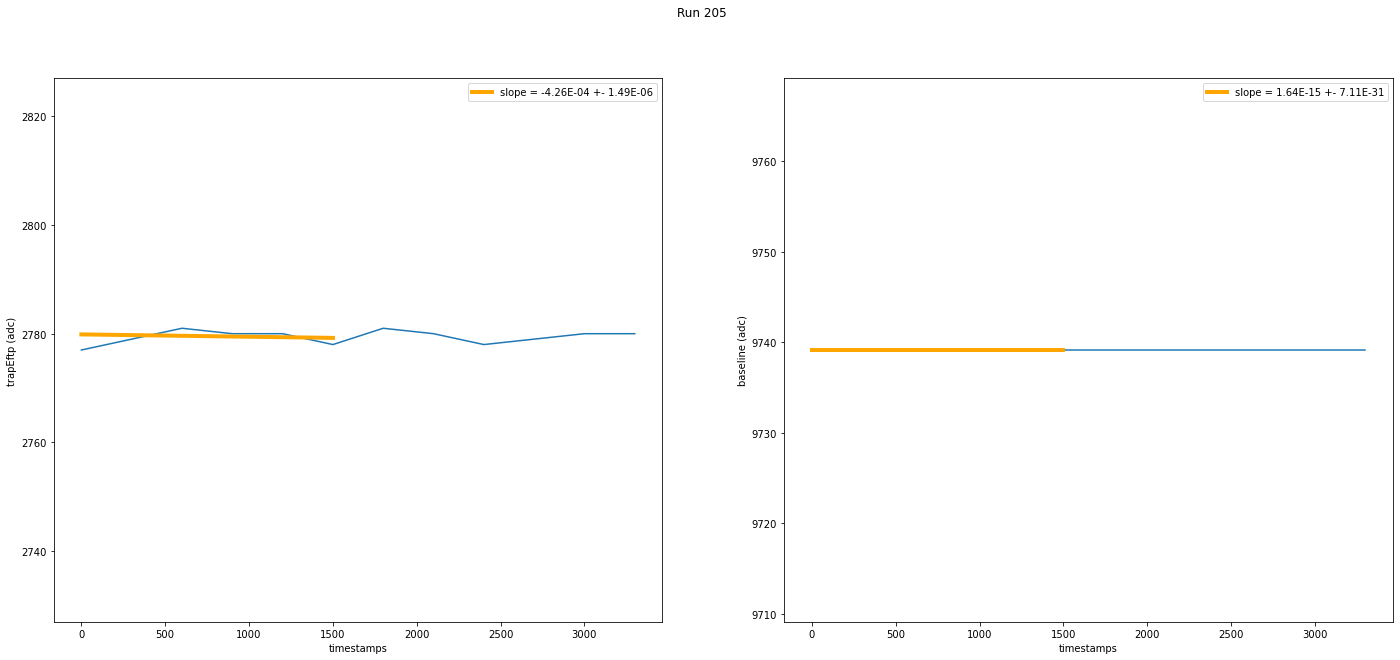

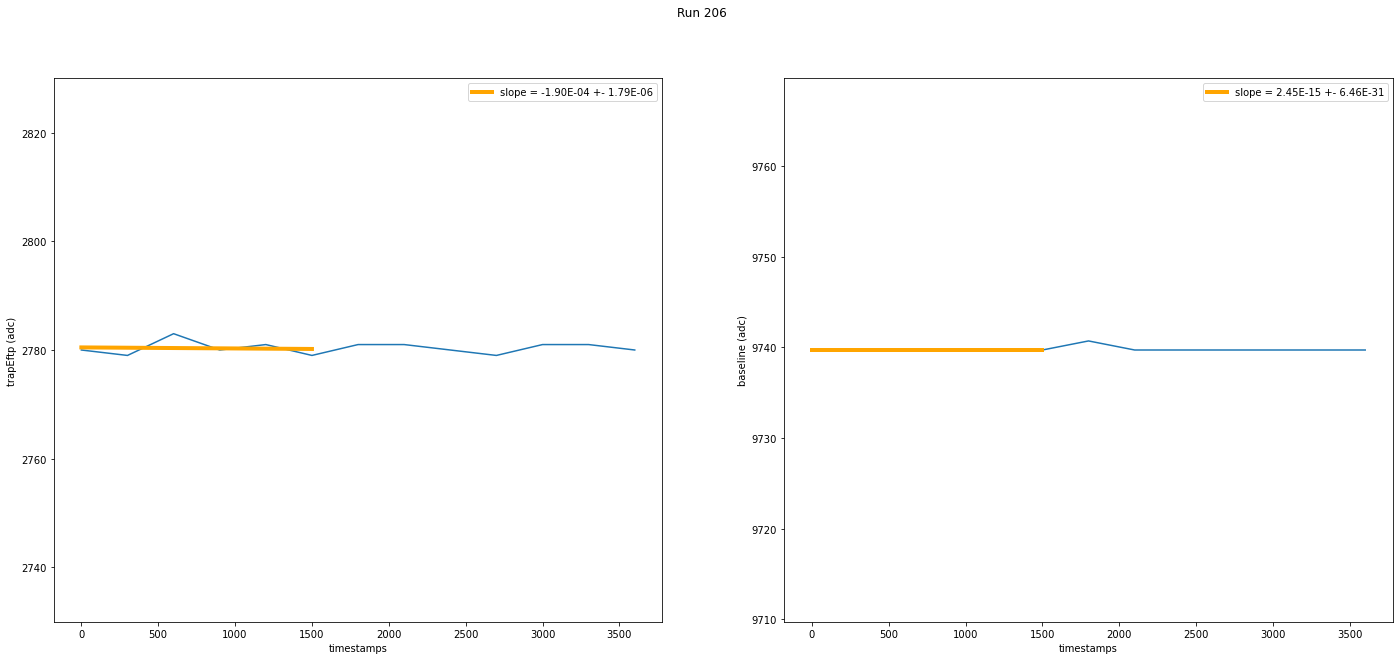

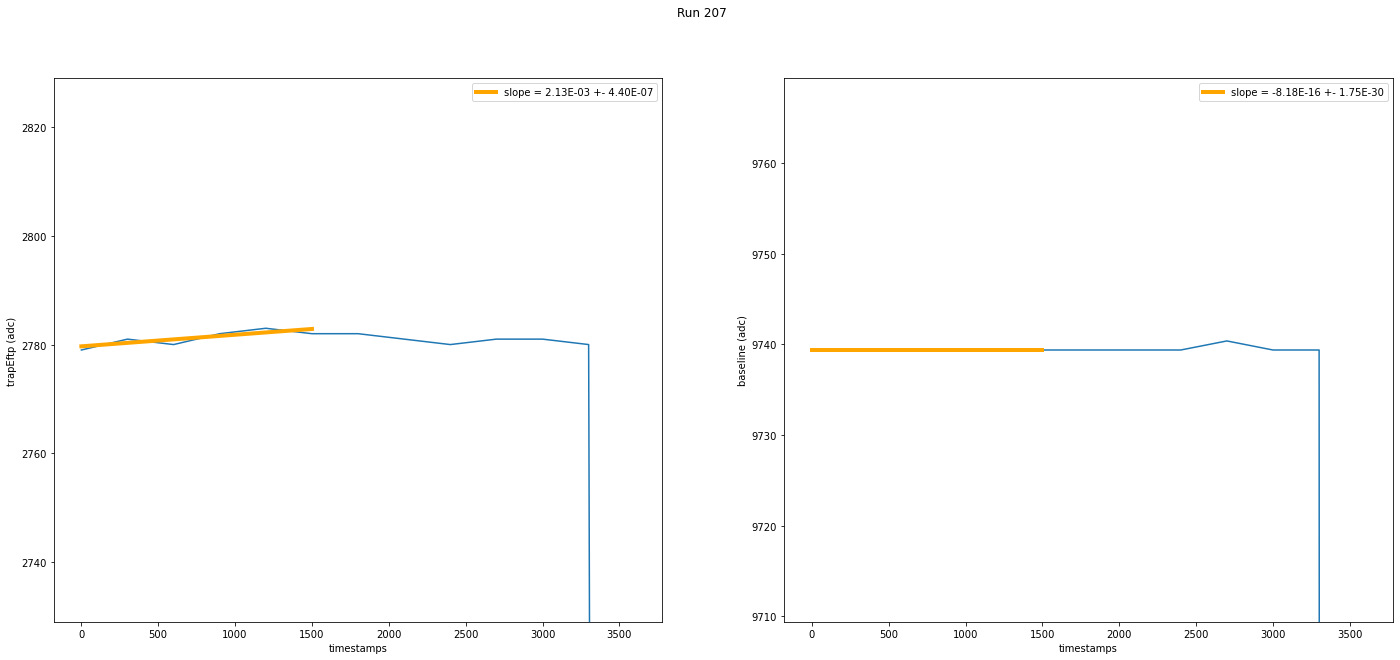

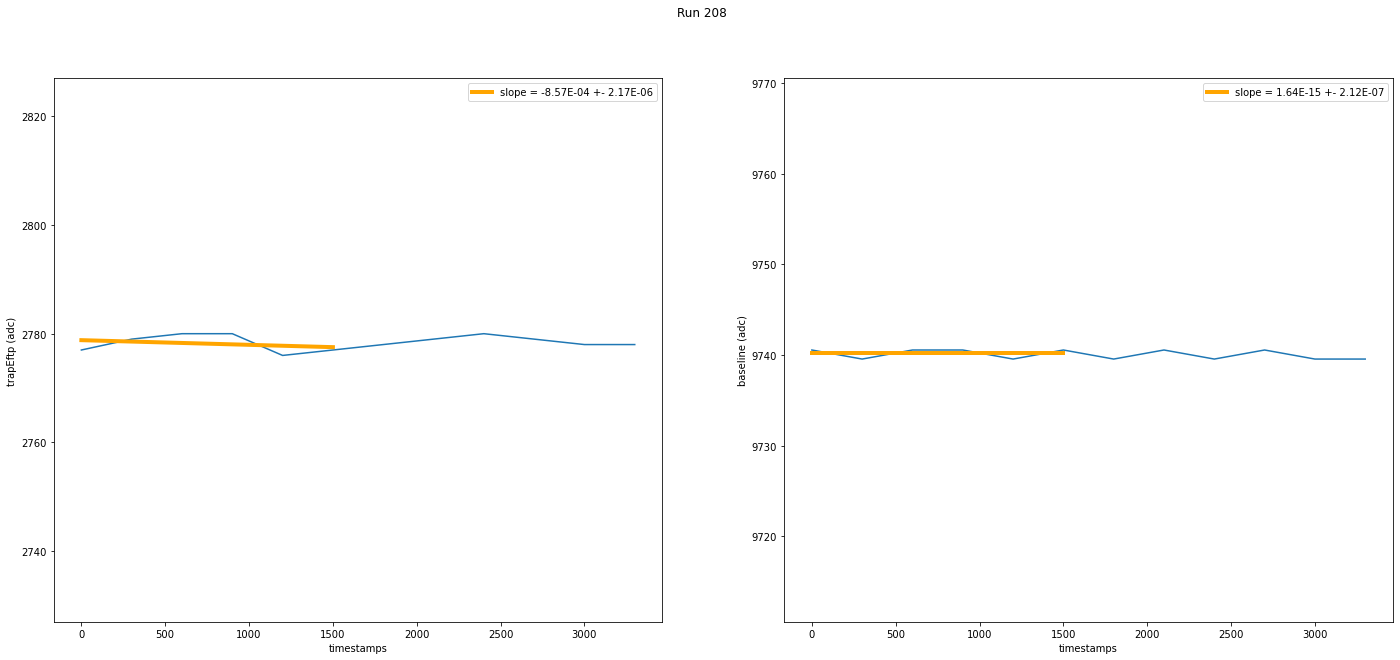

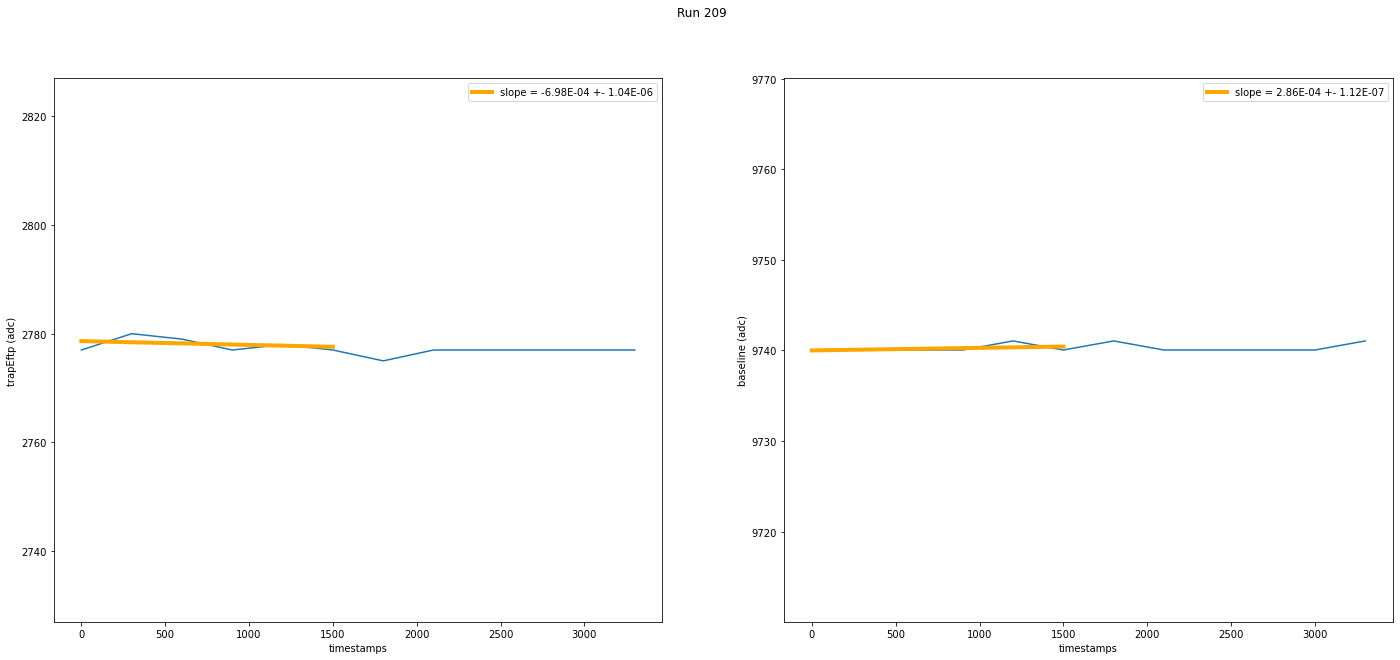

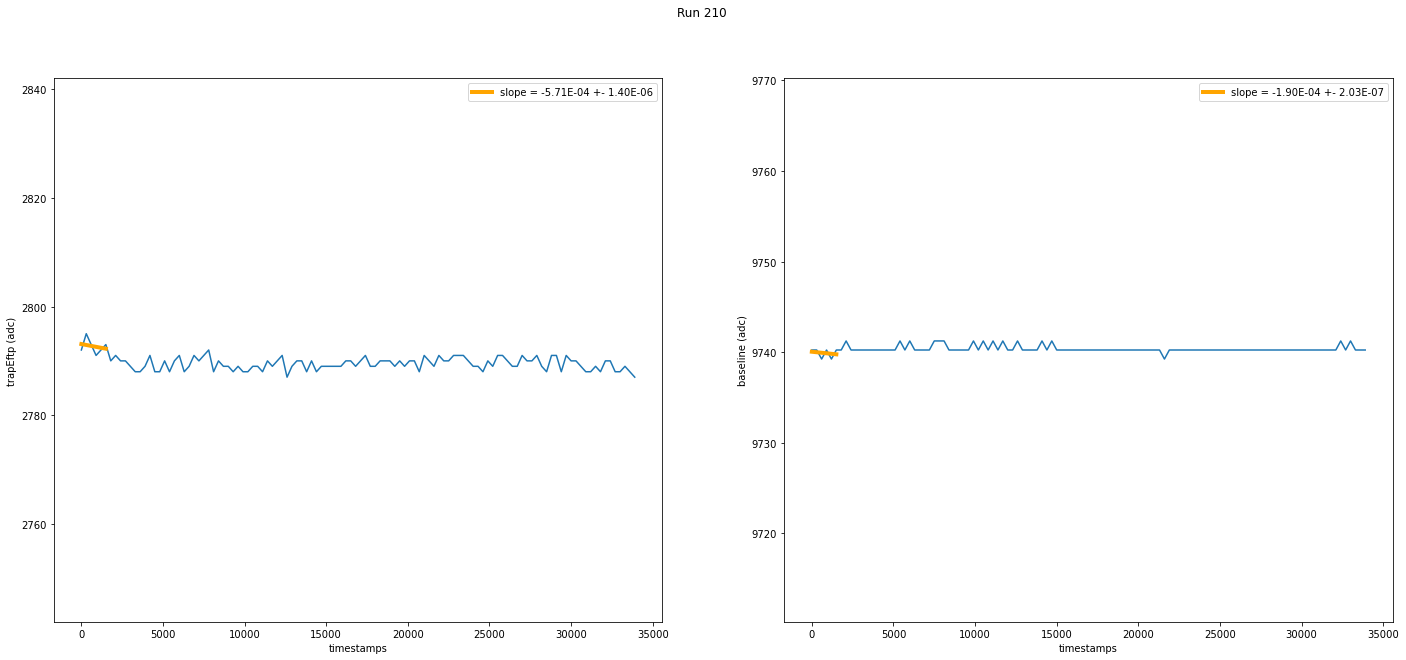


1460:  7.633507853404363 5.1417409503007825
Baseline:  1.4716348868312536e-12 0.0
[2777, 2779, 2777, 2777, 2777, 2778, 2779, 2777]
[9740.005859375, 9740.005859375, 9740.005859375, 9740.005859375, 9740.005859375, 9740.005859375, 9740.005859375, 9740.005859375]


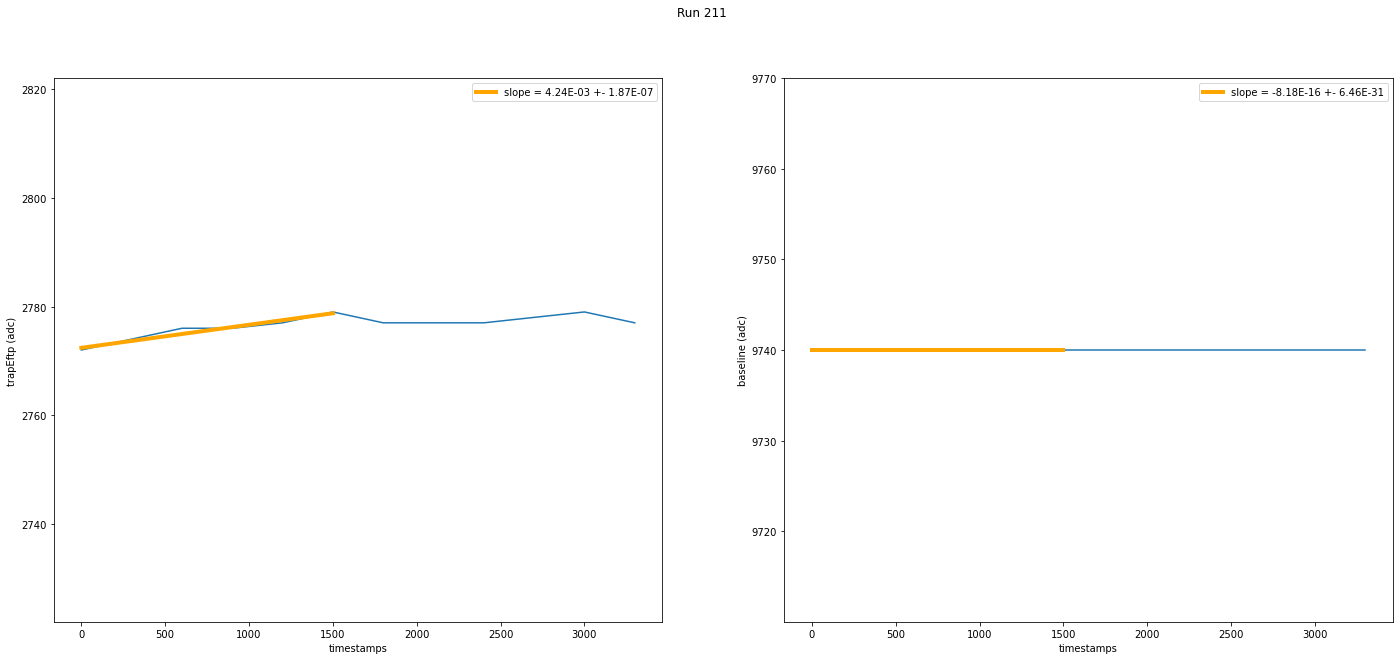

(211, (0.004240837696335757, 2772.3979057591623, 1.8677911485112888e-07), (-8.175749371284742e-16, 9740.005859374996, 6.460133442951217e-31))


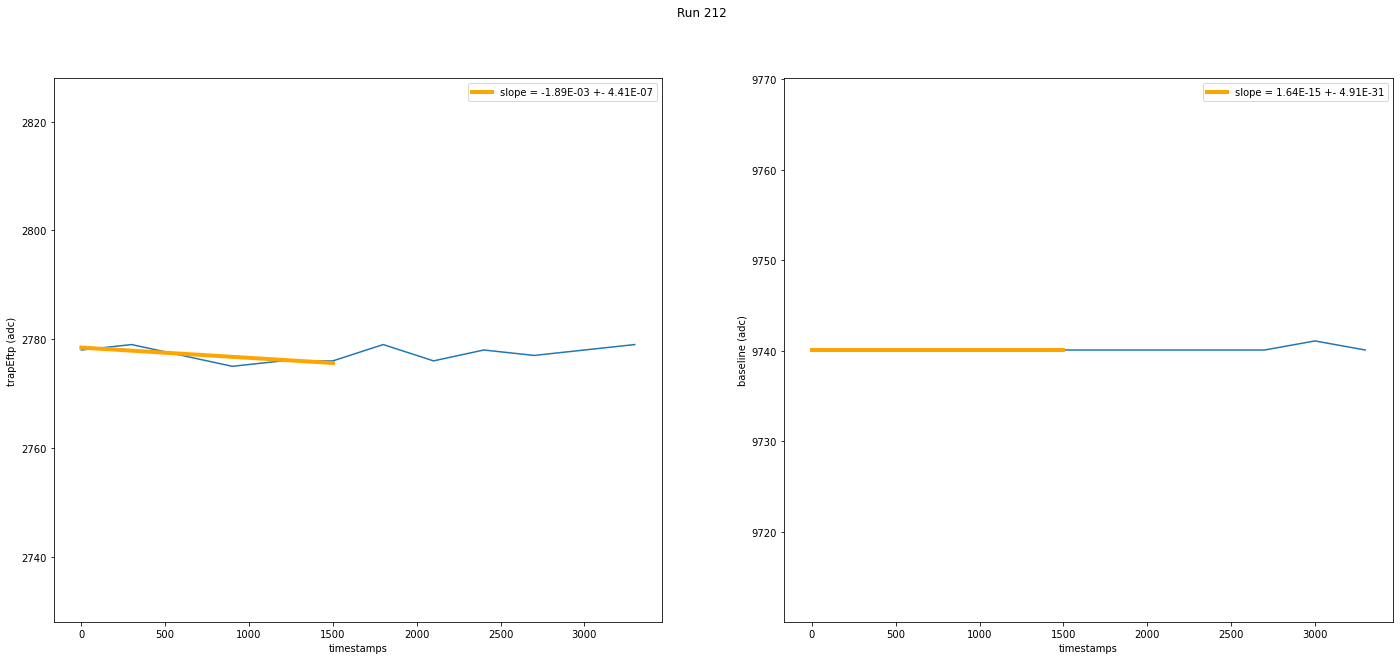

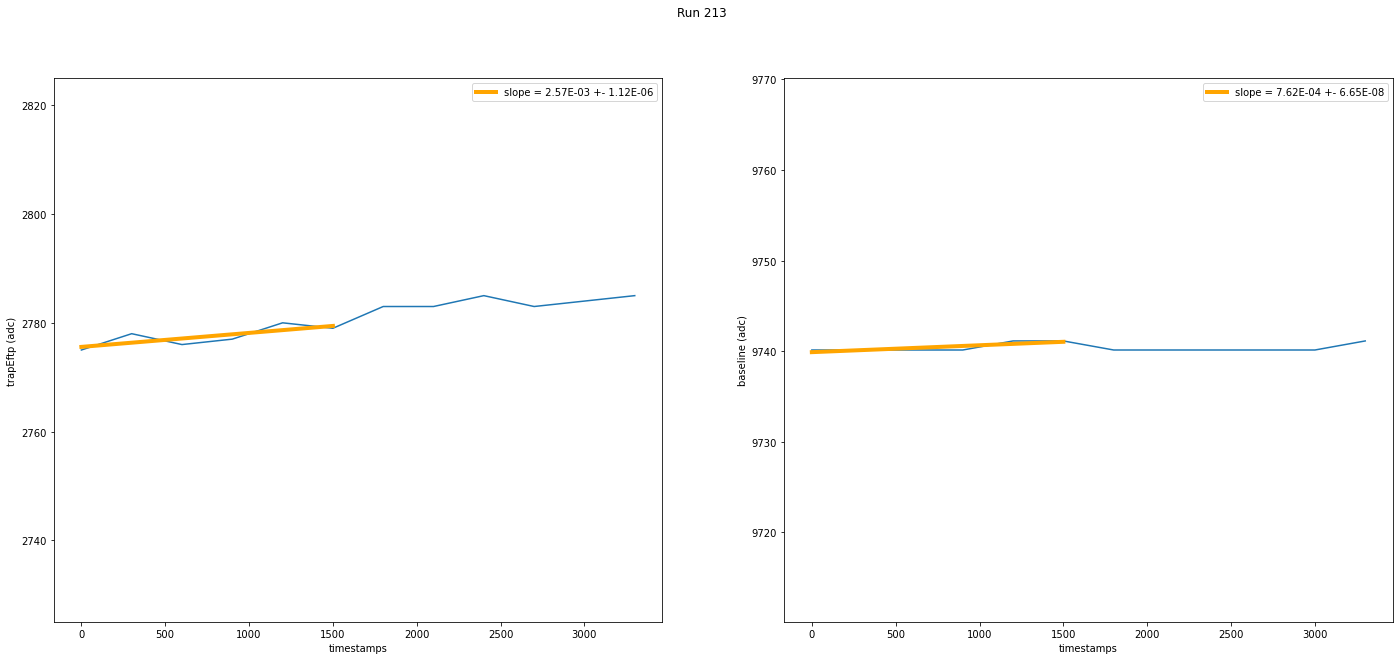

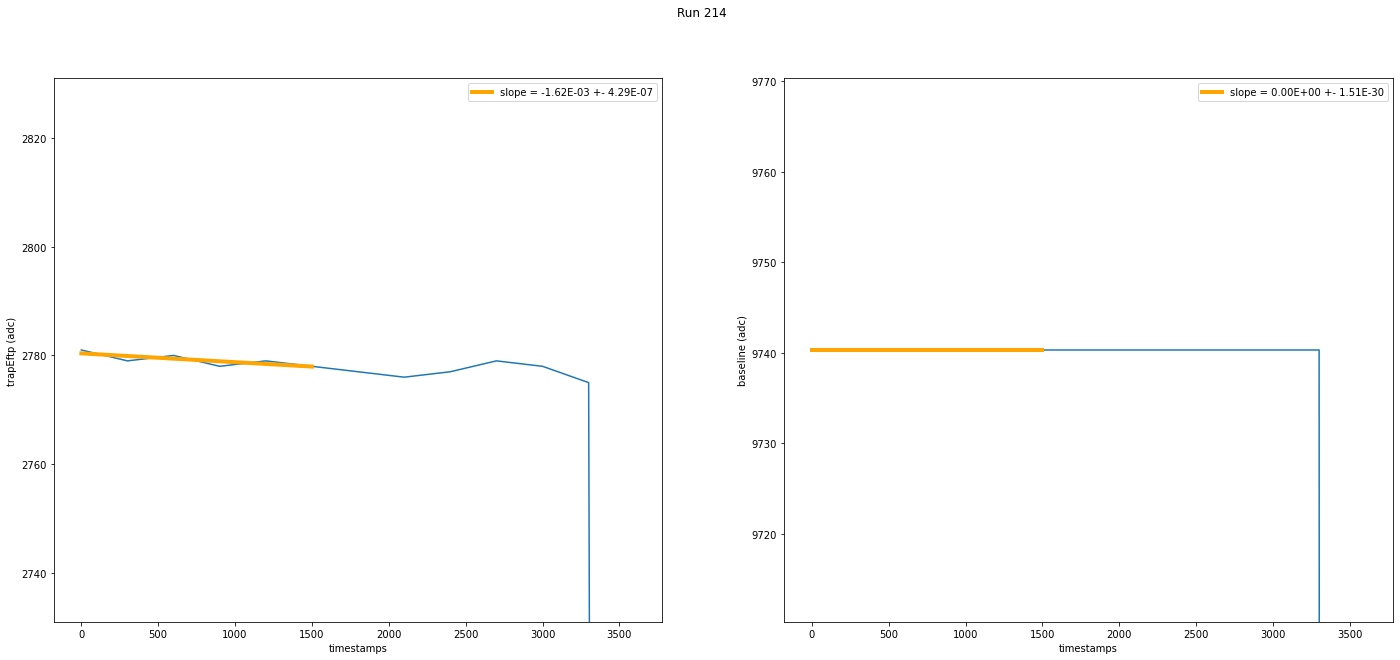

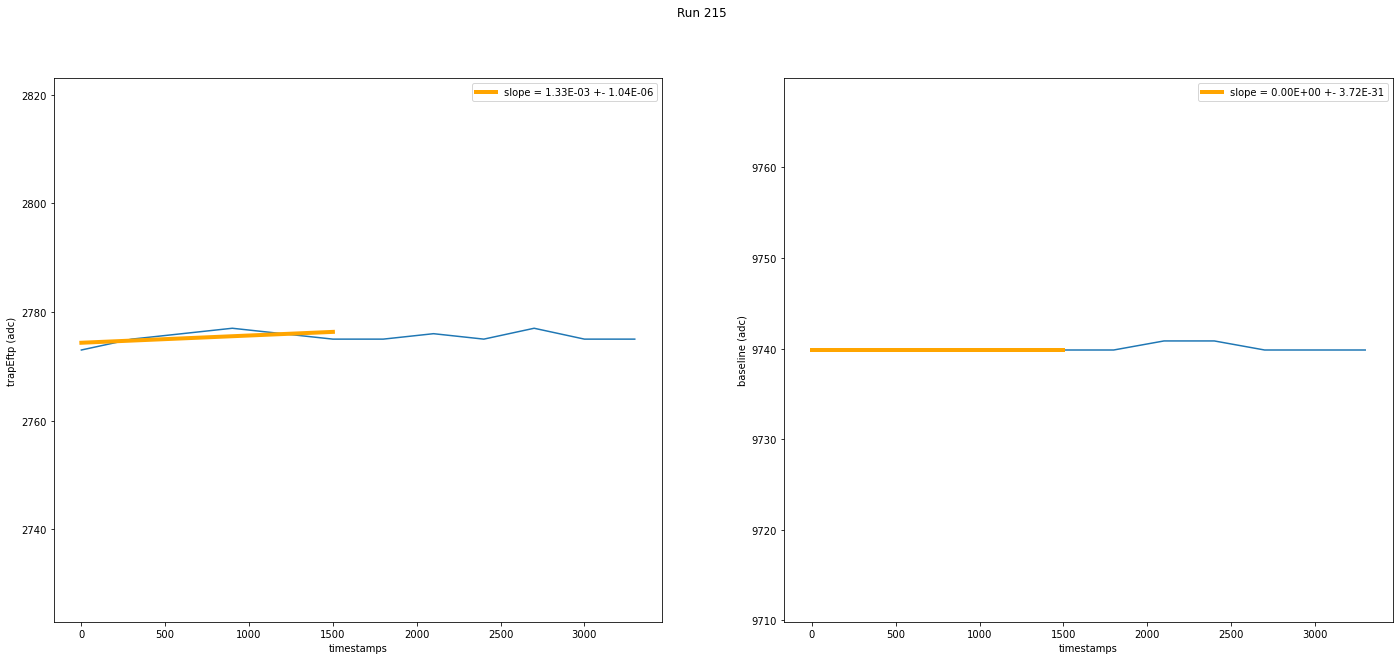

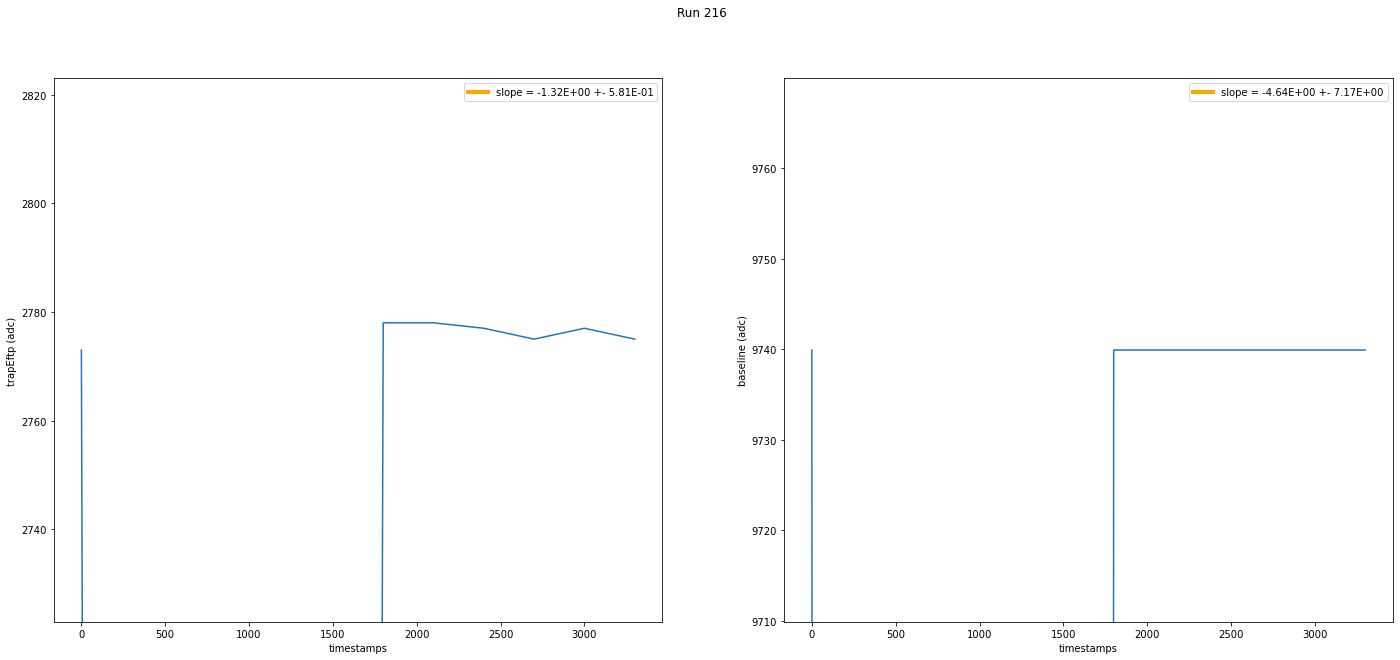

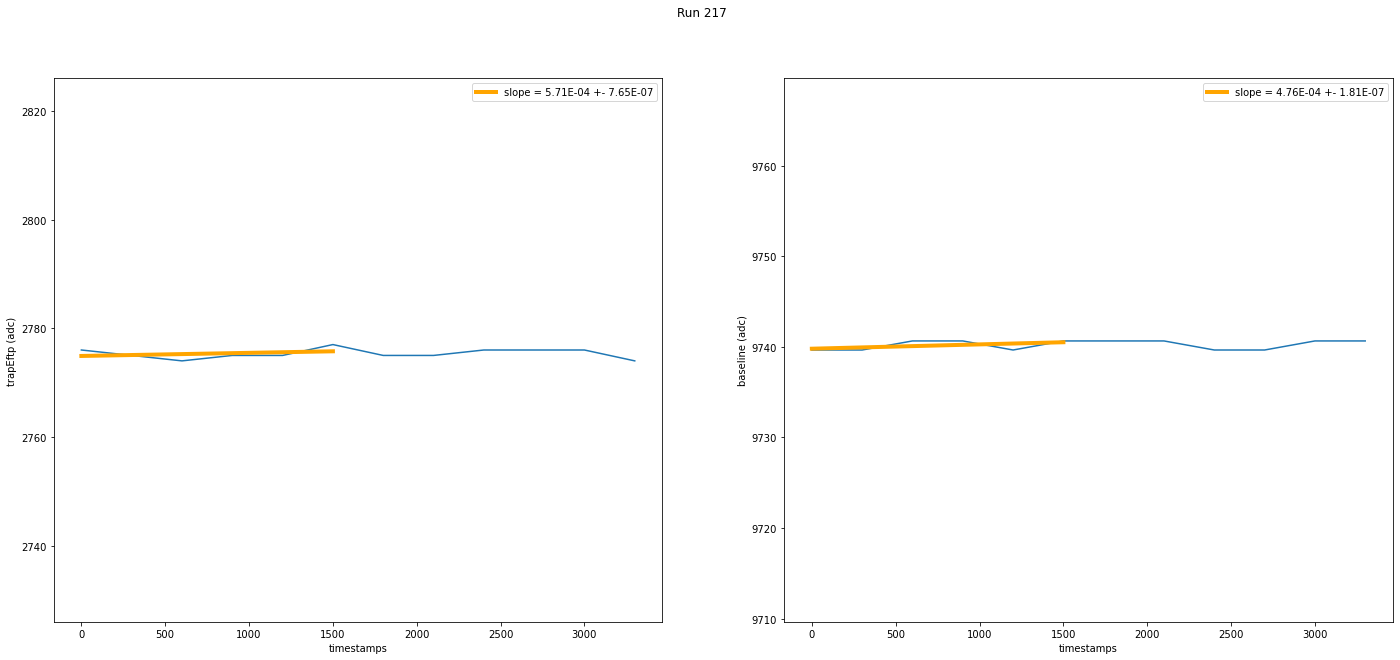

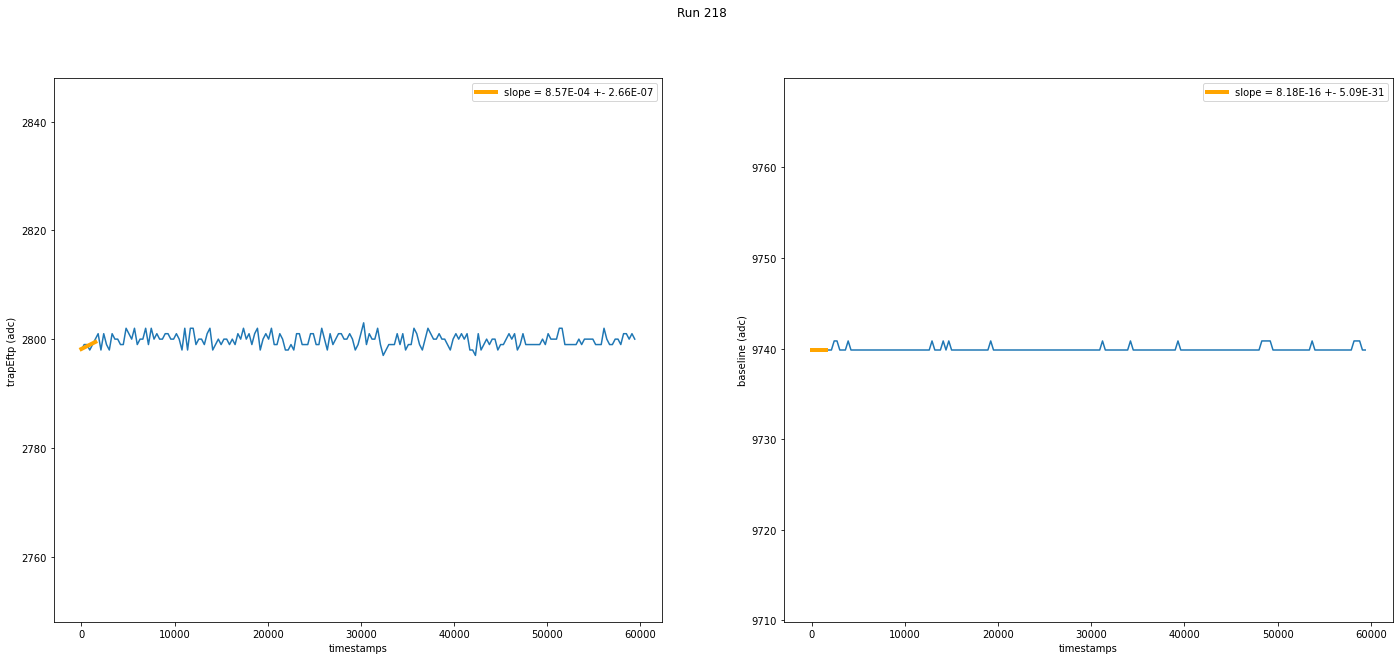

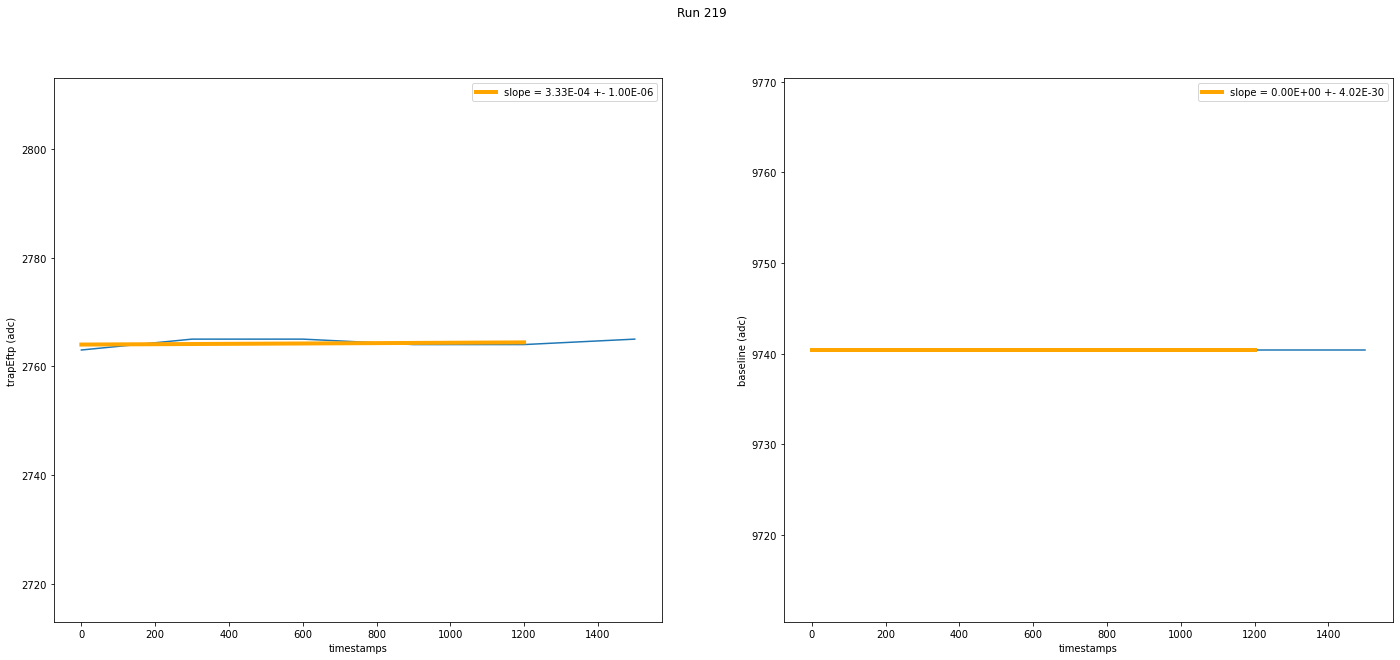

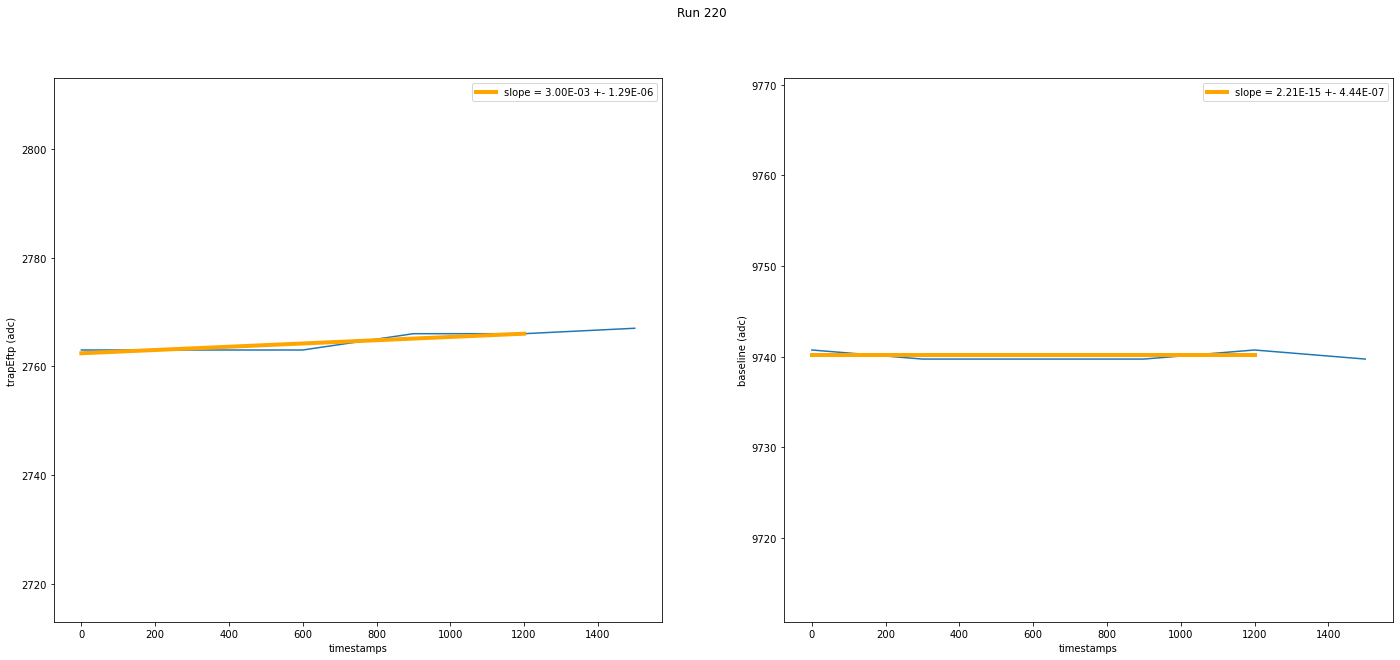

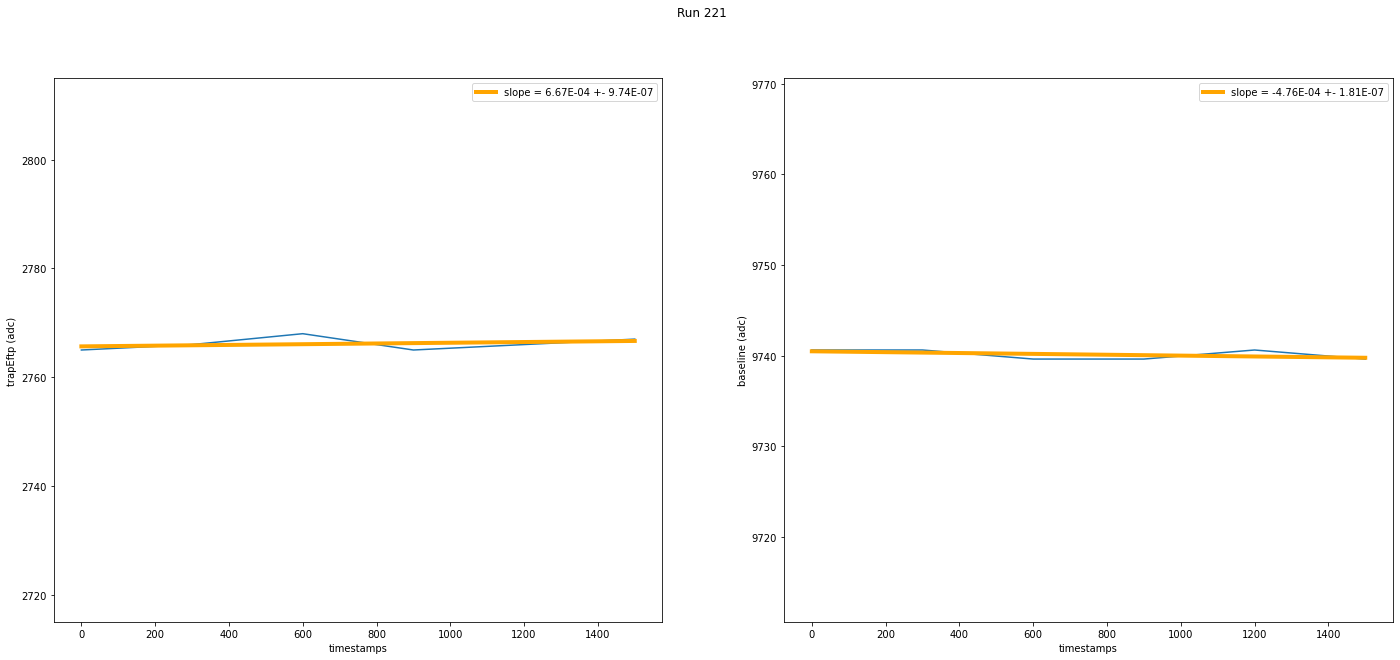


1460:  3.598000000000807 2.598076211353316
Baseline:  1.1993333333310654 3.0


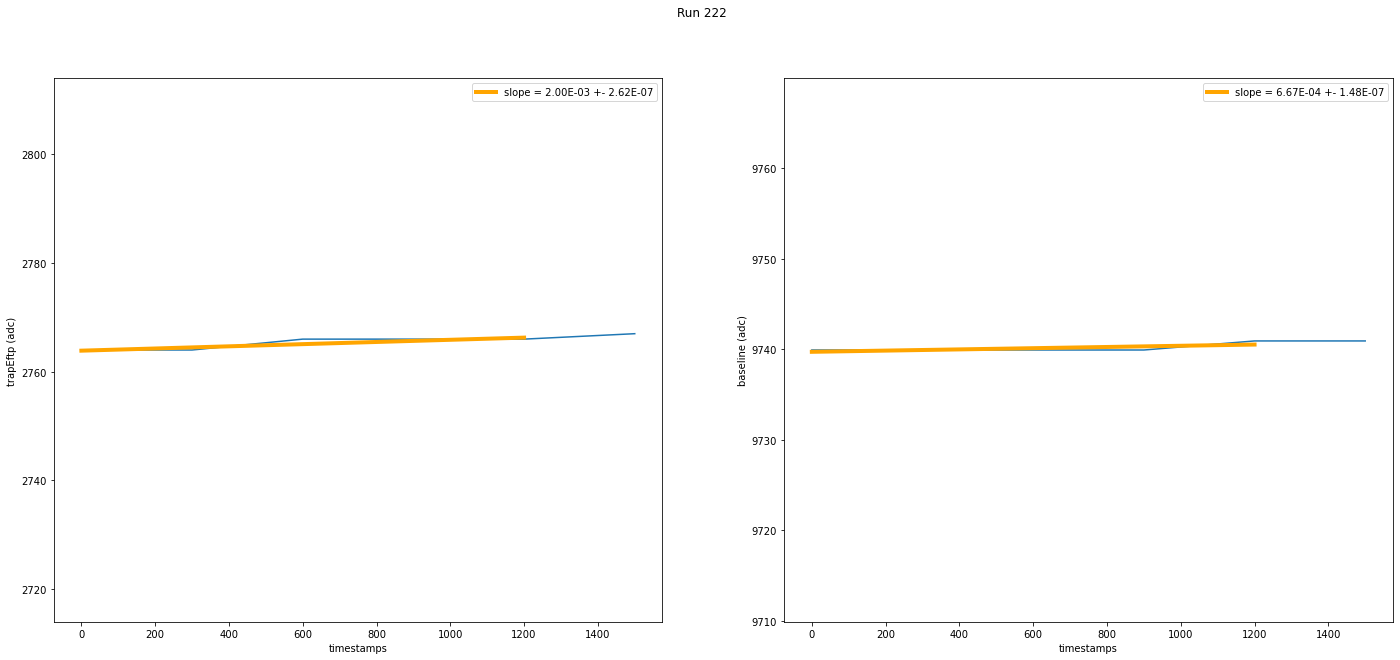

(222, (0.0020000000000004485, 2763.876923076922, 2.6210826210803196e-07), (0.0006666666666654059, 9739.705273437496, 1.4814814814790335e-07))


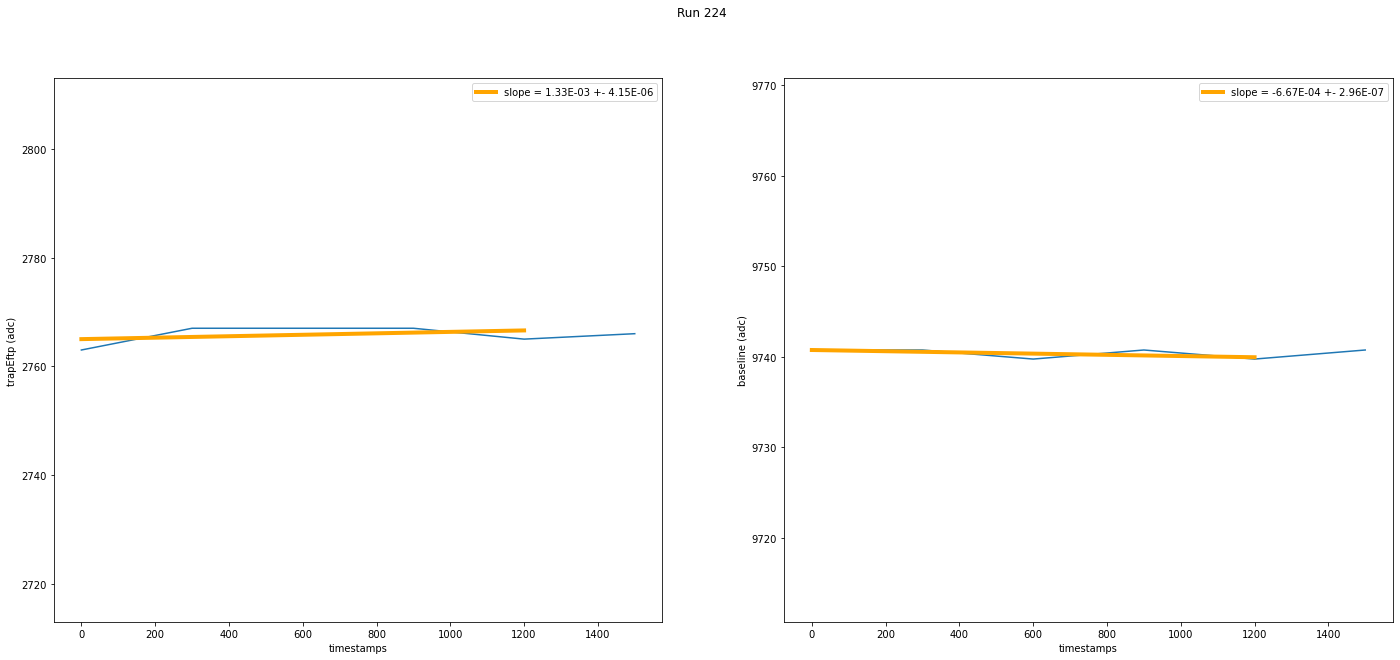


1460:  9.589333333336285 4.9749371855331
Baseline:  1.9903890529739003e-12 0.0
[2778, 2779, 2778, 2780]
[9739.8095703125, 9739.8095703125, 9739.8095703125, 9739.8095703125]


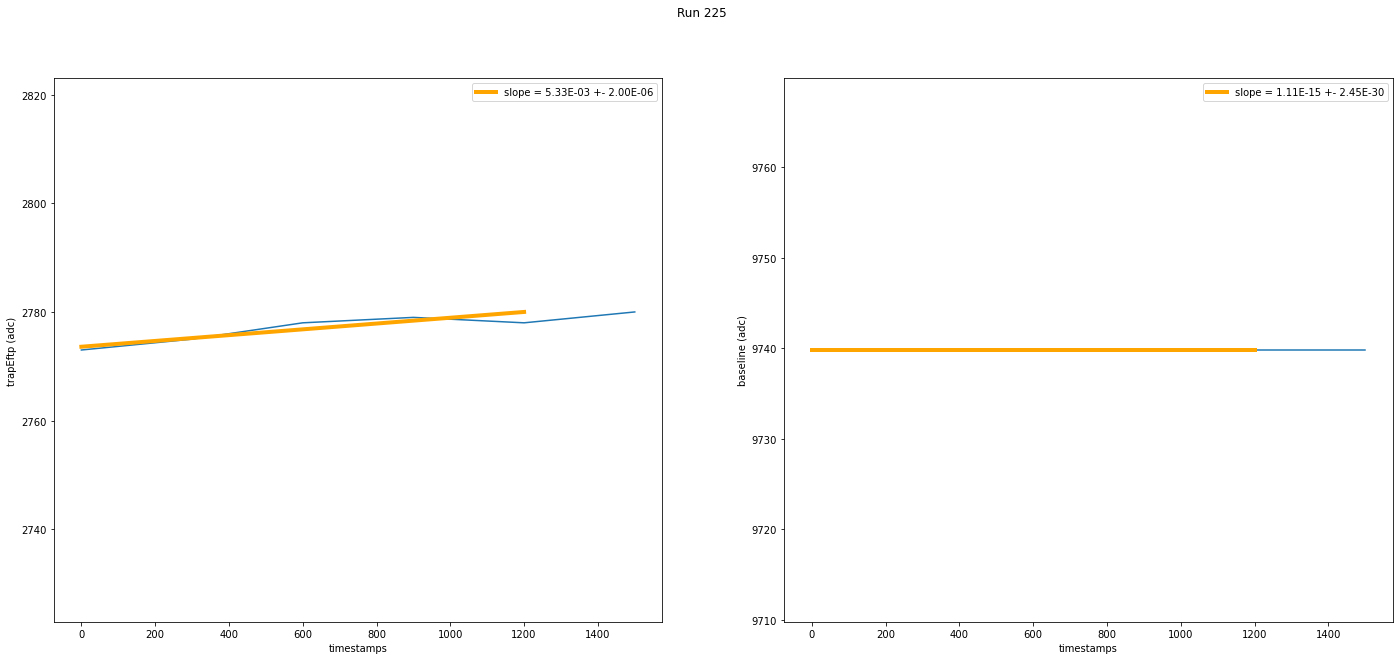

(225, (0.005333333333334974, 2773.599999999999, 1.9999999999999135e-06), (1.1070016979832593e-15, 9739.809570312496, 2.4459914423519976e-30))


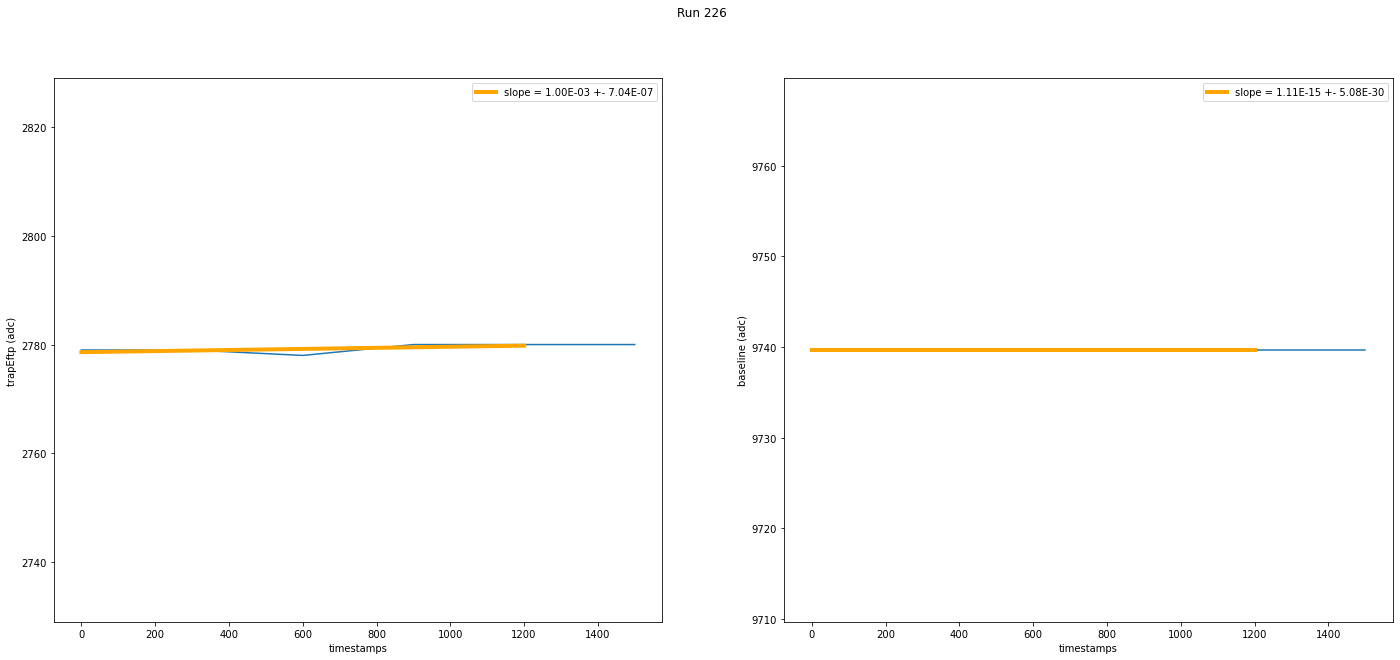

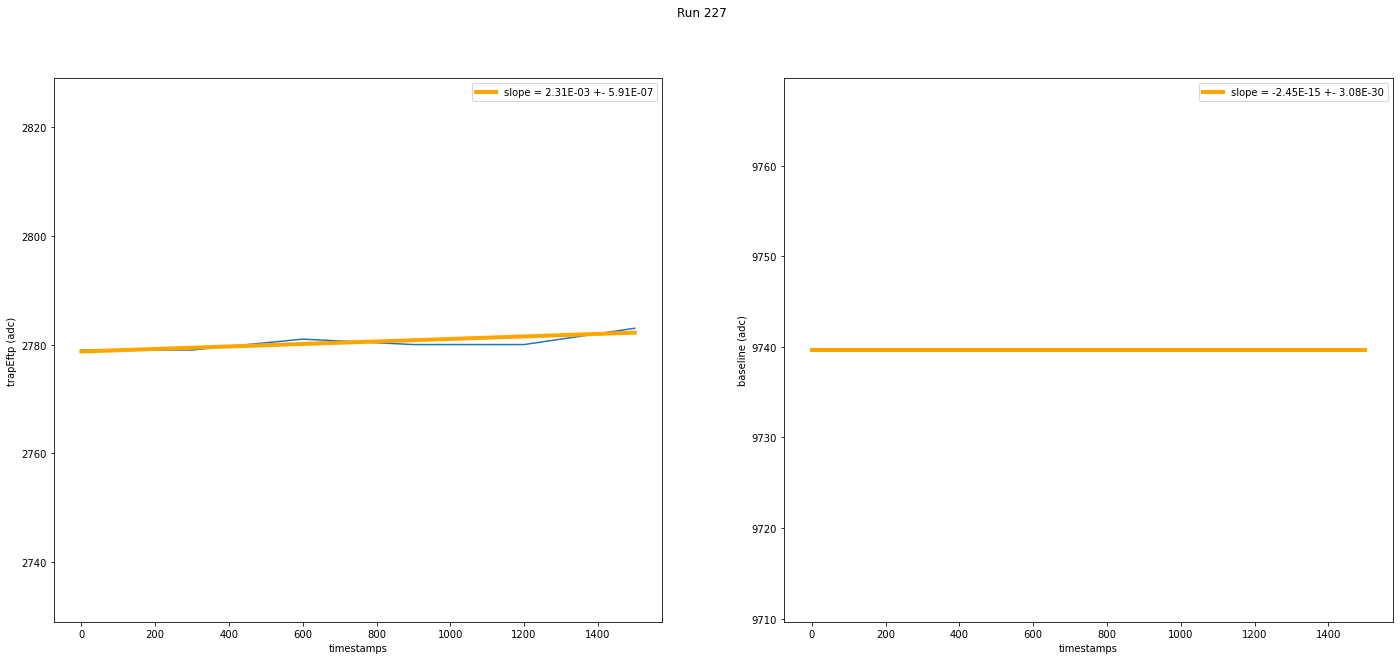

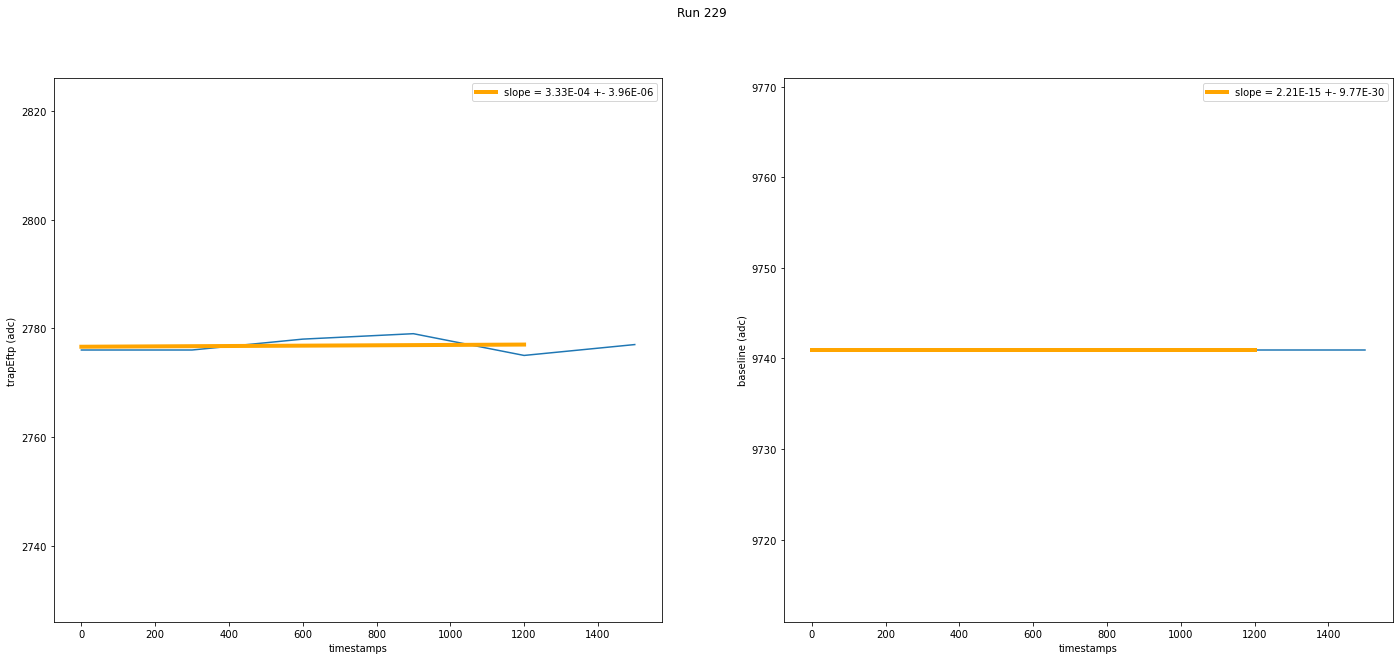

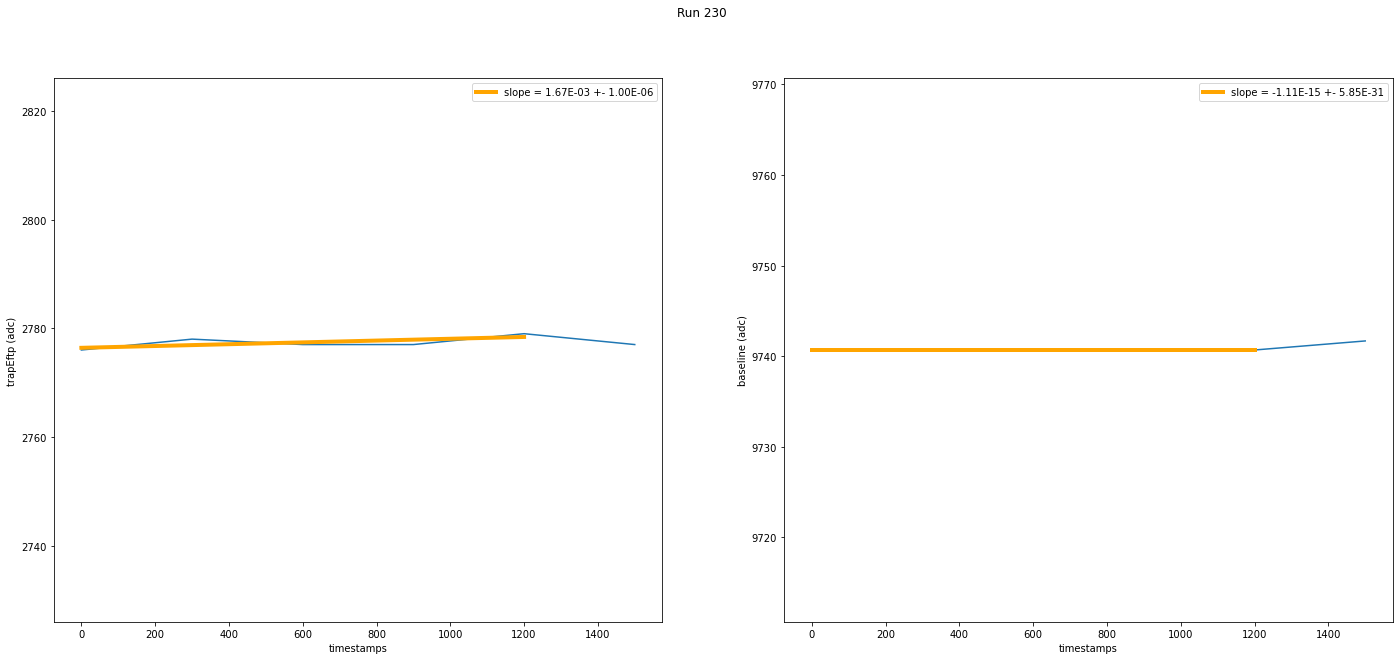

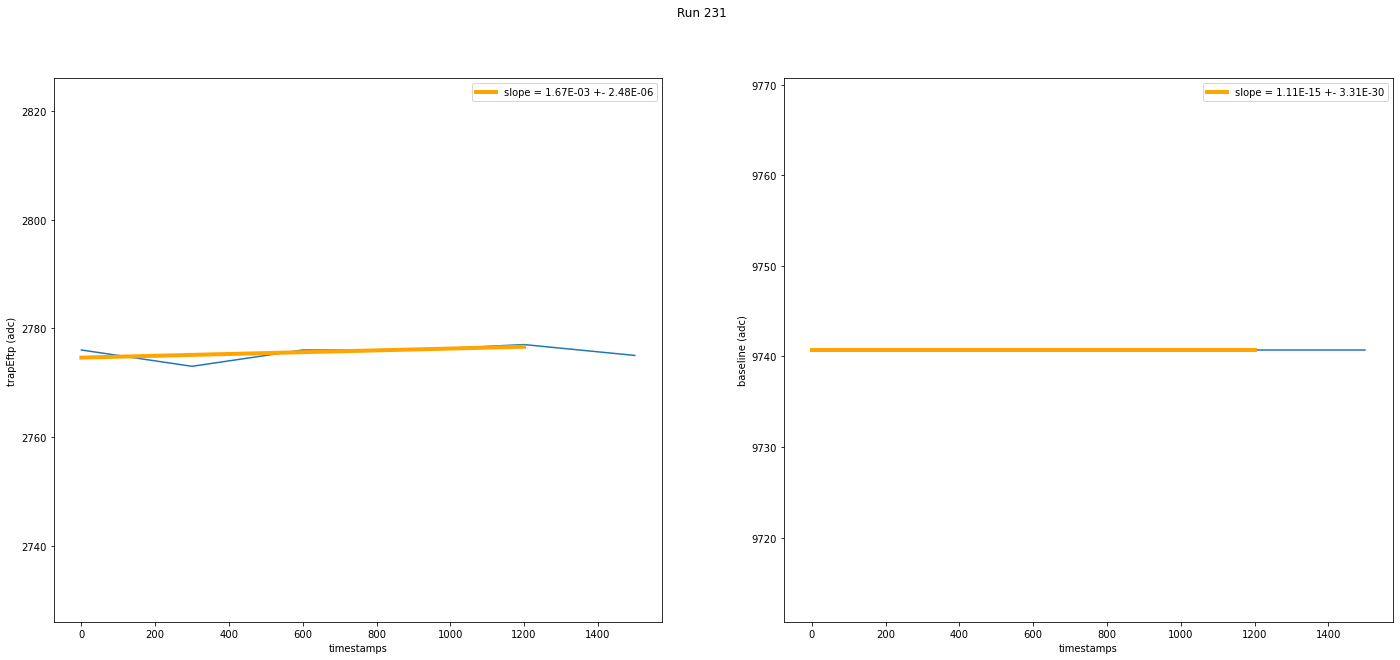

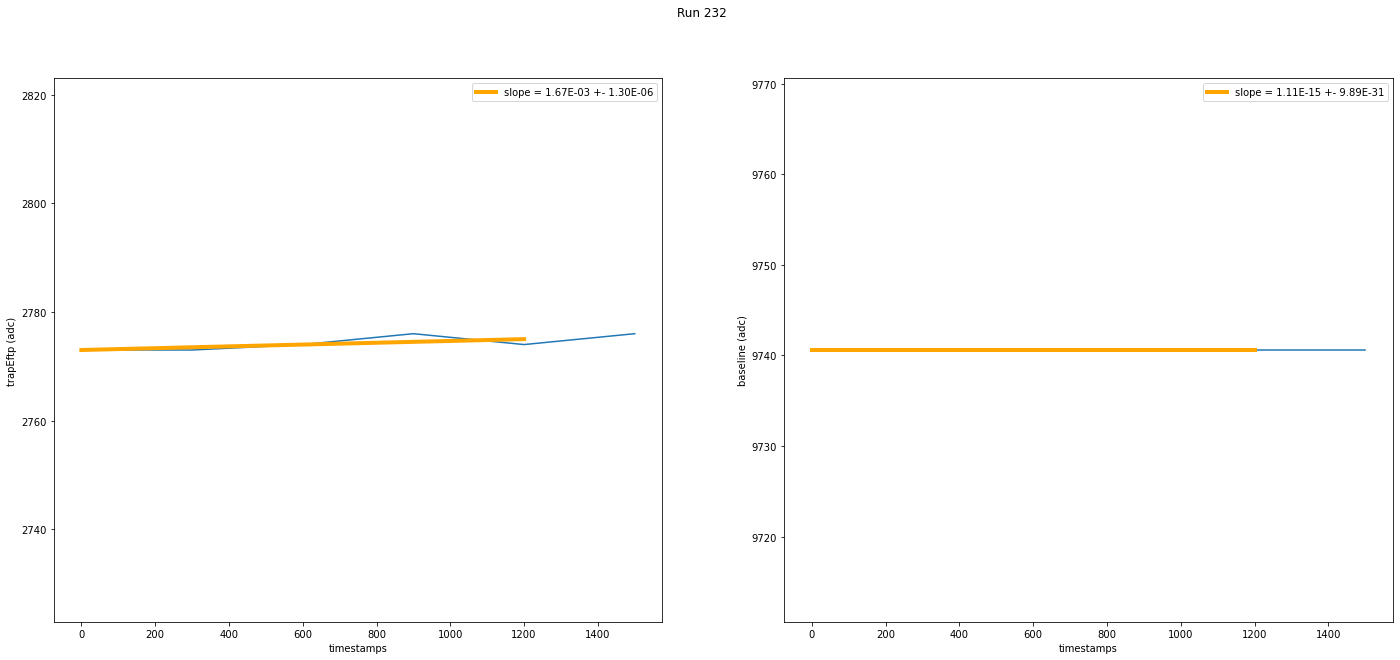

In [119]:
for i in range(110,234):
    try:
        d = find_drifts(dg, i, dsp_dir, True, False)
        print(*d, sep = "\n")
    except:
        continue

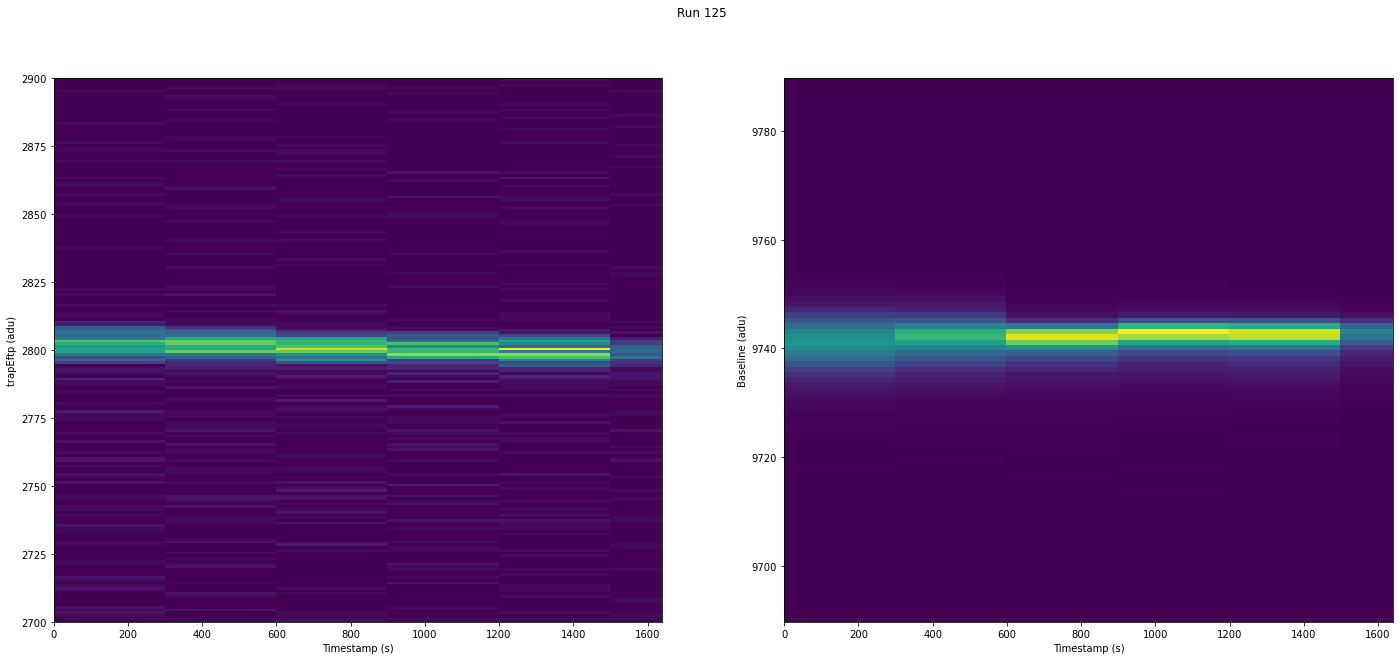

In [118]:
hist_1460_in_run(dg, 125, dsp_dir, True);

1460:  3.595999999999764 2.598076211353316
Baseline:  0.5993333333312048 3.0


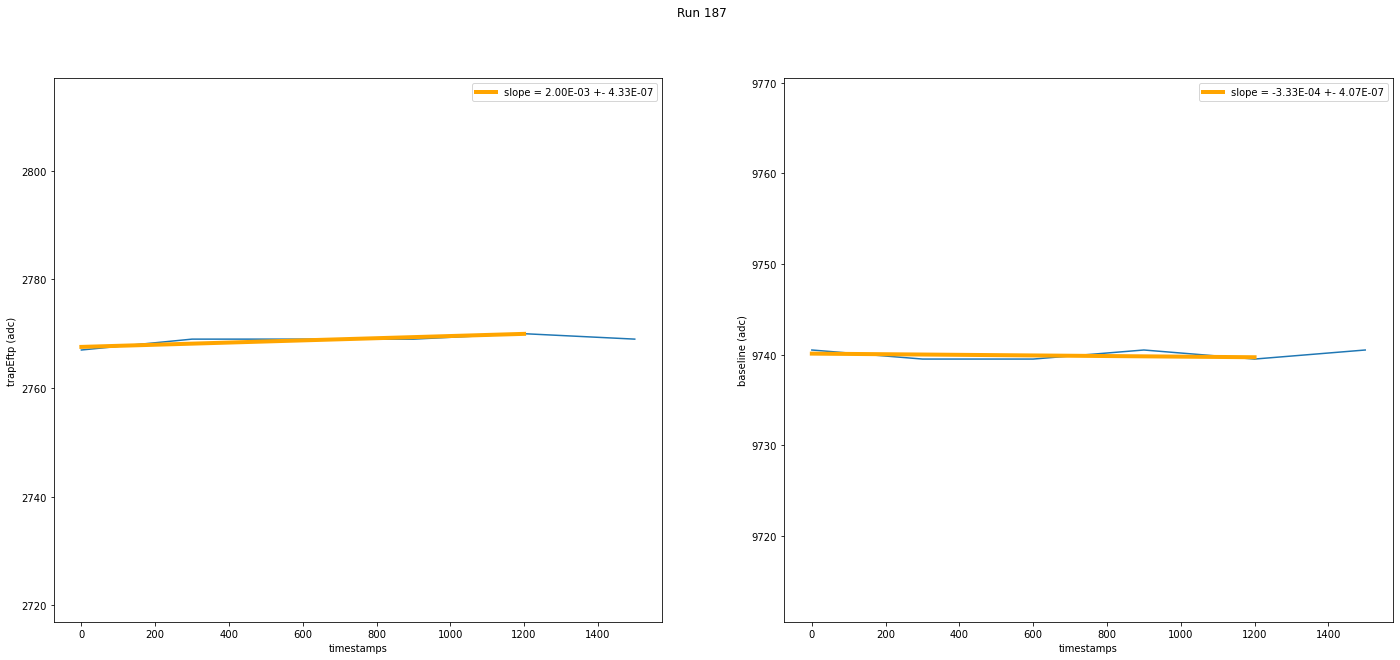

In [113]:
d = find_drifts(dg, 187, dsp_dir, True, False)